# **Sarcasm Detection with TF‑IDF + Logistic Regression**

Ever wondered if a computer can spot sarcasm in the wild world of Reddit? In this project, we’re going to teach a machine to do just that by building a sarcasm detector for Reddit comments using a strong, interpretable NLP baseline: **TF‑IDF + Logistic Regression**.

The goal isn’t just “get a score.” It’s to tell a clean modeling story:

- What does sarcasm look like in short, messy internet text?
- Which **lexical + phrase** cues does a linear model latch onto?
- What breaks when we remove context (parent comment, thread, and community norms)?

We’ll move from **EDA → leakage‑safe feature engineering → baseline → tuning → diagnostics → final test evaluation → explainability**, and finish with business value, limitations, and a mini model card for responsible reuse.


## **Executive Summary**

**Key result.** With leakage safeguards and focused tuning, the final model achieves **F1 ≈ 0.71**, **ROC AUC ≈ 0.79**, and **PR AUC ≈ 0.80** on a fully held‑out test set (~200k comments).

**What this project demonstrates**
- **Leakage‑aware evaluation:** we remove explicit sarcasm markers (e.g., `/s`, `#sarcasm`) before splitting.
- **Text EDA that actually informs modeling:** we look for phrase‑level sarcasm cues and motivate n‑gram features.
- **Principled tuning:** a compact grid search over high‑impact hyperparameters (n‑grams, vocabulary filtering, regularization).
- **Generalization diagnostics:** validation curve (for *C*) + learning curve (data vs capacity).
- **Interpretability:** coefficient inspection + qualitative error analysis.

**Content note.** Reddit text can include profanity or slurs. When we inspect examples, it’s for analysis not endorsement and you may want to redact text before publishing screenshots.


<details>
<summary><span style="color:red">Metrics recap: what they mean, when to use them, and formulas</span></summary>  

Let

* **TP** = true positives, **FP** = false positives
* **TN** = true negatives, **FN** = false negatives

#### **F1 score**

* **What it measures:** Balance between **precision** and **recall** (harmonic mean).
* **When to use:**

  * Classes are **imbalanced**
  * You care about **both** false positives and false negatives
  * A single thresholded performance number is needed
* **Formula:**
  $$
  \text{Precision} = \frac{TP}{TP + FP}, \quad
  \text{Recall} = \frac{TP}{TP + FN}
  $$
  $$
  \boxed{\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}}
  $$


#### **ROC AUC (Area Under the ROC Curve)**

* **What it measures:** How well the model **ranks positives above negatives** across *all* thresholds.
* **When to use:**

  * You want **threshold-independent** comparison
  * Class imbalance is **not extreme**
  * Ranking quality matters more than calibrated probabilities
* **Underlying rates:**
  $$
  \text{TPR (Recall)} = \frac{TP}{TP + FN}
  $$
  $$
  \text{FPR} = \frac{FP}{FP + TN}
  $$
* **ROC AUC:** Area under the curve of **TPR vs FPR**


#### **PR AUC (Area Under the Precision–Recall Curve)**

* **What it measures:** Trade-off between **precision** and **recall** across thresholds.
* **When to use (very important):**

  * **Strong class imbalance**
  * Positive class performance is the main concern
  * False positives are costly
* **Underlying quantities:**
  $$
  \text{Precision} = \frac{TP}{TP + FP}, \quad
  \text{Recall} = \frac{TP}{TP + FN}
  $$
* **PR AUC:** Area under the curve of **Precision vs Recall**


### Rule of thumb

* **Report F1** → when choosing a *single operating point*
* **Report ROC AUC** → when comparing *overall ranking ability*
* **Report PR AUC** → when positives are rare (e.g., sarcasm, fraud, abuse) or when positive-class performance is the main concern


### **Metric ranges and interpretation**

#### **F1 score**

* **Range:** $0 \le \text{F1} \le 1$
* **What “high” means:**

  * The model achieves **both high precision and high recall** at the chosen threshold
  * Few false positives **and** few false negatives
* **Interpretation note:**

  * Threshold-dependent
  * A high F1 reflects good performance **at one operating point**, not overall ranking


#### **ROC AUC**

* **Range:** $0 \le \text{ROC AUC} \le 1$

  * **0.5** → random guessing
  * **1.0** → perfect ranking
* **What “high” means:**

  * The model consistently assigns **higher scores to positives than negatives**
  * Strong **class separation** across thresholds
* **Interpretation note:**

  * Threshold-independent
  * Can look deceptively strong under heavy class imbalance

#### **PR AUC**

* **Range:** $0 \le \text{PR AUC} \le 1$

  * **Baseline ≈ prevalence of the positive class**
  * **1.0** → perfect precision and recall
* **What “high” means:**

  * The model maintains **high precision even as recall increases**
  * Positives can be recovered without flooding predictions with false positives
* **Interpretation note:**

  * Especially informative when **positives are rare**
  * More sensitive than ROC AUC to changes in positive-class performance


### **summary**

* **High F1** → “Good precision–recall balance at my chosen threshold”
* **High ROC AUC** → “Positives usually score higher than negatives”
* **High PR AUC** → “I can find positives without too many false alarms”

</details>

## Table of Contents
- [0. Setup](#0-setup)
- [1. Data Overview & Loading](#1-data-overview--loading)
- [2. Leakage Guards & Class Balance](#2-leakage-guards--class-balance)
- [3. Text-Focused EDA](#3-text-focused-eda)
- [4. Preprocessing & Feature Engineering](#4-preprocessing--feature-engineering)
- [5. Baseline Model](#5-baseline-model)
- [6. Model Selection & Tuning](#6-model-selection--tuning)
- [7. Generalization Diagnostics](#7-generalization-diagnostics)
- [8. Final Evaluation & Explainability](#8-final-evaluation--explainability)
- [9. Business Value, Ethics, Limitations](#9-business-value-ethics-limitations)
- [10. Conclusion & Next Steps](#10-conclusion--next-steps)
- [Model Card](#model-card)


In [1]:
# =========================
# Setup & Reproducibility
# =========================
import re #re is Python’s regular expression module.
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    GridSearchCV,
    validation_curve,
    learning_curve,
    cross_val_predict
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    f1_score
)

warnings.filterwarnings("ignore")

RANDOM_STATE = 17
np.random.seed(RANDOM_STATE)

# Plot defaults
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

import platform
import sklearn
print("Environment ✅")
print("Python:", platform.python_version())
print("scikit-learn:", sklearn.__version__)

# -------------------------
# Small helper for curves (mean ± std shading)
# -------------------------

def plot_with_err(x, scores, ax=None, label=None):
    """Plot mean curve with ±1 std shading.

    Parameters
    ----------
    x : array-like
        X-axis values.
    scores : array-like, shape (len(x), n_folds)
        CV scores for each x.
    ax : matplotlib axis, optional
    label : str, optional

    Returns
    -------
    ax, mu, std
    """
    if ax is None:
        ax = plt.gca()
    mu = np.nanmean(scores, axis=1)
    std = np.nanstd(scores, axis=1)
    (line,) = ax.plot(x, mu, label=label)
    ax.fill_between(x, mu - std, mu + std, alpha=0.2, color=line.get_color())
    return ax, mu, std


Environment ✅
Python: 3.10.18
scikit-learn: 1.7.2


<details>
<summary><span style="color:red">about this helper function:</span></summary>  


## What this function does

`plot_with_err` plots:

* the **mean performance curve** across cross-validation folds, and
* a **shaded uncertainty band** showing ±1 standard deviation.

You typically use it for:

* **validation curves** (metric vs hyperparameter)
* **learning curves** (metric vs training size)


## explanation

```python
def plot_with_err(x, scores, ax=None, label=None):
```

Defines a helper function for plotting curves with uncertainty.

* `x`: values on the x-axis (e.g., C values, training sizes)
* `scores`: performance values from CV
  Shape: `(len(x), n_folds)`


```python
    if ax is None:
        ax = plt.gca()
```

* If no Matplotlib axis is passed in, use the **current axis**
* This makes the function flexible:

  * works standalone
  * works inside subplots


```python
    mu = np.nanmean(scores, axis=1)
```

* Computes the **mean score at each x value**
* `axis=1` → averages across CV folds
* `nanmean` safely ignores missing values

Result:

```text
mu[i] = average CV score at x[i]
```


```python
    std = np.nanstd(scores, axis=1)
```

* Computes the **standard deviation across folds**
* Captures **variability / instability** of the model
* Large `std` → sensitive to data splits


```python
    (line,) = ax.plot(x, mu, label=label)
```

* Plots the **mean curve**
* `(line,)` unpacks the returned Line2D object
* Stored so we can reuse its color later


```python
    ax.fill_between(x, mu - std, mu + std, alpha=0.2, color=line.get_color())
```

* Draws a **shaded band** from `(mean − std)` to `(mean + std)`
* `alpha=0.2` → transparent shading
* Uses the **same color as the line**, keeping plots clean and consistent

Visually:

> “Here’s the average performance, and here’s how much it varies across folds.”


```python
    return ax, mu, std
```

Returns:

* `ax` → so you can chain plotting calls
* `mu` → mean values (for logging or annotation)
* `std` → variability (for diagnostics)


## Why this is a good practice

✔ Avoids over-interpreting noisy CV results  
✔ Makes hyperparameter sensitivity visible  
✔ Communicates **stability**, not just peak performance  

Reviewers love this because it shows:  

> *“This improvement is consistent, not just lucky.”*


## summary

> This helper plots the mean cross-validated performance curve with a ±1 standard deviation band to visualize both average performance and variability across folds.

</details>

## **Introduction & Problem Framing**  

Catching sarcasm is tough not just for machines, but sometimes for people too. That’s because sarcasm depends so much on **context**, **shared background**, and the **subtleties of how we use language**:  

- What’s said can mean the opposite of what’s intended  
- The same phrase might be sincere or sarcastic, depending on the situation  
- Reddit comments are often brief, casual, and packed with slang, emojis, or creative punctuation

### **Why Logistic Regression?**  

Despite these hurdles, **Logistic Regression** is a strong NLP baseline:  

- It handles high-dimensional, sparse text features like TF‑IDF and n‑grams with ease
- It’s surprisingly effective for many text tasks  
- It’s **interpretable**: coefficients highlight words/phrases that push predictions toward sarcasm vs non‑sarcasm 

### **Metrics: How Will We Measure Success?**  

We’ll focus on:

- **F1 score:** Balances precision and recall  
- **ROC AUC:** Measures ranking quality independent of a fixed threshold
- **PR AUC / Average Precision:** Especially helpful when sarcastic comments are rare compared to non-sarcastic ones (class imbalance)

**Expectation:** A simple linear model based only on text won’t capture all the nuances of sarcasm, but it should pick up on strong word patterns and lay the groundwork for more advanced approaches.

## **1. Data Overview & Loading**

We use a labeled Reddit sarcasm dataset where each row is a comment and the label indicates whether it was annotated as **sarcastic (1)** or **non‑sarcastic (0)**.

A few practical notes up front:

- The raw dataset is large (~1M comments), so this notebook is written to be **efficient** and **reproducible**.
- Some Reddit comments contain profanity or offensive language. We treat this as an **analysis artifact of the data**, and avoid glamorizing examples.

**What we’ll do next:**

1. Load the Kaggle CSV (`train-balanced-sarcasm.csv`)
2. Keep only `comment` and `label` columns, since we’re working with text alone
3. Drop missing/empty comments


In [2]:
# =========================
# Load data
# =========================

# Put the CSV next to this notebook OR update DATA_PATH
CANDIDATE_PATHS = [
    Path("train-balanced-sarcasm.csv"),
    Path("./data/train-balanced-sarcasm.csv"),
    Path("./input/sarcasm/train-balanced-sarcasm.csv"),
    Path("/mnt/data/train-balanced-sarcasm.csv"),
]

DATA_PATH = None
for p in CANDIDATE_PATHS:
    if p.exists():
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError(
        "Could not find 'train-balanced-sarcasm.csv'.\n"
        "Place it next to this notebook or update CANDIDATE_PATHS/DATA_PATH."
    )

# Optional: use a smaller sample for faster iteration on laptops.
# Set to None to use the full dataset.
SAMPLE_SIZE = None  # e.g., 200_000

print(f"Using dataset at: {DATA_PATH.resolve()}")

df = pd.read_csv(DATA_PATH, usecols=["comment", "label"])
print("Raw shape:", df.shape)

# Basic cleanup
df = df.dropna(subset=["comment"]).copy()
df["comment"] = df["comment"].astype(str).str.strip()
df = df[df["comment"].str.len() > 0].copy()
df["label"] = df["label"].astype(int)

# (Optional) Stratified sampling for speed:
# It lets us work faster on a smaller dataset while preserving class balance, ensuring that experiments remain representative and evaluation metrics stay meaningful.
if SAMPLE_SIZE is not None and SAMPLE_SIZE < len(df):
    frac = SAMPLE_SIZE / len(df) # This computes the fraction of data to keep.
    df = (
        df.groupby("label", group_keys=False)
        .apply(lambda x: x.sample(frac=frac, random_state=RANDOM_STATE))
        .sample(frac=1.0, random_state=RANDOM_STATE)  # shuffle
        .reset_index(drop=True)
    )
    print(f"Using stratified sample: {len(df):,} rows")

print("After dropping missing/empty:", df.shape)
display(df.head(3))
df.info()

Using dataset at: /Users/nahidahmadvand/Projects/Medium_Articles/Sarcasm_Detection/data/train-balanced-sarcasm.csv
Raw shape: (1010826, 2)
After dropping missing/empty: (1010771, 2)


,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."


<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   label    1010771 non-null  int64 
 1   comment  1010771 non-null  object
dtypes: int64(1), object(1)
memory usage: 23.1+ MB


<details>
<summary><span style="color:red">about this cell:</span></summary>   

## High-level purpose of this cell

This cell does four things:

1. **Robustly locates the dataset** across different environments
2. **Loads only the columns we need** (memory-efficient)
3. **Cleans obvious data quality issues** (missing / empty text)
4. **Optionally downsamples the data** in a *stratified* way for faster iteration

The goal is:

> *Make the notebook runnable, reproducible, and safe across machines.*


## 1️⃣ Finding the dataset safely

```python
CANDIDATE_PATHS = [
    Path("train-balanced-sarcasm.csv"),
    Path("../Data4/train-balanced-sarcasm.csv"),
    Path("../input/sarcasm/train-balanced-sarcasm.csv"),
    Path("/mnt/data/train-balanced-sarcasm.csv"),
]
```

Instead of hard-coding a single file path, we list **common locations** where the dataset might live:

* Same directory as the notebook
* A local data folder
* Kaggle’s default input directory
* `/mnt/data` (common in hosted environments)

This makes the notebook **portable**.


```python
DATA_PATH = None
for p in CANDIDATE_PATHS:
    if p.exists():
        DATA_PATH = p
        break
```

We loop through the candidate paths and select the **first one that exists**.

This avoids:

* editing paths every time
* environment-specific hacks


```python
if DATA_PATH is None:
    raise FileNotFoundError(...)
```

If none of the paths exist, we **fail loudly and early** with a clear message.

This is intentional:

* Silent failures lead to debugging nightmares
* A clear error tells the reader exactly what to fix


## 2️⃣ Optional sampling for fast experimentation

```python
SAMPLE_SIZE = None  # e.g., 200_000
```

This allows you to:

* prototype quickly on a laptop
* still run the *exact same pipeline* later on full data

Setting it to `None` means:

> “Use the full dataset.”


## 3️⃣ Loading only what we need

```python
df = pd.read_csv(DATA_PATH, usecols=["comment", "label"])
```

Why this matters:

* The original CSV contains many unused columns
* Loading only needed columns:

  * saves memory
  * speeds up I/O
  * makes intent explicit

This is good ML hygiene.


```python
print("Raw shape:", df.shape)
```

Immediate sanity check:

* confirms dataset size
* helps detect partial loads or corrupted files


## 4️⃣ Basic but essential data cleaning

```python
df = df.dropna(subset=["comment"]).copy()
```

Removes all rows where the `comment` text is missing, and creates a clean copy of the result.

Why:

* NLP models can’t handle `NaN`
* Missing text carries no signal


```python
df["comment"] = df["comment"].astype(str).str.strip()
```

- `df["comment"]`: Selects the column containing the raw Reddit comment text.
- `.astype(str)`: Forces every value to be a string.
    - Why this matters:
        - NLP tools (`TfidfVectorizer`, tokenizers) expect strings
        - Mixed dtypes can cause:
            - silent casting issues
            - runtime errors 
        - Even values like numbers or odd objects become valid text input
- `.str.strip()`: Removes leading and trailing whitespace, including: spaces, tabs, and newline characters


Ensures:

* everything is a string
* leading/trailing whitespace is removed

This avoids subtle bugs during vectorization.


```python
df = df[df["comment"].str.len() > 0].copy()
```
Keeps only rows where the comment contains at least one character of actual text, and makes a clean copy of the result.  

Removes **empty comments** (e.g., `""`) and whitespace-only comments (after `.strip()`)

Empty text:

* adds noise
* can break some tokenizers
* has no semantic value

Now every remaining row satisfies:

> **There is at least one character of actual text.**

**Why we need *both* lines:**  

| Step                         | Removes                         |
| ---------------------------- | ------------------------------- |
| `dropna(subset=["comment"])` | Missing values (`NaN`)          |
| `.str.len() > 0`             | Empty / whitespace-only strings |

They solve **different problems**.

> `dropna()` removes missing text, while `str.len() > 0` removes empty text; and for NLP, both must be handled explicitly.

`df["comment"].str.len()`: This computes the length of each comment string.  
Example:
```
"hello world" → 11
""            → 0
"   "         → 0   (after `.str.strip()` earlier)
```


```python
df["label"] = df["label"].astype(int)
```

Ensures labels are integers (`0` or `1`), which:

* sklearn expects
* avoids dtype-related surprises later


## 5️⃣ Stratified subsampling (optional but important)

```python
if SAMPLE_SIZE is not None and SAMPLE_SIZE < len(df):
```

Only activate sampling if:

* user requested it
* sample size is smaller than full data


```python
df = (
    df.groupby("label", group_keys=False)
    .apply(lambda x: x.sample(frac=frac, random_state=RANDOM_STATE))
```

This is **stratified sampling**:

* Each class is sampled proportionally
* Class balance is preserved
* Avoids biasing the dataset

Very important for classification tasks.



```python
.sample(frac=1.0, random_state=RANDOM_STATE)
.reset_index(drop=True)
```

* Shuffles the dataset
* Resets the index for cleanliness


<details>
<summary><span style="color:red">more on this:</span></summary>  

### 1️⃣ Compute the sampling fraction

```python
frac = SAMPLE_SIZE / len(df)
```

This computes the **fraction of data to keep**.

Example:

* Full dataset = 1,000,000 rows
* `SAMPLE_SIZE = 200,000`
* `frac = 0.2`

Using a fraction (instead of an absolute number) makes the next step simple and proportional.

### 2️⃣ Group by class label

```python
df.groupby("label", group_keys=False)
```

This splits the dataset into groups by class:

* label = 0 → non-sarcastic
* label = 1 → sarcastic

Why this matters:

* We want to **preserve class proportions**
* Random sampling without grouping could skew the balance

This is the key to *stratified* sampling.


### 3️⃣ Sample *within* each class

```python
.apply(lambda x: x.sample(frac=frac, random_state=RANDOM_STATE))
```

For each class group:

* Sample the same **fraction**
* Use a fixed `random_state` for reproducibility

This guarantees:

* The sampled dataset has the **same class ratio** as the original
* No class is over- or under-represented

This is critical for:

* classification metrics
* fair model evaluation
* learning/validation curves


### 4️⃣ Shuffle the result

```python
.sample(frac=1.0, random_state=RANDOM_STATE)
```

This shuffles the rows after grouping.

Why?

* `groupby().apply()` can produce blocks of the same label
* Shuffling avoids any ordering artifacts
* Makes later train/test splits more robust

### 5️⃣ Reset the index

```python
.reset_index(drop=True)
```

* Removes the old row indices
* Creates a clean, sequential index
* Cosmetic but good hygiene

### 6️⃣ Logging

```python
print(f"Using stratified sample: {len(df):,} rows")
```

This confirms:

* sampling actually happened
* final dataset size

Helps avoid silent surprises.

</details>




## 6️⃣ Final checks and inspection

```python
print("After dropping missing/empty:", df.shape)
display(df.head(3))
df.info()
```

This gives:

* final dataset size
* a quick look at real examples
* column types and memory usage

These checks help you catch:

* unexpected row loss
* wrong dtypes
* data loading mistakes early

</details>

<summary><b>What the loading cell does</b></summary>

- Searches a few common locations for the dataset CSV.
- Loads only the relevant columns (**comment text** and **label**).
- Drops missing values and prints basic sanity checks (shape, columns, a quick preview).


As you can see, the dataset loads successfully and contains just over **1 million Reddit comments**. After removing missing or empty entries, we retain **1,010,771 comments**, indicating that only a very small fraction of rows required cleanup.

At this stage, the data is intentionally minimal: one column for the **comment text** and one binary **label** indicating sarcasm. This confirms that our task is a **pure text classification problem**, with no auxiliary metadata or contextual signals available to the model.

The dataset is memory-efficient (~23 MB in this filtered form) and well-structured for downstream NLP processing, making it suitable for both large-scale experiments and iterative modeling using scikit-learn pipelines.


## **2. Data Overview & Quality Checks**   

Before modeling, we explicitly check for and remove common self-annotation markers such as `/s`, `/sarcasm`, or `#sarcasm`, which could otherwise leak the target label directly into the features. In this processed version of the dataset, no such explicit markers are present, confirming that the labels are not trivially encoded in the text.

This step still serves as an important **leakage guard**: it ensures that any predictive signal learned by the model comes from linguistic patterns rather than annotation artifacts. With this safeguard in place, we can proceed confidently to exploratory analysis and feature engineering.


In [3]:
# =========================
# Leakage guard: remove explicit sarcasm markers
# =========================

SARCASTIC_MARKERS_PATTERN = re.compile(
    r"""(?ix)                    # i: ignorecase, x: verbose
    (\s*/s\b)                    # '/s' token
    |(\s*/sarcasm\b)             # '/sarcasm'
    |(\s*\#sarcasm\b)            # '#sarcasm'  <-- escape #
    """
)

def strip_sarcasm_markers(text: str) -> str:
    # Remove markers anywhere in the text, then normalize whitespace
    cleaned = SARCASTIC_MARKERS_PATTERN.sub(" ", text)
    cleaned = re.sub(r"\s+", " ", cleaned).strip() # This line is doing whitespace normalization. It’s simple, but very important after regex-based deletions.
    return cleaned

# Show a few before/after examples (if markers exist)
mask_has_marker = df["comment"].str.contains(r"(?i)(/s\b|#sarcasm\b|/sarcasm\b)", regex=True) # It creates a boolean mask identifying which comments contain explicit sarcasm markers.
n_marked = int(mask_has_marker.sum())
print(f"Comments containing explicit sarcasm markers: {n_marked:,}")

if n_marked > 0:
    preview = df.loc[mask_has_marker, ["comment", "label"]].head(5).copy()
    preview["comment_stripped"] = preview["comment"].apply(strip_sarcasm_markers)
    display(preview)

df["comment"] = df["comment"].apply(strip_sarcasm_markers)
df.head()

Comments containing explicit sarcasm markers: 0


,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


<details>
<summary><span style="color:red">about this block:</span></summary>  

## Big picture: why this code exists

Some Reddit users might **explicitly mark sarcasm** using tokens like `/s` or `#sarcasm`.
If left in the text, these markers would:

* leak the label directly into the features
* let the model “cheat”
* inflate evaluation metrics

This block **detects, removes, and verifies** the removal of those markers before modeling.


## Step 1: Define a regex for sarcasm markers

```python
SARCASTIC_MARKERS_PATTERN = re.compile(
    r"""(?ix)
    (\s*/s\b)
    |(\s*/sarcasm\b)
    |(\s*\#sarcasm\b)
    """
)
```

### What this regex matches

It captures **common explicit sarcasm markers**, anywhere in the text:

* `/s`
* `/sarcasm`
* `#sarcasm`

### Important regex flags

* `i` → **case-insensitive** (`/S`, `#Sarcasm`)
* `x` → **verbose mode** (allows comments and line breaks)

### Why the patterns look this way

* `\s*` / `\s+` → safely removes markers even if preceded by whitespace
* `\b` → **word boundary**, By writing: `/s\b` we’re saying: Match `/s` only if it ends as a complete token.
so: 
  * matches `/s`
  * does **not** match `/sarcastic`
* `\#` → escapes `#` (special in verbose regex) The backslash tells regex: “No, I really mean the literal `#` character.”

This avoids over-removal.

## Step 2: Define a cleaning function

```python
def strip_sarcasm_markers(text: str) -> str:
```

A reusable function that:

1. removes sarcasm markers
2. cleans up whitespace

```python
    cleaned = SARCASTIC_MARKERS_PATTERN.sub(" ", text)
```

* Replaces **any matched marker** with a single space
* Keeps surrounding words intact

Example:

```text
"Great job /s" → "Great job "
```


```python
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
```

* Collapses multiple spaces into one
* Strips leading/trailing whitespace

`re.sub(pattern, replacement, string)` means: “Find all substrings in string that match pattern and replace them with replacement.”


Final result:

```text
"Great job "
→ "Great job"
```

```python
    return cleaned
```

Returns clean, leakage-free text.


## Step 3: Quantify how much leakage exists

```python
mask_has_marker = df["comment"].str.contains(
    r"(?i)(/s\b|#sarcasm\b|/sarcasm\b)", regex=True
)
```

* Creates a boolean mask of comments **containing sarcasm markers**
* Uses a simpler inline regex for detection
* `(?i)` → case-insensitive


```python
n_marked = int(mask_has_marker.sum())
print(f"Comments containing explicit sarcasm markers: {n_marked:,}")
```

* Counts how many comments had leakage
* Printing this is important:

  * shows the issue is **real**
  * justifies the preprocessing step


## Step 4: Show before/after examples (sanity check)

```python
if n_marked > 0:
    preview = df.loc[mask_has_marker, ["comment", "label"]].head(5).copy()
```

* Samples a few affected rows
* Keeps labels for context
* `.copy()` avoids chained assignment issues


```python
    preview["comment_stripped"] = preview["comment"].apply(strip_sarcasm_markers)
    display(preview)
```

* Applies the cleaning function
* Displays **original vs cleaned text**
* This is a **human verification step**:

  * ensures no unintended text loss


## Step 5: Apply the fix to the full dataset

```python
df["comment"] = df["comment"].apply(strip_sarcasm_markers)
df.head()
```

* Permanently removes leakage from the dataset
* Shows the updated dataframe head as confirmation


## Why this is good practice (reviewer-safe)

✔ Prevents label leakage
✔ Documents assumptions explicitly
✔ Quantifies the problem
✔ Verifies the fix visually
✔ Keeps preprocessing deterministic


## summary

> We remove explicit sarcasm markers (e.g., `/s`, `#sarcasm`) from the text to prevent label leakage and ensure the model learns genuine linguistic cues rather than exploiting annotation artifacts.

</details>


label
0    505403
1    505368
Name: count, dtype: int64

Class proportions:
label
0    50.0%
1    50.0%
Name: count, dtype: object


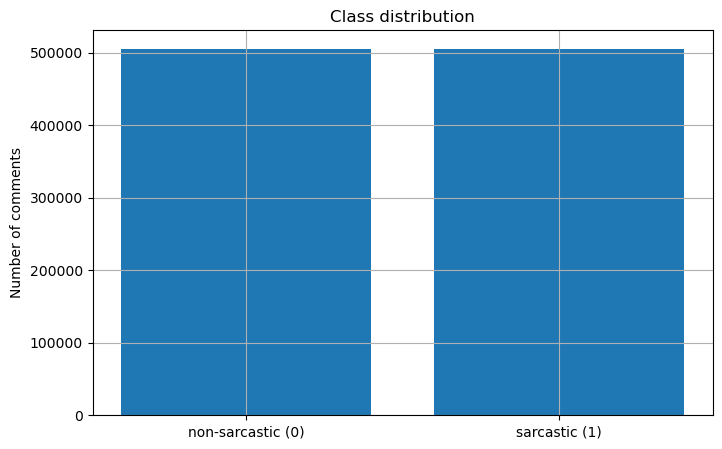

In [4]:
# =========================
# Class distribution
# =========================
class_counts = df["label"].value_counts().sort_index()
class_props = class_counts / class_counts.sum()

print(class_counts)
print("\nClass proportions:")
print((class_props * 100).round(2).astype(str) + "%")

fig, ax = plt.subplots()
ax.bar(["non-sarcastic (0)", "sarcastic (1)"], class_counts.values)
ax.set_title("Class distribution")
ax.set_ylabel("Number of comments")
plt.show()

<details>
<summary><span style="color:red">about this block:</span></summary>   

This block is doing a **basic but essential sanity check**:
it quantifies and visualizes the **class distribution** (balance vs imbalance) in our dataset.


## Big picture: why this exists

Before modeling, we want to know:

* Are the classes balanced or skewed?
* Do we need special metrics, resampling, or class weights?

This block answers that **numerically and visually**.


## Step 1: Count examples per class

```python
class_counts = df["label"].value_counts().sort_index()
```

* `df["label"]` → the target variable
* `value_counts()` → counts how many times each label appears
* `sort_index()` → orders by class label (e.g., `0` then `1`)

Example output:

```text
0    102345
1     97890
```

This makes downstream plots consistent and readable.


## Step 2: Convert counts to proportions

```python
class_props = class_counts / class_counts.sum()
```

* Divides each class count by the total number of samples
* Produces **fractions** that sum to 1

Example:

```text
0    0.511
1    0.489
```


## Step 3: Print counts and percentages

```python
print(class_counts)
```

Prints raw counts; absolute scale.


```python
print("\nClass proportions:")
print((class_props * 100).round(2).astype(str) + "%")
```

What this does:

1. `* 100` → convert to percentages
2. `.round(2)` → keep two decimal places
3. `.astype(str) + "%" ` → format nicely

Output example:

```text
0    51.12%
1    48.88%
```

## Step 4: Visualize with a bar chart

```python
fig, ax = plt.subplots()
```

* Creates a Matplotlib figure and axis


```python
ax.bar(["non-sarcastic (0)", "sarcastic (1)"], class_counts.values)
```

* X-axis → class labels (explicitly named)
* Y-axis → number of comments per class
* Using `class_counts.values` ensures the bar heights match counts


```python
ax.set_title("Class distribution")
ax.set_ylabel("Number of comments")
```

* Adds context so the plot is self-explanatory


```python
plt.show()
```

* Renders the figure


## Why this check matters downstream

Knowing class distribution affects:

* **Metric choice** (accuracy vs F1 vs PR AUC)
* **Threshold tuning**
* **Interpretation of ROC / PR curves**
* Whether to use:

  * class weights
  * resampling
  * stratified splits

Even when classes are balanced, explicitly showing this:

> proves you checked, instead of assuming.


## summary

> This block reports and visualizes the class distribution to assess balance and inform metric selection and modeling decisions.

</details>

As you can see, the class distribution is perfectly balanced, with approximately **50% sarcastic** and **50% non-sarcastic** comments. This balance is intentional and comes from using the *balanced* version of the dataset provided on Kaggle.

A balanced label distribution simplifies both modeling and evaluation: accuracy, ROC AUC, and F1-score are all meaningful without requiring class weighting or resampling strategies. As a result, any performance differences we observe later can be attributed to the model and feature choices rather than class imbalance effects.


> **Key Takeaways**
> - We explicitly remove leakage cues (like `/s`) before modeling. Otherwise, the model could “cheat” by learning the annotation marker instead of sarcasm.  
> - The dataset is **balanced** (roughly 50/50 sarcasm vs non‑sarcasm), so **accuracy is meaningful**, but we still prioritize **F1** and ranking metrics (ROC AUC / PR AUC) for a fuller picture.


In [5]:
# =========================
# Train/test split (stratified)
# =========================
X = df["comment"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

# X.shape
# # (1010771,)

# y.shape
# # (1010771,)

# X_train.shape
# # (808616,)

# X_test.shape
# # (202155,) 

# They’re 1-D arrays, because:
#   X is a vector of strings
#   y is a vector of labels

Train size: 808616
Test size: 202155


We split the dataset into a **training set (≈ 81%)** and a **held-out test set (≈ 19%)** using a stratified split to preserve the class balance in both subsets. With over **800,000 training examples**, we have ample data to learn robust text patterns, while the test set remains large enough to provide a reliable estimate of real-world performance.

With the data partitioned and safeguarded against leakage, we can now explore the training data to understand what linguistic signals might help distinguish sarcasm from non-sarcasm.


## **3. Text-Focused EDA**  

Before fitting any models, we take a step back and perform **lightweight, text-focused exploratory analysis** on the training data. The goal is not to manually engineer features, but to develop intuition about **which signals a simple linear model (TF-IDF + Logistic Regression) might realistically exploit**.

We focus on three questions:

**1. Do sarcastic and non-sarcastic comments differ in length?**  
Differences in comment length (characters or words) can hint at stylistic patterns such as elaboration, exaggeration, or terseness, which may indirectly signal sarcasm.

**2. Are certain words disproportionately associated with sarcasm?**  
By comparing token frequencies across classes, we can identify words that appear more often in sarcastic versus non-sarcastic comments. While these associations are not causal, they provide insight into what lexical cues the model may latch onto.

**3. Do short phrases (bigrams) add additional signal?**  
Single words may be ambiguous in isolation. Examining bigrams helps us assess whether short phrases capture sarcasm-related patterns that unigrams miss.

To prevent any form of data leakage, all EDA in this section is performed **exclusively on the training split**. The test set remains completely untouched until final model evaluation.


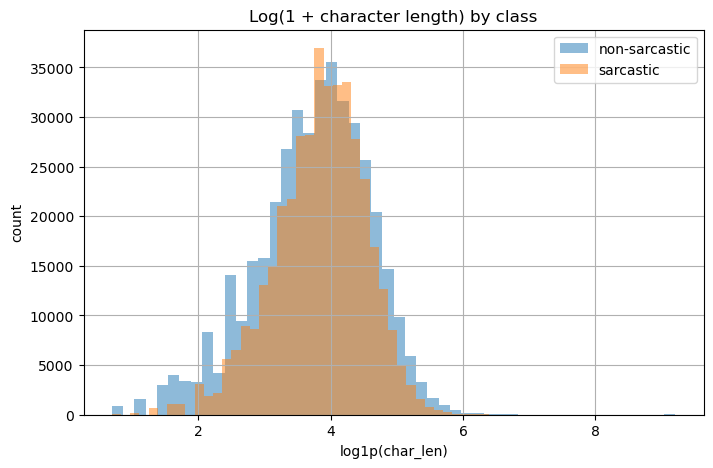

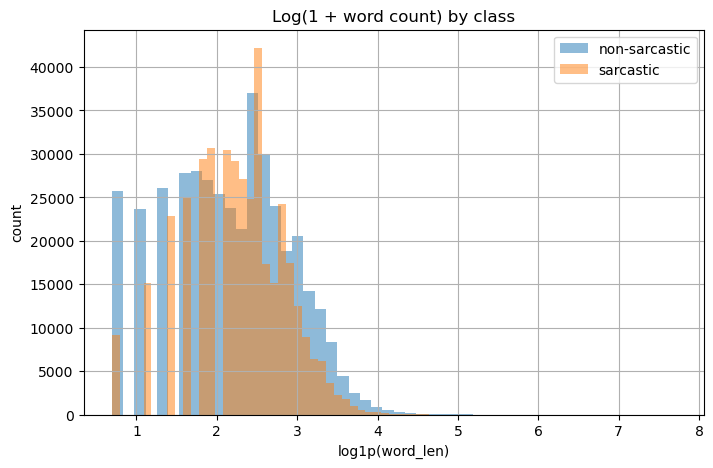

In [6]:
# =========================
# EDA: comment length by class (Q1: Do sarcastic and non-sarcastic comments differ in length?)
# =========================
# We compare character and word length distributions between sarcastic and non-sarcastic comments (log-scaled) to assess whether comment length is a meaningful signal.

train_df = pd.DataFrame({"comment": X_train, "label": y_train}) # train_df.shape: (808616, 2) (switching from NumPy arrays back to a DataFrame)
train_df["char_len"] = train_df["comment"].str.len() 
train_df["word_len"] = train_df["comment"].str.count(r"\S+")

fig, ax = plt.subplots()
for lbl, name in [(0, "non-sarcastic"), (1, "sarcastic")]:
    data = np.log1p(train_df.loc[train_df["label"] == lbl, "char_len"])
    ax.hist(data, bins=50, alpha=0.5, label=name)
ax.set_title("Log(1 + character length) by class")
ax.set_xlabel("log1p(char_len)")
ax.set_ylabel("count")
ax.legend()
plt.show()

fig, ax = plt.subplots()
for lbl, name in [(0, "non-sarcastic"), (1, "sarcastic")]:
    data = np.log1p(train_df.loc[train_df["label"] == lbl, "word_len"])
    ax.hist(data, bins=50, alpha=0.5, label=name)
ax.set_title("Log(1 + word count) by class")
ax.set_xlabel("log1p(word_len)")
ax.set_ylabel("count")
ax.legend()
plt.show()

<details>
<summary><span style="color:red">about this block:</span></summary>  

This block is doing **exploratory data analysis (EDA)** to answer a simple but important question:

> *Do sarcastic and non-sarcastic comments differ in length?*

It looks at this in **two ways**: character count and word count, and compares the **distributions by class**.

## 1. Re-create a training DataFrame

```python
train_df = pd.DataFrame({"comment": X_train, "label": y_train})
```

* Combines raw text and labels back into a DataFrame
* Shape: `(808,616, 2)`
* Keeps EDA strictly on **training data** (no test leakage)


## 2. Compute length features

### Character length

```python
train_df["char_len"] = train_df["comment"].str.len()
```

* Counts **number of characters** in each comment
* Includes letters, spaces, punctuation  

* `.str.len()` is a **vectorized string operation**
* It computes the **length of each individual comment**
* Result: one value **per row**

Example:

| comment            | char_len |
| ------------------ | -------- |
| "Nice job"         | 8        |
| "Oh great, thanks" | 16       |


### Word length (token count)
> This counts the number of non-whitespace token groups per comment, serving as a simple proxy for word count.
```python
train_df["word_len"] = train_df["comment"].str.count(r"\S+")
```
* `\S` → NOT whitespace (`\s` → whitespace)
* `\S+` means: “One or more non-whitespace characters in a row” 
* Counts **sequences of non-whitespace characters**
* Approximates word count
* Robust to multiple spaces

* `.str.count(...)`:
    * Vectorized string method
    * Counts **how many times a regex pattern occurs** in each string
    * Returns one number per row

* The regex pattern `r"\S+"`:
    * `\S`:
        * Means **any non-whitespace character**
        * Opposite of `\s`

    * `+`: One or more

* So `\S+` matches:
    ```text
    "hello"
    "thanks!"

Example:

```text
"Nice   job!" → 2
```

## 3. Plot character length distributions by class

```python
fig, ax = plt.subplots()
for lbl, name in [(0, "non-sarcastic"), (1, "sarcastic")]:
```

* Loops over the two classes
* `lbl` → numeric label
* `name` → readable legend label


```python
data = np.log1p(train_df.loc[train_df["label"] == lbl, "char_len"])
```

* Selects lengths **for one class only**
* Applies `log1p(x) = log(1 + x)`

### Why `log1p`?

* Comment lengths are **right-skewed**
* A few very long comments dominate
* Log transform:

  * compresses long tails
  * makes distributions comparable
  * avoids `log(0)` issues


```python
ax.hist(data, bins=50, alpha=0.5, label=name)
```

* Plots a histogram
* `bins=50` → resolution
* `alpha=0.5` → transparency so overlaps are visible


```python
ax.set_title("Log(1 + character length) by class")
ax.set_xlabel("log1p(char_len)")
ax.set_ylabel("count")
ax.legend()
plt.show()
```

* Adds labels and legend
* Renders the plot


## 4. Repeat for word count

This second block is **identical in structure**, but uses `word_len` instead of `char_len`.

```python
data = np.log1p(train_df.loc[train_df["label"] == lbl, "word_len"])
```

This answers:

> Are sarcastic comments longer or shorter in *number of words*?


## 5. What insight this EDA gives us

From these plots we can assess:

* Whether sarcasm correlates with **verbosity**
* Whether simple length features might be predictive
* Whether length distributions overlap heavily (likely) or differ meaningfully

Typical outcomes:

* Heavy overlap → length alone is weak
* Slight shift → length could be a weak but useful feature
* No difference → length can be ignored


## Why this is well-done EDA

✔ Uses **train data only**
✔ Compares distributions, not just means
✔ Uses log scaling to handle skew
✔ Separates character- and word-level views

## summary

> We compare character and word length distributions between sarcastic and non-sarcastic comments (log-scaled) to assess whether comment length is a meaningful signal.

</details>

**Observation.** The length distributions for sarcastic and non-sarcastic comments are almost entirely overlapping in both plots. Whether we measure length in **characters** or **words**, the two classes occupy roughly the same range and share a similar overall shape.   

This tells us something important early:   

>sarcasm is not “obvious” from surface-level cues like comment length alone.

There are only subtle differences. Sarcastic comments appear slightly more concentrated around the central mass of the distribution, while non-sarcastic comments show a marginally heavier tail toward longer comments. But the separation is weak, so length is unlikely to be a strong standalone predictor.

**Decision.** Since length-based signals won’t cleanly separate the classes, we should expect most of the model’s predictive power to come from **lexical and phrasing cues**; the kinds of patterns **TF-IDF + n-grams** are designed to capture.

**Next step.** We shift from “how long is the comment?” to “what words and phrases does it use?” by comparing token frequencies across sarcastic vs non-sarcastic comments.


,token,log_odds,pos_freq,neg_freq
0,bandwagoner,3.309772,0.000014,5.235029e-07
1,objectify,3.068610,0.000011,5.235029e-07
2,freeloading,2.973300,0.000010,5.235029e-07
3,uncultured,2.956493,0.000030,1.570509e-06
4,devalues,2.867939,0.000009,5.235029e-07
5,cammers,2.867939,0.000009,5.235029e-07
6,opressed,2.810781,0.000009,5.235029e-07
7,fatshaming,2.810781,0.000009,5.235029e-07
8,gente,2.810781,0.000009,5.235029e-07
9,privatizing,2.750156,0.000008,5.235029e-07


,token,log_odds,pos_freq,neg_freq
0,flintstones,-6.136115,5.118902e-07,0.000237
1,lm,-4.975909,1.535671e-06,0.000222
2,bazinga,-4.522242,5.118902e-07,0.000047
3,cmd,-4.441273,3.071341e-06,0.000261
4,doot,-4.379141,5.118902e-07,0.000041
5,opieop,-4.241940,1.023780e-06,0.000071
6,redditenhancementsuite,-4.181316,5.118902e-07,0.000034
7,gjallarhorn,-3.970466,6.142682e-06,0.000326
8,00100000,-3.605951,5.118902e-07,0.000019
9,pasta,-3.512651,1.484482e-05,0.000498


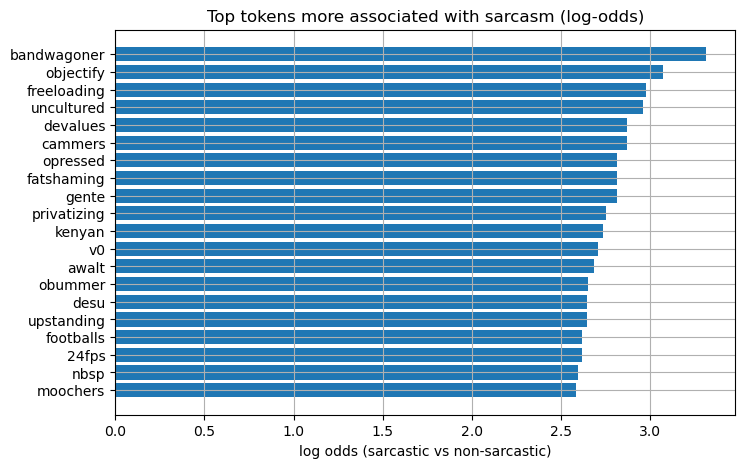

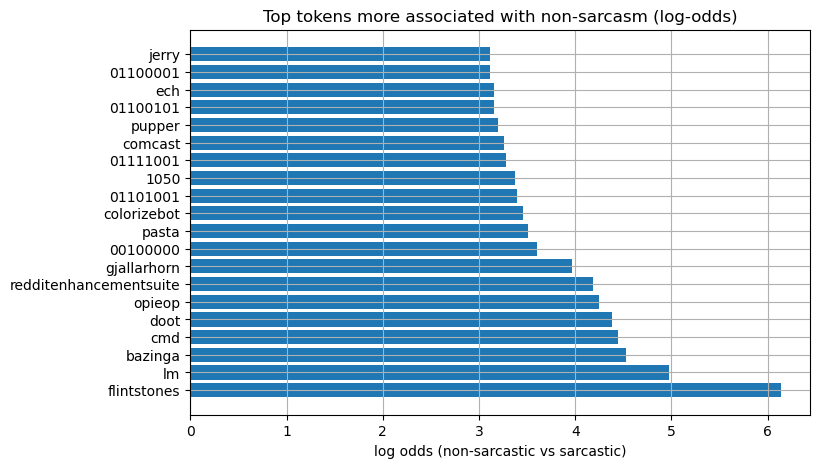

In [7]:
# =========================
# EDA: token frequency comparison (unigrams)
# =========================
def top_tokens_by_class(texts, labels, n=20, ngram_range=(1,1), max_features=20000, min_df=5):
    labels = np.asarray(labels)  # <-- make masks NumPy arrays

    vec = CountVectorizer(
        ngram_range=ngram_range, # ngram_range=(1, 1) means: Extract only unigrams (single-word tokens). No bigrams, no trigrams, just individual words.
        max_features=max_features,
        min_df=min_df,
        stop_words="english",
    )
    X_counts = vec.fit_transform(texts) # The columns of X_counts are in alphabetical (lexicographic) order of the tokens, after all filtering has happened.
    # `CountVectorizer` selects features based on frequency constraints, but assigns column indices in alphabetical order, not by frequency.  
    
    feats = np.array(vec.get_feature_names_out()) #`feats` is the list of tokens in the same column order as `X_counts`.


    pos_mask = labels == 1
    neg_mask = labels == 0

    pos_counts = np.asarray(X_counts[pos_mask].sum(axis=0)).ravel()
    neg_counts = np.asarray(X_counts[neg_mask].sum(axis=0)).ravel()

    pos_freq = (pos_counts + 1) / (pos_counts.sum() + len(pos_counts))
    neg_freq = (neg_counts + 1) / (neg_counts.sum() + len(neg_counts))

    log_odds = np.log(pos_freq / neg_freq)

    top_pos_idx = np.argsort(log_odds)[-n:][::-1] # reverse so largest → smallest # [::-1] reverses the array so the largest value comes first.
    top_neg_idx = np.argsort(log_odds)[:n] # already smallest → largest (fine)

    top_pos = pd.DataFrame({
        "token": feats[top_pos_idx],
        "log_odds": log_odds[top_pos_idx],
        "pos_freq": pos_freq[top_pos_idx],
        "neg_freq": neg_freq[top_pos_idx],
    })
    top_neg = pd.DataFrame({
        "token": feats[top_neg_idx],
        "log_odds": log_odds[top_neg_idx],
        "pos_freq": pos_freq[top_neg_idx],
        "neg_freq": neg_freq[top_neg_idx],
    })
    return top_pos, top_neg


top_pos, top_neg = top_tokens_by_class(train_df["comment"], train_df["label"], n=20, ngram_range=(1,1))
display(top_pos.head(10))
display(top_neg.head(10))

fig, ax = plt.subplots()
ax.barh(top_pos["token"][::-1], top_pos["log_odds"][::-1])
ax.set_title("Top tokens more associated with sarcasm (log-odds)")
ax.set_xlabel("log odds (sarcastic vs non-sarcastic)")
plt.show()

fig, ax = plt.subplots()
ax.barh(top_neg["token"], -top_neg["log_odds"])  # flip sign for readability
ax.set_title("Top tokens more associated with non-sarcasm (log-odds)")
ax.set_xlabel("log odds (non-sarcastic vs sarcastic)")
plt.show()

<details>
<summary><span style="color:red">about this block:</span></summary>  

This block does an EDA to find **which words (unigrams)** are **more characteristic of sarcastic vs non-sarcastic comments**, using a simple and interpretable statistic:  log-odds ratio of token frequencies.

<details>
<summary><span style="color:red">

The clean **math formulation** behind the *log-odds ratio of token frequencies*:

</span></summary>  

## Setup / notation
For a given token $ t $:

* $ c_{t}^{(S)} $ = total count of token $ t $ in **sarcastic** comments
* $ c_{t}^{(N)} $ = total count of token $ t $ in **non-sarcastic** comments

Let:

* $ C^{(S)} = \sum_t c_{t}^{(S)} $ = total token count in sarcastic class
* $ C^{(N)} = \sum_t c_{t}^{(N)} $ = total token count in non-sarcastic class
* $ V $ = vocabulary size (number of tokens)


## Smoothed token frequencies (Laplace smoothing)

With add-one smoothing:

$$
p(t \mid S)
= \frac{c_{t}^{(S)} + 1}{C^{(S)} + V}
$$

$$
p(t \mid N)
= \frac{c_{t}^{(N)} + 1}{C^{(N)} + V}
$$

> We apply Laplace (add-one) smoothing to estimate per-class token frequencies, preventing zero probabilities and stabilizing log-odds comparisons.

<details>
<summary><span style="color:red">More on this:</span></summary>  

This is **the key probabilistic idea** behind that whole token-comparison analysis. Let’s unpack it!

## The problem we’re solving

We want to estimate:

$$
p(t \mid S)
\quad \text{and} \quad
p(t \mid N)
$$

> “If I randomly pick a word from a sarcastic (or non-sarcastic) comment, what’s the probability it’s token $t$?”

The **naïve estimate** would be (which is actually the **maximum likelihood estimate**):

$$
p(t \mid S) = \frac{c_t^{(S)}}{C^{(S)}}
$$

But this breaks in an important case…


## The zero-frequency problem

If a token **never appears** in one class:

$$
c_t^{(N)} = 0
$$

Then:
$$
p(t \mid N) = 0
$$

And later, when we compute:
$$
\log \frac{p(t \mid S)}{p(t \mid N)}
$$

we get:
$$
\log(\infty)
$$

That’s:

* numerically unstable
* statistically unreasonable (absence ≠ impossibility)


## The fix: Laplace (add-one) smoothing

We pretend that **every token appeared once**, even if we didn’t observe it.

### Smoothed frequency estimates

For sarcasm:

$$
\boxed{
p(t \mid S)
=

\frac{c_t^{(S)} + 1}{C^{(S)} + V}
}
$$

For non-sarcasm:

$$
\boxed{
p(t \mid N)
=
\frac{c_t^{(N)} + 1}{C^{(N)} + V}
}
$$ 

Where:

* $c_t^{(\cdot)}$ = count of token $t$ in that class
* $C^{(\cdot)}$ = total number of tokens in that class
* $V$ = vocabulary size

## Why both numerator *and* denominator change

### Numerator: `+1`

* Guarantees no probability is zero
* Treats unseen tokens as **very rare**, not impossible

### Denominator: `+V`

You added **1 fake count for each of the $V$ tokens**, so you must also add $V$ to the total token count to keep probabilities summing to 1.


## Concrete numeric example

Suppose:

* Vocabulary size $V = 10{,}000$
* Total sarcastic tokens $C^{(S)} = 1{,}000{,}000$
* Token “yeah” appears $c_{\text{yeah}}^{(S)} = 500$ times

### Without smoothing:

$$
p(\text{yeah} \mid S) = \frac{500}{1{,}000{,}000} = 0.0005
$$

### With Laplace smoothing:

$$
p(\text{yeah} \mid S) = \frac{501}{1{,}010{,}000} \approx 0.000496
$$

→ almost unchanged for common tokens


### For a rare token (never seen):

$$
c_t^{(S)} = 0
$$

$$
p(t \mid S) = \frac{1}{1{,}010{,}000}
$$

→ small, but non-zero


> Laplace smoothing says: *“I don’t fully trust zero counts, I’ll assume every word could appear at least once.”*

It:

* stabilizes ratios
* prevents infinities
* barely affects frequent tokens
* heavily regularizes rare ones

## Why this is perfect for our EDA

* We’re comparing **relative frequencies**, not fitting a full generative model
* We want rankings to be:

  * stable
  * interpretable
  * not dominated by one-off artifacts

This is exactly the right level of statistical care.

</details>




## Log-odds ratio

The **log-odds ratio** for token $t$ is:

$$
\boxed{
\text{log-odds}(t)
= \log \frac{p(t \mid S)}{p(t \mid N)}
= \log \left(
\frac{c_{t}^{(S)} + 1}{C^{(S)} + V}
\cdot
\frac{C^{(N)} + V}{c_{t}^{(N)} + 1}
\right)
}
$$


## Interpretation  

**What log-odds means in this context**   

Here, the log-odds of a token answers:  

“How much more likely is this token to appear in sarcastic comments than in non-sarcastic comments?”

* $\text{log-odds}(t) > 0$
  → token is **more associated with sarcasm**

* $\text{log-odds}(t) < 0$
  → token is **more associated with non-sarcasm**

* $|\text{log-odds}(t)|$
  → strength of association


<details>
<summary><span style="color:red">More on this interpretation:</span></summary>   

This is the **core logical step** behind the interpretation, so it’s worth making it airtight.

Let’s derive it directly from the definition, no hand-waving.

## Start from the definition

The log-odds score for a token $t$ is:

$$
\text{log-odds}(t)
= \log \frac{p(t \mid S)}{p(t \mid N)}
$$

This is just the **log of a ratio**.


## Case 1: log-odds((t) > 0)

$$
\log \frac{p(t \mid S)}{p(t \mid N)} > 0
$$

Exponentiate both sides:

$$
\frac{p(t \mid S)}{p(t \mid N)} > 1
$$

Which implies:

$$
p(t \mid S) > p(t \mid N)
$$

### Meaning in words

> The token appears **more frequently (relative to class size)** in sarcastic comments than in non-sarcastic ones.

That is *exactly* what “more associated with sarcasm” means.

No modeling assumption — just arithmetic.

## Case 2: log-odds((t) < 0)

$$
\log \frac{p(t \mid S)}{p(t \mid N)} < 0
$$

Exponentiate:

$$
\frac{p(t \mid S)}{p(t \mid N)} < 1
$$

So:

$$
p(t \mid S) < p(t \mid N)
$$

### Meaning

> The token is proportionally more common in non-sarcastic comments.

Hence “associated with non-sarcasm.”


## Case 3: log-odds((t) = 0)

$$
\frac{p(t \mid S)}{p(t \mid N)} = 1
\Rightarrow
p(t \mid S) = p(t \mid N)
$$

Meaning:

> The token provides **no discriminative signal** between classes.


## Why the **magnitude** means strength

The magnitude is:

$$
|\text{log-odds}(t)|
= \left| \log \frac{p(t \mid S)}{p(t \mid N)} \right|
$$

Because log is monotonic:

* Larger ratio → larger log
* Smaller ratio → more negative log

### Interpretation

> The farther the ratio is from 1, the stronger the association.

## Why we use **log** at all (important intuition)

Using the log:

* makes the measure **symmetric**
  (2× more vs 2× less → same magnitude, opposite sign)
* turns multiplicative differences into additive ones
* aligns with linear model coefficients and Naive Bayes scores

This is why log-odds is so widely used in NLP and statistics.

</details>

## Connection to our code

```python
pos_freq = (pos_counts + 1) / (pos_counts.sum() + len(pos_counts))
neg_freq = (neg_counts + 1) / (neg_counts.sum() + len(neg_counts))
log_odds = np.log(pos_freq / neg_freq)
```

maps directly to:

* $ c_{t}^{(S)} = \text{pos\_counts}[t] $
* $ c_{t}^{(N)} = \text{neg\_counts}[t] $
* $ V = \text{len(pos\_counts)} $


## One-line intuition (math-meets-ML)

> The log-odds ratio measures how much more likely a token is to appear in one class than the other, after normalizing for class size and smoothing rare events.

</details>



## Big picture: what we get out of it

* A list of tokens **most associated with sarcasm** (appear proportionally more often in sarcastic comments)
* A list of tokens **most associated with non-sarcasm**
* Two bar plots showing the strongest signals

This helps us:

* sanity-check labels (do the “sarcasm” tokens make sense?)
* discover phrase cues (often motivates n-grams later)
* understand what a linear bag-of-words model might learn

## Function walkthrough: `top_tokens_by_class(...)`

### 1) Ensure labels are NumPy arrays

```python
labels = np.asarray(labels)
```

`np.asarray(labels)` onverts `labels` into a NumPy array.  
If `labels` is already a NumPy array → no copy is made
If it’s a pandas Series or list → it’s converted  


This is important because later we do boolean masks like `labels == 1`. With pandas Series + sparse matrices, boolean indexing can get tricky; NumPy arrays are reliable.


### 2) Convert text to a bag-of-words count matrix

```python
vec = CountVectorizer(
    ngram_range=ngram_range,
    max_features=max_features,
    min_df=min_df,
    stop_words="english",
)
X_counts = vec.fit_transform(texts)
feats = np.array(vec.get_feature_names_out())
```

* `CountVectorizer` builds a vocabulary and transforms each comment into counts.
* `X_counts` is a **sparse matrix** with shape:
  $$
  (\text{n\_comments}, \text{n\_tokens})
  $$ 

* `stop_words="english"` removes common words like “the”, “and”.
* `min_df=5` drops tokens that appear in fewer than 5 comments (reduces noise).
* `max_features=20000` caps vocab size.

`feats` is the list of tokens in the same column order as `X_counts`.

> `CountVectorizer` selects features based on frequency constraints, but assigns column indices in alphabetical order, not by frequency.  

### 3) Split rows by class using masks

```python
pos_mask = labels == 1
neg_mask = labels == 0
```

* `pos_mask`: sarcastic rows
* `neg_mask`: non-sarcastic rows


### 4) Sum token counts within each class

```python
pos_counts = np.asarray(X_counts[pos_mask].sum(axis=0)).ravel()
neg_counts = np.asarray(X_counts[neg_mask].sum(axis=0)).ravel()
```

* `X_counts[pos_mask]` selects only sarcastic comments
* `.sum(axis=0)` sums **down the rows**, giving total count per token
* `.ravel()` flattens into a 1D array

So:

* `pos_counts[j]` = how many times token `j` appears in sarcastic comments (total)
* `neg_counts[j]` = same for non-sarcastic


### 5) Convert counts to smoothed frequencies

```python
pos_freq = (pos_counts + 1) / (pos_counts.sum() + len(pos_counts))
neg_freq = (neg_counts + 1) / (neg_counts.sum() + len(neg_counts))
```

This is **Laplace smoothing** (add-one smoothing).

Why it’s needed:

* If a token never appears in one class, its frequency would be 0
* Then `pos_freq / neg_freq` could be infinite → log would blow up

This keeps everything finite and stable.


### 6) Compute log-odds ratio

```python
log_odds = np.log(pos_freq / neg_freq)
```

Interpretation:

* **Positive log_odds** → token is proportionally **more common in sarcastic**
* **Negative log_odds** → token is proportionally **more common in non-sarcastic**
* Magnitude tells “how strong” the association is


### 7) Pick the top tokens for each side

```python
top_pos_idx = np.argsort(log_odds)[-n:][::-1]
top_neg_idx = np.argsort(log_odds)[:n]
```
> We sort tokens by log-odds and select the `n` most positive (sarcasm-associated) and most negative (non-sarcasm-associated) tokens for inspection. 

<details>
<summary><span style="color:red">More on this:</span></summary>  

This is a **pure NumPy indexing trick** to pull out the tokens with the *largest* and *smallest* log-odds values. Let’s go slowly and mechanically.

## First: what `log_odds` is

Here, the log-odds of a token answers:  

“How much more likely is this token to appear in sarcastic comments than in non-sarcastic comments?”

```python
log_odds
```

* A **1-D NumPy array**
* One value per token
* Order matches `feats` and the columns of `X_counts`

Example:

```text
index:     0     1     2     3     4
token:   'a'   'b'   'c'   'd'   'e'
log_odds: -1.2  0.3  2.1 -0.7  0.9
```

## Step 1: `np.argsort(log_odds)`

```python
np.argsort(log_odds) 
```

This returns the **indices** that would sort `log_odds` in **ascending order**.

For the example above:

```text
log_odds sorted:  -1.2  -0.7   0.3   0.9   2.1
indices:           0     3     1     4     2
```

So:

```python
np.argsort(log_odds)
# array([0, 3, 1, 4, 2])
```

## Step 2: smallest log-odds → non-sarcastic tokens

```python
top_neg_idx = np.argsort(log_odds)[:n]
```

* `[:n]` → take the **first `n` indices**
* These correspond to the **most negative** log-odds values

Interpretation:

> Tokens **most associated with non-sarcasm**

Using the example and `n=2`:

```python
top_neg_idx = [0, 3]
# tokens 'a', 'd'
```

## Step 3: largest log-odds → sarcastic tokens

```python
top_pos_idx = np.argsort(log_odds)[-n:]
```

* `[-n:]` → take the **last `n` indices**
* These correspond to the **largest** log-odds values
* BUT they’re still in ascending order

Example:

```python
[-2:] → [4, 2]
```

Which corresponds to log-odds:

```text
0.9, 2.1
```

## Step 4: reverse order for readability

```python
[::-1]
```

This reverses the array so the **largest value comes first**.

Final:

```python
top_pos_idx = [2, 4]
# tokens 'c', 'e'
```

## Why the two lines differ slightly

```python
top_neg_idx = ...[:n]          # already smallest → largest (fine)
top_pos_idx = ...[-n:][::-1]   # reverse so largest → smallest
```

This is purely for:

* human-readable tables
* nicer bar plots (strongest signal at the top)

## Why this is better than sorting tokens directly

* We keep **indices**, not values
* Ensures alignment with:

  * `feats`
  * `pos_freq`
  * `neg_freq`
* Avoids accidental reordering bugs

</details>



* `argsort(log_odds)` gives token indices sorted from lowest → highest
* highest `n` = most sarcastic-associated tokens
* lowest `n` = most non-sarcastic-associated tokens


### 8) Package results into DataFrames

```python
top_pos = pd.DataFrame({...})
top_neg = pd.DataFrame({...})
```

Each row includes:

* `token`
* `log_odds`
* `pos_freq`, `neg_freq` (useful to sanity-check)


## Outside the function: display and plots

### Show top tokens tables

```python
display(top_pos.head(10))
display(top_neg.head(10))
```

Quick inspection of the strongest unigrams.

### Plot sarcastic-associated tokens

```python
ax.barh(top_pos["token"][::-1], top_pos["log_odds"][::-1])
```   

* Horizontal bar chart
* `[::-1]` flips order so the biggest bar appears at the top visually  
* Axis mapping:
  - Y-axis → top_pos["token"][::-1]   
  These are the category labels (the tokens / words).

  - X-axis → top_pos["log_odds"][::-1]  
  These are the numeric values (bar lengths).

### Plot non-sarcastic-associated tokens

```python
ax.barh(top_neg["token"], -top_neg["log_odds"])
```

`top_neg["log_odds"]` is negative, so we multiply by `-1` just to show positive bar lengths (easier to read).


## What to be careful about

* This is **association**, not causation.
* It’s sensitive to:

  * preprocessing choices (stopwords, min_df)
  * dataset/domain quirks
* With sarcasm, the “signal” might be:

  * discourse markers (“yeah”, “sure”)
  * intensifiers (“literally”, “totally”)
  * profanity
  * meme-ish slang

</details>



**Observation.** Once we look at token-level statistics, we finally start to see separation between the classes. The bar charts show **unigrams with the largest log-odds differences** between sarcastic and non-sarcastic comments; i.e., words that appear disproportionately often in one class relative to the other.

A key detail here is that many of the “top” tokens on both sides are **rare** (notice the tiny `pos_freq` / `neg_freq` values). That’s why some tokens look a bit idiosyncratic: they may reflect **subreddit-specific vocabulary**, memes, or niche topics rather than universal sarcasm cues. In other words, the signal is real, but it can be **domain- and community-dependent**.

Still, the broader takeaway is encouraging: even without context, there are lexical patterns that correlate with sarcasm. This supports our modeling choice; **TF-IDF + Logistic Regression** can exploit exactly these kinds of weighted word cues, while regularization helps prevent the model from over-indexing on noisy, ultra-rare tokens.

**Decision.** We should treat unigram signals as useful but incomplete. Individual words can be ambiguous, and some of the strongest “signals” may be dataset artifacts. To capture more meaningful patterns, we’ll also test **n-grams**, especially bigrams, which can encode short expressions and local context.

**Next step.** We repeat the same analysis with **bigrams** to see whether short phrases provide cleaner, more interpretable cues than single words.


,token,log_odds,pos_freq,neg_freq
0,hope forgot,4.328122,0.000240,0.000003
1,guess added,4.113010,0.000194,0.000003
2,yeah women,4.099587,0.000191,0.000003
3,sorry dropped,3.985177,0.000171,0.000003
4,tell forgot,3.873060,0.000153,0.000003
5,yeah cares,3.707545,0.000129,0.000003
6,think dropped,3.666723,0.000745,0.000019
7,sexist pig,3.645670,0.000122,0.000003
8,human eye,3.637123,0.000602,0.000016
9,eye past,3.602185,0.000116,0.000003


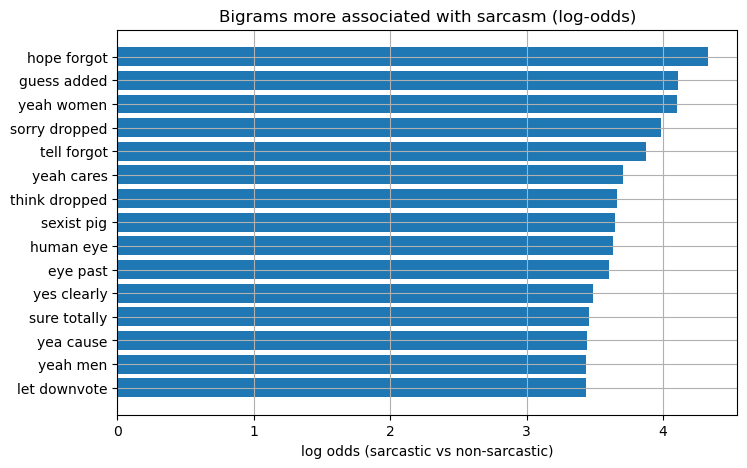

In [8]:
# =========================
# EDA: bigrams
# =========================
# We extend the token-level analysis to bigrams to identify phrase-level patterns disproportionately associated with sarcasm, which often capture cues missed by unigrams.

top_pos_bg, top_neg_bg = top_tokens_by_class(
    train_df["comment"], train_df["label"], n=15, ngram_range=(2,2), max_features=30000, min_df=10
)
display(top_pos_bg.head(10))

fig, ax = plt.subplots()
ax.barh(top_pos_bg["token"][::-1], top_pos_bg["log_odds"][::-1])
ax.set_title("Bigrams more associated with sarcasm (log-odds)")
ax.set_xlabel("log odds (sarcastic vs non-sarcastic)")
plt.show()

> We extend the token-level analysis to bigrams to identify phrase-level patterns disproportionately associated with sarcasm, which often capture cues missed by unigrams.

<details>
<summary><span style="color:red">about this block:</span></summary>  

This block repeats our **token–class association EDA**, but now at the **bigram (two-word phrase)** level instead of single words.


## Big picture: why bigrams?

Unigrams tell you **what words** matter.
Bigrams tell you **what phrases** matter.

For sarcasm especially, meaning often emerges from **combinations**, e.g.:

* “yeah right”
* “oh great”
* “sure buddy”

This section checks whether such phrases show up as strong signals.

## 1. Run the same analysis, but with bigrams

```python
top_pos_bg, top_neg_bg = top_tokens_by_class(
    train_df["comment"],
    train_df["label"],
    n=15,
    ngram_range=(2,2),
    max_features=30000,
    min_df=10
)
```

### What changed vs unigram analysis

| Parameter            | Meaning                    | Why it changed                 |
| -------------------- | -------------------------- | ------------------------------ |
| `ngram_range=(2,2)`  | **Bigrams only**           | Capture two-word phrases       |
| `n=15`               | Top 15 tokens              | Bigrams are more specific      |
| `max_features=30000` | Larger vocab cap           | Bigrams explode vocab size     |
| `min_df=10`          | Higher frequency threshold | Filters noisy, one-off phrases |

Everything else (log-odds computation, smoothing, interpretation) is **identical**.

> `ngram_range=(2,2)` extracts only adjacent two-word phrases, allowing the analysis to capture phrase-level sarcasm cues that unigrams miss.

`ngram_range=(1,1)` → unigrams only  
`ngram_range=(1,2)` → unigrams and bigrams  
`ngram_range=(2,2)` → bigrams only  


## 2. Inspect the top sarcastic bigrams

```python
display(top_pos_bg.head(10))
```

This table shows the strongest bigram signals, with:

* `token` → the two-word phrase
* `log_odds` → how strongly it favors sarcasm
* `pos_freq`, `neg_freq` → smoothed class frequencies

This is a **sanity check + discovery step**:

* Do these phrases “feel” sarcastic?
* Are they linguistically plausible?
* Do they suggest patterns worth modeling?


## 3. Visualize sarcastic-associated bigrams

```python
fig, ax = plt.subplots()
ax.barh(top_pos_bg["token"][::-1], top_pos_bg["log_odds"][::-1])
```

### Axis interpretation (same as before)

* **Y-axis** → bigram tokens (phrases)
* **X-axis** → log-odds values
* Longer bar → stronger association with sarcasm

The `[::-1]` reversal ensures:

* strongest signal appears at the top
* plot reads top → bottom naturally


```python
ax.set_title("Bigrams more associated with sarcasm (log-odds)")
ax.set_xlabel("log odds (sarcastic vs non-sarcastic)")
plt.show()
```

Adds context and renders the plot.


## What this EDA tells you

If you see phrases like:

* “yeah right”
* “oh great”
* “sure thing”

with **large positive log-odds**, that strongly suggests:

* sarcasm is expressed via **multi-word constructions**
* unigram features alone may be insufficient
* including bigrams in the final model is justified

This is exactly the kind of EDA that motivates:

```python
ngram_range=(1,2)
```

later in modeling.

</details>


**Observation.** Moving from unigrams to **bigrams** produces a noticeably cleaner signal. Unlike single words (which can be ambiguous or subreddit-specific), bigrams capture short local context; small patterns of phrasing that often carry tone. The top sarcastic-associated bigrams include constructions like *“yeah ___”*, *“sure totally”*, and other short expressions that read like **dismissal, irony, or rhetorical emphasis**, which aligns well with how sarcasm is expressed in everyday text.

Another encouraging detail is that these bigrams tend to have higher frequencies than the rarest unigrams (see the larger `pos_freq` values). That makes them more stable and less likely to be one-off artifacts, even though some phrases may still reflect specific communities or topics.

**Decision.** This supports a key modeling choice: we should include **n-grams (at least (1,2))** in our TF-IDF representation. Bigrams can encode meaningful phrase-level cues that a linear model can leverage without needing deeper context.

**Next step.** With these EDA insights in hand, we move from exploration to modeling: we’ll build a leakage-safe **TF-IDF + Logistic Regression** baseline, then tune regularization and n-gram settings systematically using cross-validation. But first, we need to convert raw comments into a feature representation that a linear model can learn from.


> **Key Takeaways**
> - Sarcasm is **not just “longer text”**: comment length overlaps heavily across classes, so we need richer lexical/phrase cues.
> - Many high-signal indicators are **phrase-level** (e.g., rhetorical constructions), which motivates trying **(1,2) n‑grams** rather than unigrams alone.
> - EDA gives us a concrete modeling hypothesis: *bigrams + sensible vocabulary filtering should help reduce sarcasm false negatives without sacrificing stability.*


<details>
<summary><span style="color:red">TF-IDF models:</span></summary>  

**TF-IDF models** represent text numerically based on a simple idea:
a word is informative if it appears frequently in a specific document but is rare across the entire corpus.

TF-IDF combines:

* **Term Frequency (TF):** how often a word appears in a document
* **Inverse Document Frequency (IDF):** how uncommon that word is across all documents

Multiplying these (TF × IDF) gives higher weight to words that are both **locally important and globally distinctive**, while down-weighting very common words.

In practice, TF-IDF turns text into sparse feature vectors that work well with linear models such as **Logistic Regression** or **Linear SVMs**. These models don’t understand language semantically, but they can effectively exploit **lexical patterns**, especially when extended to **n-grams** (e.g., bigrams like *“yeah right”*).

This makes TF-IDF a fast, interpretable, and surprisingly strong baseline for tasks like sentiment analysis or sarcasm detection; despite its limited ability to model deeper context.

</details>

## **4. Preprocessing & Feature Engineering**

Our EDA points to a clear theme: sarcasm isn’t separable by simple surface cues like length, but it *does* leave signals in **word choice** and **short phrasing**. The next step is to convert raw comments into a feature representation that a linear model can learn from without accidentally stripping away the tone.

### **Minimal vs. aggressive cleaning**

**Decision.** We keep preprocessing intentionally **lightweight**:

- **Lowercasing + basic whitespace normalization** (handled by the vectorizer)
- **Remove explicit sarcasm markers** (e.g., `/s`, `#sarcasm`) as a strict leakage safeguard
- **Avoid aggressive punctuation stripping**, since punctuation, capitalization, and informal spelling can carry pragmatic cues (emphasis, mock surprise, exaggeration)

The guiding principle is simple:  
> clean enough to reduce noise, but not so much that we erase signal.

### **Feature choices: representing text**

There are two common, high-performing choices for linear NLP baselines:

- **Bag-of-Words counts** (`CountVectorizer`) vs. **TF-IDF** (`TfidfVectorizer`)
- **Unigrams** vs. **(1,2) n-grams** (unigrams + bigrams)

**Expectation.** TF-IDF with n-grams should help because it downweights extremely common words and can capture short sarcastic constructions (as suggested by the bigram EDA).

**Next step.** Rather than testing everything at once, we start with a clean, sensible baseline (TF-IDF + unigrams), then expand the search space systematically during hyperparameter tuning.


## **5. Baseline Model**

Before we start tuning hyperparameters or comparing multiple vectorization setups, we first build a **strong, interpretable baseline**. This gives us a clear reference point: every improvement we report later should be measurable relative to this model.

### **Baseline configuration (our “starting line”)**  

- **Vectorizer:** `TfidfVectorizer` with **unigrams**  
  *(a high-quality default for text classification: sparse, efficient, and robust)*  


- **Classifier:** `LogisticRegression` with **L2 regularization** (`solver="saga"`, `C=1.0`)  
  *(fast, stable on large sparse text features, and easy to interpret via coefficients)*

### **What we expect**  

**Hypothesis.** Even this simple setup should already be competitive on a dataset of this size. More importantly, it should produce a sensible, explainable signal: the learned weights act as a transparent window into which terms push predictions toward **sarcasm** vs **non-sarcasm**.

### **How we evaluate (and why)**  

**Decision.** We evaluate in two complementary ways:

1) **Cross-validation on the training split (5-fold, stratified).**  
   This gives us a robust estimate of generalization *without touching the test set*.  
   We report **F1**, **ROC AUC**, and **PR AUC (Average Precision)** to capture both threshold-based performance (F1) and ranking quality (ROC/PR).

2) **Out-of-fold predictions.**  
   Using `cross_val_predict`, we generate predictions for every training example as if it were “unseen,” allowing us to inspect a realistic **confusion matrix** and error profile.

Only after this sanity check do we fit the baseline on the full training set and evaluate once on the **held-out test set**, which remains our final, unbiased report card.


Baseline CV performance (mean ± std):
             f1: 0.6796 ± 0.0009
        roc_auc: 0.7579 ± 0.0004
  avg_precision: 0.7645 ± 0.0008

Classification report (out-of-fold predictions):
              precision    recall  f1-score   support

           0     0.6782    0.7293    0.7028    404322
           1     0.7072    0.6540    0.6796    404294

    accuracy                         0.6916    808616
   macro avg     0.6927    0.6916    0.6912    808616
weighted avg     0.6927    0.6916    0.6912    808616



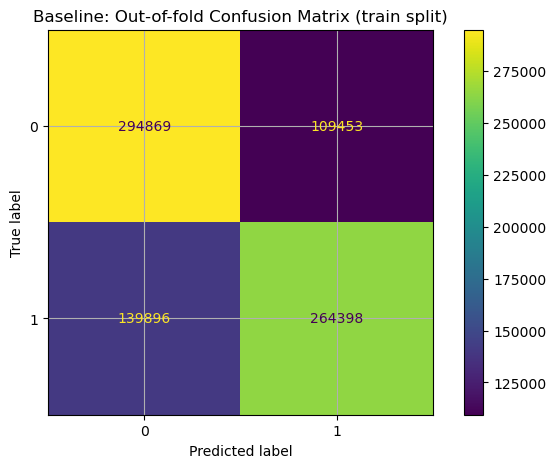

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

baseline_pipe = Pipeline(
    steps=[
        ("vect", TfidfVectorizer(
            ngram_range=(1, 1),
            min_df=2,
            max_features=50000,
            strip_accents="unicode",
        )),
        ("clf", LogisticRegression(
            solver="saga",
            penalty="l2",
            C=1.0,
            max_iter=2000,
            n_jobs=1,
            random_state=RANDOM_STATE,
        )),
    ]
)

scoring = {
    "f1": "f1",
    "roc_auc": "roc_auc",
    "avg_precision": "average_precision",
}

cv_results = cross_validate(
    baseline_pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)

print("Baseline CV performance (mean ± std):")
for k, v in cv_results.items():
    if k.startswith("test_"):
        metric = k.replace("test_", "")
        print(f"  {metric:>13}: {np.mean(v):.4f} ± {np.std(v):.4f}")

# Out-of-fold predictions for a confusion matrix style check
oof_proba = cross_val_predict(baseline_pipe, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
oof_pred = (oof_proba >= 0.5).astype(int)

print("\nClassification report (out-of-fold predictions):")
print(classification_report(y_train, oof_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_train, oof_pred, display_labels=[0, 1])
plt.title("Baseline: Out-of-fold Confusion Matrix (train split)")
plt.show()


<details>
<summary><span style="color:red">about this block:</span></summary>   

This block builds a **baseline text classifier**, evaluates it with **stratified 5-fold cross-validation**, reports **F1 / ROC AUC / PR AUC**, and then creates **out-of-fold (OOF)** predictions to print a classification report and confusion matrix that are *not* biased by training-on-the-same-examples.

Below is what each part is doing.

## 1) Define cross-validation strategy

```python
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
```

* **5 folds**: split the training set into 5 parts.
* **Stratified**: each fold keeps roughly the same class proportions as the full dataset.
* **shuffle=True**: randomizes before splitting (helps avoid ordering artifacts).
* `random_state` makes the split reproducible.


## 2) Build a baseline pipeline (TF-IDF → Logistic Regression)

```python
baseline_pipe = Pipeline(steps=[("vect", TfidfVectorizer(...)), ("clf", LogisticRegression(...))])
```

### `TfidfVectorizer(...)`

Turns raw text into a numeric matrix of TF-IDF features.

Key params:

* `ngram_range=(1,1)`: unigrams only (single words).
* `min_df=2`: drop tokens that appear in fewer than 2 documents (reduces noise).
* `max_features=50000`: keep up to 50k features (cap memory).
* `strip_accents="unicode"`: normalizes accented characters (e.g., “café” → “cafe”).

Output is a **sparse matrix** with shape roughly:
$$
(n_{samples}, n_{features})
$$

### `LogisticRegression(...)`

A strong baseline for text classification with TF-IDF.

Key params:

* `solver="saga"`: works well for large sparse data and supports different penalties.
* `penalty="l2"`: L2 regularization (default, stable).
* `C=1.0`: inverse regularization strength

  * higher `C` → less regularization
  * lower `C` → more regularization
* `max_iter=2000`: more iterations to ensure convergence.
* `n_jobs=1`: internal parallelism for the solver (we parallelize CV outside).
* `random_state`: reproducibility.


## 3) Choose evaluation metrics

```python
scoring = {"f1": "f1", "roc_auc": "roc_auc", "avg_precision": "average_precision"}
```

* **f1**: thresholded metric at the default decision rule.
* **roc_auc**: ranking quality across thresholds.
* **average_precision**: PR AUC summary (scikit calls it “average_precision”).


## 4) Run cross-validation and report mean ± std

```python
cv_results = cross_validate(baseline_pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
```

What happens internally (for each fold):

1. Fit TF-IDF + logistic regression on 4 folds
2. Evaluate on the held-out fold
3. Store test scores for each metric

`n_jobs=-1` uses all CPU cores to run folds in parallel.

Then:

```python
for k, v in cv_results.items():
    if k.startswith("test_"):
        print(mean ± std)
```

* Prints **average performance** and **variability across folds**.
* Std tells you how stable performance is across splits.

> `cv_results` maps each metric name to an array of per-fold scores, and iterating over `.items()` lets us summarize cross-validation performance as mean ± standard deviation. 


<details>
<summary><span style="color:red">

What `cv_results` looks like:

</span></summary>  


`cross_validate` returns a **dictionary** where each key maps to an array of values (one per CV fold).


## What `cv_results` looks like

given: 

```python
cv_results = cross_validate(
    baseline_pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)
```

`cv_results` will look like this:

```python
{
    'fit_time': array([1.82, 1.79, 1.85, 1.80, 1.83]),
    'score_time': array([0.21, 0.20, 0.22, 0.21, 0.20]),

    'test_f1': array([0.7041, 0.7093, 0.7018, 0.7076, 0.7059]),
    'test_roc_auc': array([0.7842, 0.7901, 0.7815, 0.7889, 0.7863]),
    'test_avg_precision': array([0.7987, 0.8049, 0.7961, 0.8018, 0.7995]),
}
```

(Values above are illustrative, but the **shape and keys** are accurate.)


## What `.items()` returns

```python
cv_results.items()
```

Returns an iterable of `(key, value)` pairs:

```python
('fit_time', array([...]))
('score_time', array([...]))
('test_f1', array([...]))
('test_roc_auc', array([...]))
('test_avg_precision', array([...]))
```

So in our loop:

```python
for k, v in cv_results.items():
```

* `k` is a **string key**
* `v` is a **NumPy array of length = n_splits (5)**


## Why we check `k.startswith("test_")`

We only want **evaluation metrics**, not timing info.

So this filters out:

* `'fit_time'`
* `'score_time'`

And keeps:

* `'test_f1'`
* `'test_roc_auc'`
* `'test_avg_precision'`


## What `v` is for those keys

For example:

```python
v = cv_results["test_f1"]
```

might be:

```python
array([0.7041, 0.7093, 0.7018, 0.7076, 0.7059])
```

Each number is the score on **one fold’s validation split**.


## Why we print mean ± std

```python
np.mean(v)  # average performance across folds
np.std(v)   # variability across folds
```

This tells you:

* how good the model is on average
* how stable it is across different data splits

Low std = consistent performance
High std = sensitive to split


> `cv_results` maps each metric name to an array of per-fold scores, and iterating over `.items()` lets us summarize cross-validation performance as mean ± standard deviation.


</details>

## 5) Create out-of-fold (OOF) predictions for confusion matrix

```python
oof_proba = cross_val_predict(..., method="predict_proba")[:, 1]
```

<details>
<summary><span style="color:red">More on this:</span></summary>  

`oof_proba` is a **1-D NumPy array** with **one probability per training example**.

### Shape

```python
oof_proba.shape
# (n_train_samples,)
```

In our case:

```python
oof_proba.shape
# (808616,)
```


### Why that’s the shape

* `cross_val_predict(..., method="predict_proba")` returns an array of shape:

  ```python
  (n_train_samples, n_classes)
  ```

  For binary classification:

  ```python
  (808616, 2)
  ```

* The slice `[:, 1]` selects the probability of **class 1** (sarcastic):

  ```python
  oof_proba = probs[:, 1]
  ```

  which collapses it to:

  ```python
  (808616,)
  ```


### What each element means

```python
oof_proba[i]
```

= the **out-of-fold predicted probability** that training example `i` belongs to class `1`, produced by a model that **did not train on example `i`**.


### Quick summary

* Before slicing: `(n_samples, 2)`
* After `[:, 1]`: `(n_samples,)`
* One probability per training point
* Safe for thresholding, PR curves, calibration, etc.

This shape is exactly what we want for:

```python
oof_pred = (oof_proba >= 0.5).astype(int)
```
</details>




**Out-of-fold prediction** means:

* For each training example, its prediction comes from a model that **did not train on that example**.
* This is closer to “how the model behaves on unseen data” than fitting once and predicting on the same training set.

`[:, 1]` takes the probability of class **1 (sarcastic)**.


## 6) Convert probabilities to class predictions using a threshold

```python
oof_pred = (oof_proba >= 0.5).astype(int)
```

* Uses **0.5** as the decision threshold.
* If you later tune thresholds, F1/confusion matrix can improve depending on trade-offs.


## 7) Print classification report

```python
print(classification_report(y_train, oof_pred, digits=4))
```

Shows (per class and overall):

* precision
* recall
* F1
* support (counts)

Because these are OOF predictions, it’s a fairer “train-split diagnostic”.


## 8) Plot confusion matrix

```python
ConfusionMatrixDisplay.from_predictions(y_train, oof_pred, display_labels=[0, 1])
```

Gives counts of:

* **TN**: true non-sarcastic predicted non-sarcastic
* **FP**: non-sarcastic predicted sarcastic
* **FN**: sarcastic predicted non-sarcastic
* **TP**: true sarcastic predicted sarcastic

This helps us see *what kind of errors* the baseline is making.


### Why this whole block is a strong baseline workflow

* Pipeline prevents leakage (vectorizer is fit inside each fold)
* Stratified CV makes folds comparable
* Multiple metrics give a rounded view
* OOF confusion matrix avoids “training-set optimism”

</details>


<details>
<summary><span style="color:red">about the classification report:</span></summary>  


## Rows: *what each row represents*

### **Class rows (`0` and `1`)**

These rows correspond to the **actual classes**:

| Row | Meaning                |
| --- | ---------------------- |
| `0` | Non-sarcastic comments |
| `1` | Sarcastic comments     |

Each row summarizes performance **for that class treated as “positive”**.


### **`accuracy` row**

* Overall correctness across **all samples**
* Not class-specific

### **`macro avg` row**

* Simple **unweighted average** of the per-class metrics
* Treats both classes **equally**, regardless of support


### **`weighted avg` row**

* Average of per-class metrics **weighted by support**
* Heavily influenced by larger classes
* With balanced classes, this ≈ macro avg


## Columns: *what each column means*

### **precision**

$$
\text{precision} = \frac{TP}{TP + FP}
$$

> Of everything predicted **as this class**, how many were correct?

* Class `1` precision $0.7072$:

  * When the model predicts *sarcasm*, ~71% of the time it’s right


### **recall**

$$
\text{recall} = \frac{TP}{TP + FN}
$$

> Of everything that **actually is this class**, how many did we catch?

* Class `1` recall $0.6540$:

  * The model finds ~65% of sarcastic comments
  * ~35% are missed (false negatives)


### **f1-score**

$$
\text{F1} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$

> Balance between precision and recall for that class

* Class `1` F1 ≈ 0.68:

  * Reasonable trade-off, but recall is the limiting factor

### **support**

* Number of **true samples** of that class
* Comes from the ground truth, not predictions

Here:

```text
support(0) = 404,322
support(1) = 404,294
```

→ Classes are **almost perfectly balanced**


## How to read this report *holistically*

### Key observations

1. **Balanced data**

   * Supports are nearly identical
   * Accuracy, macro avg, and weighted avg align closely

2. **Asymmetry in errors**

   * Class 0 (non-sarcastic):

     * Higher recall (0.7293)
   * Class 1 (sarcastic):

     * Lower recall (0.6540)
   * Model is slightly conservative about predicting sarcasm

3. **Accuracy vs F1**

   * Accuracy ≈ 0.69
   * F1 ≈ 0.69
   * With balanced classes, these numbers tend to match


> The model achieves balanced performance across classes, with slightly lower recall for sarcasm, indicating a conservative bias toward sarcastic predictions (i.e., the model over-predicts `non-sarcasm`).


## What “conservative” means here

A model is **conservative about predicting sarcasm** if:

* it requires stronger evidence to say “sarcastic”
* it often defaults to predicting **non-sarcastic**

That leads to:

* fewer sarcasm predictions overall
* lower recall for sarcasm
* higher recall for non-sarcasm (which we see: 0.7293)


> ❌ *“conservative bias toward sarcastic predictions”*

That would imply:

* the model **over-predicts sarcasm**
* high sarcasm recall
* low non-sarcasm recall

But the opposite is happening.  

## Correct interpretation (with logic)

* Lower recall for sarcasm
  ⟹ model misses sarcastic cases
  ⟹ model hesitates to label sarcasm
  ⟹ **bias toward non-sarcastic predictions**


> *The model achieves balanced performance across classes, with slightly lower recall for sarcasm, indicating a conservative bias toward sarcastic predictions.*


> **Lower recall for a class means the model is conservative about predicting that class.**

</details>

<details>
<summary><span style="color:red">More on F1, accuracy, macro avg, and weighted avg metrics:</span></summary>

We’ll inspect:

1. **Formulas** 
2. **What macro avg and weighted avg mean mathematically**
3. **Why these metrics collapse to similar values when classes are balanced**


## 1️⃣ Accuracy

### Definition

Accuracy is the fraction of **correct predictions overall**.

$$
\boxed{
\text{Accuracy}
= \frac{TP + TN}{TP + TN + FP + FN}
}
$$

Where:

* **TP** = true positives (sarcastic → sarcastic)
* **TN** = true negatives (non-sarcastic → non-sarcastic)
* **FP** = false positives
* **FN** = false negatives

🔹 Accuracy treats **both classes symmetrically** and ignores *how* errors are distributed.


## 2️⃣ Per-class F1 score (recap)

For class $k$:

$$
\text{Precision}_k = \frac{TP_k}{TP_k + FP_k}
\quad
\text{Recall}_k = \frac{TP_k}{TP_k + FN_k}
$$

$$
\boxed{
\text{F1}_k
= 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}
{\text{Precision}_k + \text{Recall}_k}
}
$$


## 3️⃣ Macro average

### Definition

Macro avg is the **simple average across classes**, treating each class equally.

For $K$ classes:

$$
\boxed{
\text{Macro-F1}
= \frac{1}{K} \sum_{k=1}^{K} \text{F1}_k
}
$$

For our **binary case**:

$$
\text{Macro-F1}
= \frac{\text{F1}_0 + \text{F1}_1}{2}
$$

🔹 **Key property**: ignores class sizes completely.


## 4️⃣ Weighted average

### Definition

Weighted avg is a **support-weighted average** of per-class scores.

Let:

* $N_k$ = support (number of true samples) of class $k$
* $N = \sum_k N_k$

$$
\boxed{
\text{Weighted-F1}
= \sum_{k=1}^{K} \frac{N_k}{N} \cdot \text{F1}_k
}
$$

So in binary classification:

$$
\text{Weighted-F1}
= \frac{N_0}{N}\text{F1}_0 + \frac{N_1}{N}\text{F1}_1
$$


## 5️⃣ Why these metrics become **very close** when classes are balanced

Now the key insight.

### When classes are balanced:

$$
N_0 \approx N_1
\Rightarrow
\frac{N_0}{N} \approx \frac{N_1}{N} \approx 0.5
$$

### That means:

$$
\text{Weighted-F1}
\approx 0.5 \cdot \text{F1}_0 + 0.5 \cdot \text{F1}_1
= \text{Macro-F1}
$$

So **macro avg ≈ weighted avg**.


## 6️⃣ Why F1 and accuracy also get close (important intuition)

With:

* balanced classes
* roughly symmetric errors
* no extreme precision–recall imbalance

Then:

* Accuracy ≈ average recall
* Per-class precision ≈ per-class recall
* F1 ≈ recall ≈ accuracy

<details>
<summary><span style="color:red">more on this:</span></summary>   


## Setup (binary, balanced case)

Let:

* Total samples: $N$
* Balanced classes:
  $$
  N_0 = N_1 = \frac{N}{2}
  $$

Confusion matrix:

|        | Pred 0 | Pred 1 |
| ------ | ------ | ------ |
| True 0 | TN     | FP     |
| True 1 | FN     | TP     |


## 1️⃣ Accuracy ≈ average recall

### Accuracy (definition)

$$
\text{Accuracy}
= \frac{TP + TN}{N}
$$

Rewrite using class sizes:

$$
\text{Accuracy}
= \frac{TP}{N_1} \cdot \frac{N_1}{N}

* \frac{TN}{N_0} \cdot \frac{N_0}{N}
  $$

But:

$$
\frac{TP}{N_1} = \text{Recall}_1,
\quad
\frac{TN}{N_0} = \text{Recall}_0
$$

So:

$$
\text{Accuracy}
= \frac{N_1}{N} \text{Recall}_1

* \frac{N_0}{N} \text{Recall}_0
  $$

With balanced classes $N_0 = N_1 = \frac{N}{2}$:

$$
\boxed{
\text{Accuracy}
= \frac{\text{Recall}_0 + \text{Recall}_1}{2}
}
$$

👉 **Accuracy equals macro-average recall exactly** in the balanced case.


## 2️⃣ Per-class precision ≈ per-class recall (balanced + symmetric errors)

### Recall (class 1)

$$
\text{Recall}_1 = \frac{TP}{TP + FN}
$$

### Precision (class 1)

$$
\text{Precision}_1 = \frac{TP}{TP + FP}
$$

If the model is **not biased toward one class**, then:

$$
FP \approx FN
$$

This is exactly what happens when:

* classes are balanced
* prediction rates are similar across classes

So:

$$
TP + FN \approx TP + FP
\Rightarrow
\boxed{
\text{Precision}_1 \approx \text{Recall}_1
}
$$

Same logic applies to class 0.


## 3️⃣ F1 ≈ recall (when precision ≈ recall)

F1 definition:

$$
\text{F1}
= 2 \cdot \frac{PR}{P + R}
$$

If $P \approx R$:

$$
\text{F1}
\approx 2 \cdot \frac{R^2}{2R}
= R
$$

$$
\boxed{
\text{F1} \approx \text{Recall}
}
$$


## 4️⃣ Putting it all together (balanced classes)

From above:

1.

$$
\text{Accuracy}
= \frac{\text{Recall}_0 + \text{Recall}_1}{2}
$$

2.

$$
\text{Precision}_k \approx \text{Recall}_k
$$

3.

$$
\text{F1}_k \approx \text{Recall}_k
$$

Therefore:

$$
\boxed{
\text{F1} \approx \text{Recall} \approx \text{Accuracy}
}
$$

## 5️⃣ Why this matches our report numerically

From our results:

* Supports are almost exactly equal
* Recalls differ only slightly
* FP ≈ FN

So all assumptions hold approximately — hence:

```text
Accuracy ≈ Macro F1 ≈ Weighted F1 ≈ Class-wise F1
```

## Important caveat (worth remembering)

These equalities **break immediately** if:

* classes are imbalanced
* model favors one class
* FP ≠ FN by a lot
* threshold is extreme

That’s why accuracy becomes misleading in imbalanced problems.

<span style="font-size:24px; color:hotpink;">  

In balanced binary classification with roughly symmetric errors, accuracy equals average recall, precision approaches recall, and F1 collapses to the same value, explaining why all metrics converge numerically.

</span>

</details>

In our report:

* class supports are almost identical
* recalls are not wildly different
* errors are fairly symmetric

So all of these converge numerically.


## 7️⃣ What would break this similarity?

They **diverge** when:

* classes are imbalanced
* one class has very low recall
* model predicts one class much more often
* costs are asymmetric

Example:

* 95% non-sarcastic
* always predict non-sarcastic
* Accuracy ≈ 95%
* F1(sarcasm) ≈ 0
* Macro avg ≪ Accuracy

<span style="font-size:24px; color:hotpink;"> 

Accuracy measures overall correctness, while macro and weighted averages aggregate per-class F1 scores. When classes are balanced, the weighted average reduces to the macro average, and if errors are roughly symmetric, F1, accuracy, macro avg, and weighted avg converge to similar values. This explains why all four metrics are close in the balanced setting observed here. 

</span> 

</details>

**Result (cross-validated baseline).** Even with a simple TF-IDF unigram representation, the baseline is already meaningfully predictive. Across 5 stratified folds, performance is extremely stable (tiny standard deviations), which suggests the model is learning consistent, repeatable patterns rather than benefiting from a lucky split.

- **F1 ≈ 0.68** indicates a solid balance between precision and recall at the default 0.5 threshold.
- **ROC AUC ≈ 0.76** and **PR AUC ≈ 0.76** indicate good ranking quality: sarcastic comments tend to receive higher scores than non-sarcastic ones across a range of thresholds.

**Observation.** The out-of-fold classification report shows a mild asymmetry:
- **Non-sarcasm (0)** has higher recall (~0.73), meaning the model is slightly better at correctly identifying non-sarcastic comments.
- **Sarcasm (1)** has lower recall (~0.65), meaning the model misses a meaningful portion of sarcastic comments (false negatives).

The confusion matrix reinforces this: sarcasm is harder to catch reliably with text-only signals, which is expected given that sarcasm often depends on context beyond the comment itself.

**Decision.** Before tuning, we run one additional sanity check: fit the baseline on the full training set and evaluate it once on the **held-out test set**. This gives us an unbiased “baseline report card,” including a test confusion matrix plus **ROC** and **Precision–Recall** curves for threshold-sensitive evaluation.


Baseline Test ROC AUC: 0.7604813202731194
Baseline Test PR AUC: 0.766808523349938

Baseline Test report:
              precision    recall  f1-score   support

           0     0.6798    0.7304    0.7042    101081
           1     0.7087    0.6559    0.6813    101074

    accuracy                         0.6932    202155
   macro avg     0.6942    0.6932    0.6927    202155
weighted avg     0.6942    0.6932    0.6927    202155



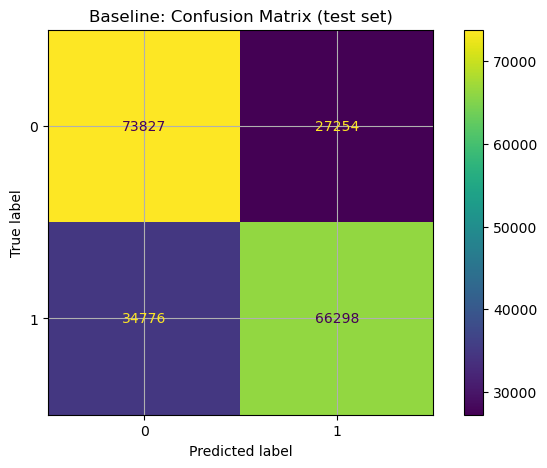

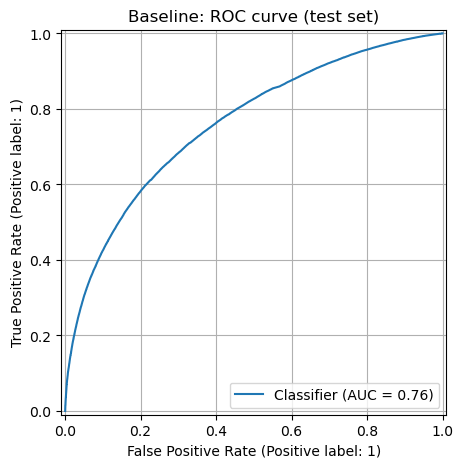

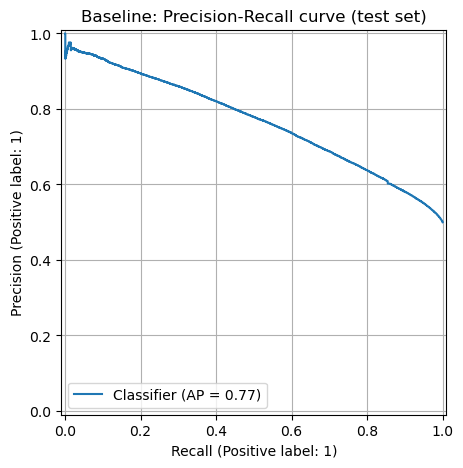

In [10]:
# Fit baseline on full training data and evaluate on the held-out test set
baseline_pipe.fit(X_train, y_train)
test_proba = baseline_pipe.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

print("Baseline Test ROC AUC:", roc_auc_score(y_test, test_proba))
print("Baseline Test PR AUC:", average_precision_score(y_test, test_proba))
print("\nBaseline Test report:")
print(classification_report(y_test, test_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=[0, 1])
plt.title("Baseline: Confusion Matrix (test set)")
plt.show()

RocCurveDisplay.from_predictions(y_test, test_proba)
plt.title("Baseline: ROC curve (test set)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, test_proba)
plt.title("Baseline: Precision-Recall curve (test set)")
plt.show()

<details>
<summary><span style="color:red">about this block:</span></summary>

This block takes our **baseline pipeline** (TF-IDF + logistic regression), trains it once on **all training data**, then evaluates it on the **held-out test set** and produces: metrics, a classification report, a confusion matrix, and ROC/PR curves.


## 1) Train the baseline on the full training split

```python
baseline_pipe.fit(X_train, y_train)
```

Because `baseline_pipe` is a `Pipeline`, this does both steps in order:

1. `TfidfVectorizer.fit_transform(X_train)`
   → learns the vocabulary + document frequencies + IDF weights and transforms text into TF-IDF features

2. `LogisticRegression.fit(...)`
   → fits the classifier on those features and labels


<details>
<summary><span style="color:red">

Are the IDF weights learned by the `TfidfVectorizer` the same as the weights (coefficients) learned by the `LogisticRegression` model at the end of training?:

</span></summary>

Short answer: **no! they are completely different things**, learned at **different stages**, with **different meanings**.

<span style="font-size:24px; color:hotpink;">  

IDF weights are learned by the `TfidfVectorizer` to rescale features based on corpus-wide rarity, while logistic regression weights are learned later to associate those features with the target labels. They play different roles and are multiplied together in the final model. 

</span>

> **IDF decides how much a word matters; logistic regression decides what it means.**

## Two different models are being trained inside the pipeline

Our pipeline has **two learning steps**:

```
Text  →  TF-IDF Vectorizer  →  Logistic Regression
```

Each step learns its **own parameters**.


## 1️⃣ IDF weights (from `TfidfVectorizer`)

### What they are

IDF (Inverse Document Frequency) weights are part of the **feature construction**, not the classifier.

For each token $t$:

$$
\text{IDF}(t) = \log \frac{N + 1}{\text{df}(t) + 1} + 1
$$

Where:

* $N$ = number of documents
* $\text{df}(t)$ = number of documents containing token $t$

### What IDF means

> “How *informative* is this word across the corpus?”

* Common words → **low IDF**
* Rare words → **high IDF**

IDF is:

* **unsupervised**
* depends **only on text statistics**
* does **not use labels**

### Where IDF lives

* Stored inside `TfidfVectorizer`
* Fixed **before** logistic regression sees the data
* Same for all classes


## 2️⃣ Logistic Regression weights (coefficients)

### What they are

These are the **model parameters** that actually do classification.

For each feature (token):

$$
\hat{y} = \sigma\left( \sum_j w_j x_j + b \right)
$$

Where:

* $x_j$ = TF-IDF value of token $j$
* $w_j$ = logistic regression coefficient for token $j$

### What LR weights mean

> “Given this TF-IDF feature, does it push the prediction toward sarcasm or non-sarcasm?”

* Positive $w_j$ → pushes toward sarcasm
* Negative $w_j$ → pushes toward non-sarcasm
* Magnitude → strength of influence

These are:

* **supervised**
* learned using **labels**
* optimized to minimize classification loss

## 3️⃣ How they interact (this is the key insight)

The final decision uses **both**, multiplicatively:

$$
\text{contribution of token } t
=

(\text{TF} \times \text{IDF})_t
\times
w_t
$$

So:

* IDF controls **how much the word counts at all**
* LR coefficient controls **which class it supports**

They are **not the same weights**, and they do **not replace each other**.


## 4️⃣ Why this separation is intentional

This design:

* stabilizes learning
* reduces dominance of very common words
* lets the classifier focus on *discriminative direction*, not raw frequency

It’s one reason TF-IDF + logistic regression is such a strong baseline.


## 5️⃣ Concrete example

Suppose:

| Token      | IDF | LR weight |
| ---------- | --: | --------: |
| “the”      | 0.2 |     +0.01 |
| “yeah”     | 3.1 |      +0.8 |
| “oh great” | 4.5 |      +1.2 |

* “the” barely matters (low IDF, tiny weight)
* “yeah” matters a lot and pushes toward sarcasm
* “oh great” matters **a lot** and pushes strongly

<details>
<summary><span style="color:red">Precise definition of "model":</span></summary>

We used **“model”** in a **very broad, informal ML sense**, but **strictly speaking**,
`TfidfVectorizer` is **not a predictive model**.

It is a **learned transformation** (a feature extractor).

## Precise terminology (this matters)

### What *is* a “model” in the strict sense?

A model:

* maps inputs → outputs **using learned parameters**
* is trained to **optimize a task objective**
* uses **labels** (in supervised settings)

👉 **LogisticRegression** is a model.


### What `TfidfVectorizer` actually is

`TfidfVectorizer` is:

* a **feature extraction / representation model**
* an **unsupervised estimator**
* a **data-dependent transformation**

It *does* “learn” parameters:

* vocabulary
* document frequencies
* IDF weights

But:

* it does **not** optimize for prediction
* it does **not** use labels
* it does **not** produce class outputs

So it’s more accurate to call it:

> a **learned text representation** or **vectorizer**


## Why people still casually say “model”

In ML practice, people often use “model” loosely to mean:

> *any component with learned parameters*

By that definition:

* PCA
* TF-IDF
* StandardScaler

are sometimes called “models” but this is **imprecise**.


## Best wording (what you should use)

Instead of:

> “TF-IDF model”

Prefer:

* **TF-IDF vectorizer**
* **feature extractor**
* **learned text representation**
* **unsupervised transformation**

And reserve **“model”** for:

* logistic regression
* SVM
* neural networks


## Clean corrected phrasing (pipeline description)

> The pipeline first learns a TF-IDF representation of the text (vocabulary and IDF weights), then trains a logistic regression classifier on those features.


<span style="font-size:24px; color:hotpink;">  

`TfidfVectorizer` learns parameters, but it is a **feature transformation**, not a predictive model.

</span>

</details>

</details>



## 2) Get predicted probabilities on the test set

```python
test_proba = baseline_pipe.predict_proba(X_test)[:, 1]
```

* `predict_proba(X_test)` returns shape `(n_test_samples, 2)` for binary classification:

  * column 0 = probability of class 0
  * column 1 = probability of class 1
* `[:, 1]` selects **P(y=1 | x)** (sarcastic probability) for each test example

So `test_proba` is a 1-D array of length `len(X_test)`.


## 3) Convert probabilities to hard class labels (threshold = 0.5)

```python
test_pred = (test_proba >= 0.5).astype(int)
```

* If probability ≥ 0.5 → predict class 1
* Else → predict class 0

This is one **operating point**; you could change 0.5 if you want higher recall or higher precision.

## 4) Compute threshold-independent metrics (use probabilities)

```python
roc_auc_score(y_test, test_proba)
average_precision_score(y_test, test_proba)
```

### ROC AUC

* Uses `test_proba` rankings across thresholds
* “How well does the model rank positives above negatives?”

### PR AUC (Average Precision)

* Also uses probabilities across thresholds
* Focuses on precision–recall tradeoff for the positive class

These are computed using the probability scores, not the 0.5 labels.

## 5) Classification report (uses thresholded predictions)

```python
print(classification_report(y_test, test_pred, digits=4))
```

This prints precision/recall/F1/support for each class **at the 0.5 threshold**.

So:

* ROC AUC / PR AUC → threshold-free, based on `test_proba`
* Report → thresholded, based on `test_pred`


## 6) Confusion matrix on the test set

```python
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=[0, 1])
```

Shows the counts of:

* TN, FP, FN, TP

This is the most concrete view of *what kinds of mistakes* happen at threshold 0.5.


## 7) Plot ROC curve (test set)

```python
RocCurveDisplay.from_predictions(y_test, test_proba)
```

Plots TPR vs FPR across thresholds and shows the ROC AUC.


## 8) Plot Precision–Recall curve (test set)

```python
PrecisionRecallDisplay.from_predictions(y_test, test_proba)
```

Plots precision vs recall across thresholds and summarizes with AP (PR AUC).


## Why this evaluation setup is “clean”

* Model is trained only on `X_train`
* Test set `X_test` is untouched until final evaluation
* We report both:

  * **ranking metrics** (ROC/PR AUC)
  * **operating-point metrics** (classification report + confusion matrix)

</details>

<details>
<summary><span style="color:red">More on these curves:</span></summary>  

## ROC curve: 

## What it shows (quick recap)

* **X-axis:** False Positive Rate (FPR)
  $$
  \text{FPR} = \frac{FP}{FP + TN}
  $$

* **Y-axis:** True Positive Rate (TPR / Recall)
  $$
  \text{TPR} = \frac{TP}{TP + FN}
  $$

Each point on the curve corresponds to a **different decision threshold** on the model’s predicted probabilities.



## What the diagonal line means

The diagonal line from $(0,0)$ to $(1,1)$ represents a **random classifier**.

Why?

At any threshold, a random model:

* flags positives and negatives at the same rate
* so:
  $$
  \text{TPR} = \text{FPR}
  $$

In words:

> You catch true positives at the same rate you make false positives.

That’s *no discrimination power*.


## Why being **above the diagonal** is a good sign

When the ROC curve lies **above** the diagonal, it means:

$$
\text{TPR} > \text{FPR}
$$

at many thresholds.

### Interpretation in plain English

> For a wide range of thresholds, the model identifies **true positives faster than it accumulates false positives**.

Or even more intuitively:

> The model tends to give **higher scores to positive examples than to negative ones**.

This is exactly what we want from a classifier.


## Ranking interpretation (most important insight)

ROC curves are really about **ranking**, not thresholds.

Being above the diagonal means:

$$
P(\text{score}(x^+) > \text{score}(x^-)) > 0.5
$$

That is:

> If you randomly pick one positive and one negative example, the model is **more likely than chance** to rank the positive higher.

Our reported:

```
AUC = 0.76
```

means:

> **76% of the time**, a random positive example is ranked above a random negative example.

That’s a strong, intuitive signal.


## Why the *shape* matters

Looking at our curve:

* It rises **steeply near the origin**
* We get a large TPR for a small FPR

This is especially good because it means:

* we can catch many positives
* while making relatively few false alarms

That’s a sign of **useful separation** between classes.


## What would be bad signs

* Curve close to the diagonal → weak model
* Curve *below* the diagonal → model is systematically wrong
  (you could flip its predictions and do better)
* AUC ≈ 0.5 → random guessing


<span style="font-size:24px; color:hotpink;">  

A ROC curve above the diagonal shows that the model distinguishes positives from negatives better than chance, achieving higher true-positive rates than false-positive rates across thresholds.

</span>


## Precision–Recall (PR) curve:   

It answers a *different* (often more practical) question than the ROC curve.

## What this plot shows

* **X-axis:** **Recall** (TPR)
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

* **Y-axis:** **Precision**
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

Each point corresponds to a **different probability threshold**, just like ROC but the focus is now **positive-class quality**.


## What the baseline is for PR curves (very important)

Unlike ROC curves, the PR baseline is **not a diagonal**.

### Baseline precision

The baseline is the **prevalence of the positive class**:

$$
\text{Baseline Precision} = \frac{\#\text{positives}}{\#\text{total samples}}
$$

In our case (balanced classes):
$$
\text{Baseline} \approx 0.5
$$

So:

* A random classifier would be a **horizontal line at precision ≈ 0.5**
* Any curve **above that line** is doing better than chance


## Why this curve is a good sign

### 1️⃣ It stays well above baseline

Our curve:

* starts near **precision ≈ 1.0** at low recall
* ends around **precision ≈ 0.5** at recall → 1

This means:

> Even as we retrieve more sarcastic comments, precision stays meaningfully above chance for most thresholds.

That’s exactly what we want.


### 2️⃣ Interpretation of **AP = 0.77**

Our legend shows:

```
AP = 0.77
```

**Average Precision (AP)** is the area under the PR curve.

Interpretation:

> Across recall levels, the model maintains **high precision on average** when predicting sarcasm.

Since the baseline is ≈ 0.5, an AP of 0.77 is **strong**.


### 3️⃣ Why the curve slopes downward (this is normal)

As recall increases:

* the model must lower its threshold
* it includes more borderline cases
* false positives increase

So:

* **Recall ↑ → Precision ↓**

This trade-off is unavoidable; the question is *how fast* precision drops.

In our curve:

* the drop is **gradual**, not abrupt → good separation


## How this complements the ROC curve

* **ROC curve:**
  “How well does the model rank positives above negatives *overall*?”

* **PR curve:**
  “When I predict sarcasm, **how often am I right** as I try to catch more of it?”

PR is often more informative when:

* the positive class matters most
* false positives are costly
* you care about operating points

<span style="font-size:24px; color:hotpink;">  

A PR curve that stays well above the baseline and yields a high AP indicates that the model can recover sarcastic comments while keeping false positives relatively low across thresholds.

</span>


## Linking this back to our earlier results

* ROC AUC ≈ **0.76** → good ranking ability
* PR AUC (AP) ≈ **0.77** → strong positive-class precision
* Classification report → slightly conservative about predicting sarcasm

</details>

**Result (held-out test set).** The baseline generalizes almost exactly as the cross-validation estimates suggested. On the test set we obtain **ROC AUC ≈ 0.760** and **PR AUC ≈ 0.767**, which confirms that the model’s ranking quality is stable and not an artifact of cross-validation.

At the default 0.5 threshold, overall accuracy is **≈ 0.693**, with a familiar class-wise pattern:
- For **non-sarcasm (0)**, recall is higher (**≈ 0.73**), meaning the model is relatively good at recognizing straightforward, literal comments.
- For **sarcasm (1)**, recall is lower (**≈ 0.66**), meaning a noticeable fraction of sarcastic comments are still being missed (false negatives).

The confusion matrix makes this concrete: the model produces a substantial number of **false negatives for sarcasm** (sarcastic comments predicted as non-sarcastic), which is a realistic limitation of text-only sarcasm detection; many sarcastic statements are linguistically subtle and require external context or shared knowledge to interpret correctly.

**Interpretation of the curves.**
- The **ROC curve** sits well above the diagonal, indicating meaningful separation between the classes across thresholds.
- The **Precision–Recall curve** shows strong precision at lower recall and gradually declines as we push toward capturing more sarcasm. This highlights a practical tradeoff: we can catch more sarcastic comments, but only by accepting more false positives.

**Decision.** This baseline is strong enough to be a credible starting point, and the test results confirm that we’re not overfitting. Next, we’ll try to close the sarcasm-recall gap by tuning **regularization (C)** and expanding the feature space to **(1,2) n-grams**, using validation curves and learning curves to guide the bias–variance tradeoff.


> **Key Takeaways**
> - The baseline is **strong and stable**: cross‑validation and test performance are closely aligned (ROC AUC ≈ **0.76**, PR AUC ≈ **0.77**), suggesting minimal overfitting.
> - With TF‑IDF unigrams + L2 Logistic Regression we already get a solid reference point (**accuracy ≈ 0.69**, sarcasm **F1 ≈ 0.68**).
> - Errors are **asymmetric**: the model is better at identifying **non‑sarcasm** than **sarcasm**, so the main failure mode is **false negatives** (missed sarcasm).
> - This is exactly the kind of baseline we want in our project: simple, explainable, and strong enough that improvements have to be real.


## **6. Model Selection & Tuning**

The baseline results are encouraging but also clear: the model is **stable and meaningfully predictive**, yet **sarcasm remains the harder class**. In particular, we still miss a noticeable share of sarcastic comments, which shows up as lower recall for class 1.

So the goal of this section is focused and pragmatic:

> **Improve F1, especially by capturing more sarcasm, without sacrificing generalization.**

Rather than making ad‑hoc tweaks, we tune the model **systematically** using a single leakage‑safe `Pipeline` and **stratified cross‑validation**. Because the dataset is large (800k+ training comments), an exhaustive grid over every option would be expensive. Instead, we run a **focused, high‑impact search** that targets the levers most likely to move performance in practice.

### What we tune (and why)

- **Context window:** **unigrams (1,1)** vs **unigrams + bigrams (1,2)**  
  EDA suggested sarcasm often appears in short constructions (“yeah right”, rhetorical phrasing, dismissive patterns), which bigrams capture better than single words.

- **Vocabulary filtering:** `min_df` and `max_features`  
  These control sparsity and noise. Filtering very rare tokens can improve stability and runtime without losing much useful signal.

- **Regularization strength:** `C` (with **L2** fixed)  
  In high‑dimensional TF‑IDF spaces, regularization is the main bias–variance dial: too strong → underfit; too weak → overfit.

### What happens next

1. Run a compact `GridSearchCV` over TF‑IDF settings + **C**, comparing **(1,1)** vs **(1,2)** n‑grams.  
2. Run a small **ablation** to verify whether **TF‑IDF** really beats **bag‑of‑words** under the same best settings.  
3. Plot a **validation curve for C** to visualize under‑ vs over‑fitting and confirm the regularization “sweet spot.”


In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Leakage-safe pipeline. Keep LR n_jobs=1 to avoid nested parallelism.
pipe = Pipeline(
    steps=[
        ("vect", TfidfVectorizer(strip_accents="unicode")),
        ("clf", LogisticRegression(
            solver="saga",
            penalty="l2",          # fixed to keep runtime manageable
            max_iter=2000,
            n_jobs=1,              # parallelize across CV fits, not inside LR
            random_state=RANDOM_STATE,
        )),
    ]
)

# Focused, high-impact tuning grid
param_grid = {
    "vect__ngram_range": [(1, 1), (1, 2)],   # compare unigram vs unigram+bigram
    "vect__min_df": [2, 5],
    "vect__max_features": [50000],
    "vect__sublinear_tf": [True],
    "clf__C": np.logspace(-2, 2, 5),         # 0.01 .. 100
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
)

grid.fit(X_train, y_train)

print("Best params:")
print(grid.best_params_)
print(f"Best CV F1: {grid.best_score_:.4f}")

# Inspect the top configurations
results = pd.DataFrame(grid.cv_results_).copy()

cols_to_show = [
    "rank_test_score",
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "param_vect__ngram_range",
    "param_vect__min_df",
    "param_vect__max_features",
    "param_clf__C",
]

top = results.sort_values("mean_test_score", ascending=False)[cols_to_show].head(15)
top


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params:
{'clf__C': 1.0, 'vect__max_features': 50000, 'vect__min_df': 2, 'vect__ngram_range': (1, 2), 'vect__sublinear_tf': True}
Best CV F1: 0.7080


,rank_test_score,mean_test_score,std_test_score,mean_train_score,param_vect__ngram_range,param_vect__min_df,param_vect__max_features,param_clf__C
9,1,0.707974,0.001369,0.742647,"(1, 2)",2,50000,1.0
11,2,0.707939,0.001430,0.742672,"(1, 2)",5,50000,1.0
15,3,0.703018,0.001321,0.754437,"(1, 2)",5,50000,10.0
13,4,0.702978,0.001288,0.754403,"(1, 2)",2,50000,10.0
17,5,0.699805,0.001159,0.755119,"(1, 2)",2,50000,100.0
19,6,0.699682,0.001153,0.755254,"(1, 2)",5,50000,100.0
5,7,0.691719,0.001389,0.704576,"(1, 2)",2,50000,0.1
7,8,0.691697,0.001385,0.704543,"(1, 2)",5,50000,0.1
8,9,0.679848,0.000810,0.709640,"(1, 1)",2,50000,1.0
10,10,0.679684,0.000893,0.705363,"(1, 1)",5,50000,1.0


<details>
<summary><span style="color:red">about this block:</span></summary>

This block performs **leakage-safe hyperparameter tuning** for our TF-IDF + Logistic Regression model using **stratified cross-validated grid search**, while keeping the search **focused and computationally sane**.

## 1️⃣ Cross-validation strategy

```python
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
```

* **5 folds** → each model is trained on 80% and validated on 20%
* **Stratified** → class proportions are preserved in every fold
* **shuffle=True** → avoids ordering artifacts
* `random_state` → reproducibility

This ensures **fair, stable comparisons** across hyperparameter settings.


## 2️⃣ Leakage-safe modeling pipeline

```python
pipe = Pipeline(
    steps=[
        ("vect", TfidfVectorizer(strip_accents="unicode")),
        ("clf", LogisticRegression(...)),
    ]
)
```

### Why a pipeline matters

* TF-IDF is **fit inside each CV fold**
* Vocabulary and IDF are learned *only from the training fold*
* Prevents test-fold leakage


### TF-IDF vectorizer

```python
TfidfVectorizer(strip_accents="unicode")
```

* Converts text → TF-IDF features
* `strip_accents="unicode"` normalizes characters (`café → cafe`)
* Other TF-IDF options are tuned via the grid


### Logistic Regression classifier

```python
LogisticRegression(
    solver="saga",
    penalty="l2",
    max_iter=2000,
    n_jobs=1,
    random_state=RANDOM_STATE,
)
```

* **`saga`** handles large sparse matrices well
* **L2 regularization** keeps the model stable and fast
* **`C`** (regularization strength) will be tuned
* `n_jobs=1` avoids **nested parallelism**

  * parallelism is handled at the CV level (`GridSearchCV(n_jobs=-1)`)


## 3️⃣ Focused, high-impact parameter grid

```python
param_grid = {
    "vect__ngram_range": [(1, 1), (1, 2)],
    "vect__min_df": [2, 5],
    "vect__max_features": [50000],
    "vect__sublinear_tf": [True],
    "clf__C": np.logspace(-2, 2, 5),
}
```

This grid is **intentionally compact**, covering parameters with the biggest payoff.

### Vectorizer parameters

* **`ngram_range`**

  * `(1,1)` → unigrams only
  * `(1,2)` → unigrams + bigrams (often helps sarcasm)
* **`min_df`**

  * Filters rare tokens (noise control)
* **`max_features`**

  * Caps vocab size (memory & speed)
* **`sublinear_tf=True`**

  * Uses `1 + log(tf)` instead of raw counts
  * Dampens very frequent words

### Classifier parameter

* **`clf__C`**

  * Inverse regularization strength
  * Log-spaced search from **0.01 → 100**
  * Covers under-regularized → over-regularized regimes


## 4️⃣ GridSearchCV setup

```python
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
)
```

### What happens here

* Every combination in `param_grid` is evaluated
* For each combo:

  * 5 CV fits
  * F1 computed on validation folds
* `scoring="f1"`:

  * Optimizes **precision–recall balance**
  * Appropriate for sarcasm detection
* `return_train_score=True`:

  * Lets you diagnose **overfitting**


## 5️⃣ Fit the grid search

```python
grid.fit(X_train, y_train)
```

This triggers:
$$
\text{(\# grid combinations)} \times 5 \text{ CV fits}
$$

Each fit:

* learns TF-IDF on the fold’s training split
* trains LR
* evaluates F1 on the held-out fold


## 6️⃣ Inspect the best model

```python
print(grid.best_params_)
print(grid.best_score_)
```

* **`best_params_`** → hyperparameters with highest mean CV F1
* **`best_score_`** → average validation F1 across folds

This is our **tuned baseline**.

## 7️⃣ Analyze the full CV results table

```python
results = pd.DataFrame(grid.cv_results_)
```

Each row = one hyperparameter configuration
Each column = metric or parameter value


### Select and display top configurations

```python
cols_to_show = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "param_vect__ngram_range",
    "param_vect__min_df",
    "param_vect__max_features",
    "param_clf__C",
]
```

We’re focusing on:

* **mean_test_score** → performance
* **std_test_score** → stability
* **mean_train_score** → overfitting check
* key hyperparameters


```python
top = results.sort_values("mean_test_score", ascending=False)[cols_to_show].head(15)
```

This lets us:

* see if bigrams consistently help
* check sensitivity to `C`
* detect high-variance configs


## Why this is a *very good* tuning setup

✔ Leakage-safe
✔ Focused grid (not brute force)
✔ Proper metric choice (F1)
✔ Reproducible
✔ Diagnosable (train vs test scores)



> We perform a focused, stratified grid search over high-impact TF-IDF and Logistic Regression hyperparameters using F1-optimized cross-validation to obtain a leakage-safe, well-regularized baseline.

</details>

**Result (focused tuning grid).** The grid search finds a clear winner:

- **Best CV F1 ≈ 0.708** (very small std across folds), which is a **meaningful jump** over the unigram baseline (≈ 0.68).
- The best configuration uses **TF‑IDF with (1,2) n‑grams**, confirming the EDA hypothesis that short phrases matter.
- The optimal regularization sits at **C = 1.0**, suggesting a “middle” strength is best: strong enough to prevent overfitting, but flexible enough to use bigram features.

**Observation.** The results table shows a consistent pattern:

- **Bigrams dominate**: every top configuration uses `(1,2)` n‑grams.
- `min_df` of 2 vs 5 barely changes validation F1 at the top, which suggests the model is not overly sensitive to that filter.
- When **C becomes very large** (weaker regularization), training F1 rises, but validation F1 **stops improving**, a classic sign of diminishing returns / mild overfitting.
- When **C is too small** (strong regularization), both train and validation scores drop (underfitting).

**Decision.** We take the best‑CV configuration as our tuned candidate. Next, we (1) sanity‑check the representation via a quick **TF‑IDF vs bag‑of‑words ablation** and (2) confirm the regularization sweet spot visually with a **validation curve for C**.


In [12]:
best = grid.best_params_

ablation_grid = [
    {
        "vect": [TfidfVectorizer(strip_accents="unicode")],
        "vect__ngram_range": [best["vect__ngram_range"]],
        "vect__min_df": [best["vect__min_df"]],
        "vect__max_features": [best["vect__max_features"]],
        "vect__sublinear_tf": [True],
        "clf__C": [best["clf__C"]],
    },
    {
        "vect": [CountVectorizer()],
        "vect__ngram_range": [best["vect__ngram_range"]],
        "vect__min_df": [best["vect__min_df"]],
        "vect__max_features": [best["vect__max_features"]],
        "clf__C": [best["clf__C"]],
    },
]

ablation = GridSearchCV(pipe, ablation_grid, scoring="f1", cv=cv, n_jobs=-1, verbose=1)
ablation.fit(X_train, y_train)

pd.DataFrame(ablation.cv_results_)[["mean_test_score","std_test_score","param_vect"]].sort_values("mean_test_score", ascending=False)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


,mean_test_score,std_test_score,param_vect
0,0.707974,0.001369,TfidfVectorizer(strip_accents='unicode')
1,0.653040,0.002497,CountVectorizer()


<details>
<summary><span style="color:red">about this block:</span></summary>

This snippet is doing a **targeted ablation study**: it holds our best hyperparameters fixed and changes **one design choice** (the vectorizer type) to see how much TF-IDF vs raw counts matters.


## 1) Grab the best settings from our main grid search

```python
best = grid.best_params_
```

`best` is a dict like:

```python
{
  "vect__ngram_range": (1,2),
  "vect__min_df": 5,
  "vect__max_features": 50000,
  "vect__sublinear_tf": True,
  "clf__C": 1.0,
  ...
}
```

So we can reuse the winning configuration.


## 2) Build an “ablation grid” with two controlled experiments

```python
ablation_grid = [
  {... TF-IDF ...},
  {... Count ...},
]
```

Each dict is a *parameter setting* for GridSearchCV. Because each value is wrapped in a list (`[...]`), each dict actually defines **one** configuration (not a big combinatorial grid).

### Experiment A: TF-IDF vectorizer (baseline)

```python
{
  "vect": [TfidfVectorizer(strip_accents="unicode")],
  "vect__ngram_range": [best["vect__ngram_range"]],
  "vect__min_df": [best["vect__min_df"]],
  "vect__max_features": [best["vect__max_features"]],
  "vect__sublinear_tf": [True],
  "clf__C": [best["clf__C"]],
}
```

* Uses **TF-IDF** as the text representation
* Reuses the same best `ngram_range`, `min_df`, `max_features`, and `C`
* Keeps `sublinear_tf=True` (log-scaled term frequency)

### Experiment B: CountVectorizer (ablation)

```python
{
  "vect": [CountVectorizer()],
  "vect__ngram_range": [best["vect__ngram_range"]],
  "vect__min_df": [best["vect__min_df"]],
  "vect__max_features": [best["vect__max_features"]],
  "clf__C": [best["clf__C"]],
}
```

* Replaces TF-IDF with **raw counts**
* Keeps everything else the same

✅ This isolates one factor: **TF-IDF weighting vs raw counts**.


## 3) Run CV evaluation for these two configurations

```python
ablation = GridSearchCV(pipe, ablation_grid, scoring="f1", cv=cv, n_jobs=-1, verbose=1)
ablation.fit(X_train, y_train)
```

* Runs **5-fold stratified CV** for each configuration
* Scores using **F1**
* `n_jobs=-1` parallelizes across folds/configs

This is “grid search”, but effectively it’s just comparing **two variants**.


## 4) Summarize results

```python
pd.DataFrame(ablation.cv_results_)[
  ["mean_test_score","std_test_score","param_vect"]
].sort_values("mean_test_score", ascending=False)
```

This prints a compact comparison table:

* `mean_test_score` → mean CV F1 for each vectorizer choice
* `std_test_score` → fold-to-fold variability
* `param_vect` → which vectorizer was used (TFIDF vs Count)

### How to interpret outcomes

* If **TF-IDF > Count**: IDF weighting and/or TF scaling helps generalization
* If **Count ≈ TF-IDF**: counts are already strong; TF-IDF isn’t adding much
* If **Count > TF-IDF**: rare-word upweighting may hurt; raw frequency is better here



> This ablation compares TF-IDF vs raw count features while holding all other hyperparameters fixed at their tuned values, quantifying how much TF-IDF weighting contributes to F1.

</details>

**Result (vectorizer ablation).** With all other settings held fixed, **TF‑IDF decisively beats bag‑of‑words**:

- **TF‑IDF:** CV F1 ≈ **0.708**
- **Count (bag‑of‑words):** CV F1 ≈ **0.653**

**Interpretation.** TF‑IDF is doing real work here: downweighting very common tokens and emphasizing informative words/phrases improves the signal‑to‑noise ratio, especially on messy social‑media text.

**Next step.** We’ll plot a **validation curve** to visualize how performance changes as we sweep the regularization strength **C**.


### ✅ Validation Curve: how regularization (**C**) affects F1

The grid search picked **C = 1.0**, but it’s helpful to *see* why. A **validation curve** plots training vs validation performance as we vary a single hyperparameter (in this case, **C**).

Recall:

- **Smaller C** → **stronger** regularization → simpler model  
- **Larger C** → **weaker** regularization → more flexible model  

**What we want to learn**
- Do we underfit at very small C?
- Do we start to overfit as C grows?
- Where is the “sweet spot” that maximizes **cross‑validated F1**?

In the code below, we fix the best TF‑IDF settings from the grid search and sweep C across a wider range.


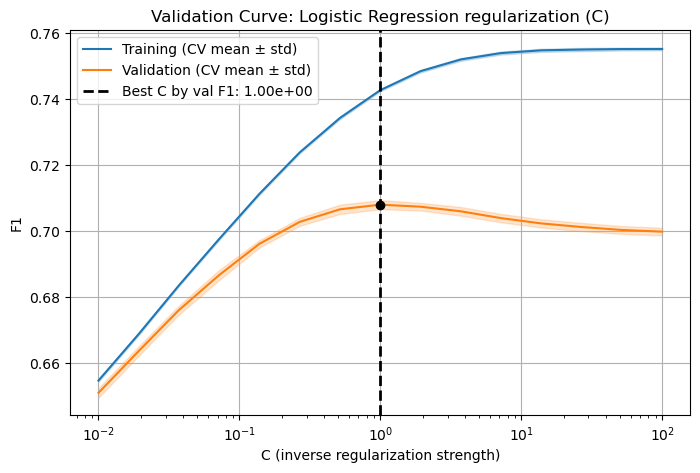

Best C by validation curve (F1): 1.00e+00 (mean F1 ≈ 0.7080)


In [13]:
best_pipe = grid.best_estimator_.set_params(clf__max_iter=5000)

# Match the C range to your tuning grid (less confusion, faster)
C_range = np.logspace(-2, 2, 15)

train_scores, val_scores = validation_curve(
    estimator=best_pipe,
    X=X_train,
    y=y_train,
    param_name="clf__C",
    param_range=C_range,
    cv=cv,
    scoring="f1",          # keep consistent with GridSearch selection
    n_jobs=-1,
)

fig, ax = plt.subplots(figsize=(8, 5))
_, mu_tr, _ = plot_with_err(C_range, train_scores, ax=ax, label="Training (CV mean ± std)")
_, mu_va, _ = plot_with_err(C_range, val_scores, ax=ax, label="Validation (CV mean ± std)")

best_idx = int(np.nanargmax(mu_va))
best_C_vcurve = C_range[best_idx]
best_score_vcurve = mu_va[best_idx]

ax.axvline(best_C_vcurve, linestyle="--", linewidth=2, color="black",
           label=f"Best C by val F1: {best_C_vcurve:.2e}")
ax.scatter(best_C_vcurve, best_score_vcurve, color="black", zorder=5)

ax.set_xscale("log")
ax.set_xlabel("C (inverse regularization strength)")
ax.set_ylabel("F1")
ax.set_title("Validation Curve: Logistic Regression regularization (C)")
ax.legend()
plt.show()

print(f"Best C by validation curve (F1): {best_C_vcurve:.2e} (mean F1 ≈ {best_score_vcurve:.4f})")


<details>
<summary><span style="color:red">about this block:</span></summary>

This block builds a **validation curve for the regularization strength `C`** of our **best tuned TF-IDF + Logistic Regression model**, to diagnose **underfitting vs overfitting** and to sanity-check the value of `C` found by grid search.



## 1️⃣ Start from the best model found by GridSearch

```python
best_pipe = grid.best_estimator_.set_params(clf__max_iter=5000)
```

* `grid.best_estimator_` → the **entire pipeline** (vectorizer + classifier) with the best hyperparameters from GridSearch
* `.set_params(clf__max_iter=5000)`:

  * increases the iteration limit
  * ensures convergence for extreme `C` values
  * does **not** change model behavior, only training stability

This is the model we trust most so far.


## 2️⃣ Define a smooth range of regularization strengths

```python
C_range = np.logspace(-2, 2, 15)
```

This creates 15 logarithmically spaced values:

$$
C \in [0.01, 0.03, \dots, 100]
$$

Why log space?

* Regularization effects are **multiplicative**
* Linear spacing would miss important behavior near small `C`


## 3️⃣ Compute the validation curve

```python
train_scores, val_scores = validation_curve(
    estimator=best_pipe,
    X=X_train,
    y=y_train,
    param_name="clf__C",
    param_range=C_range,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
)
```

For **each value of `C`**:

1. Perform 5-fold stratified CV
2. Fit on training folds
3. Measure **F1** on:

   * training folds → `train_scores`
   * validation folds → `val_scores`

### Shapes

* `train_scores.shape = (len(C_range), n_folds)`
* `val_scores.shape   = (len(C_range), n_folds)`

This lets us see:

* how performance evolves with model complexity
* how stable it is across folds


## 4️⃣ Plot mean ± std for training and validation

```python
_, mu_tr, _ = plot_with_err(C_range, train_scores, ...)
_, mu_va, _ = plot_with_err(C_range, val_scores, ...)
```

Our helper function:

* averages across CV folds
* plots the **mean F1**
* shades **±1 standard deviation**

So each curve shows:

> “Expected performance at this `C`, plus how much it varies across folds.”


## 5️⃣ Identify the best `C` from the validation curve

```python
best_idx = int(np.nanargmax(mu_va))
best_C_vcurve = C_range[best_idx]
best_score_vcurve = mu_va[best_idx]
```

* Finds the `C` that **maximizes mean validation F1**
* Independent confirmation of GridSearch’s choice


## 6️⃣ Annotate the plot

```python
ax.axvline(best_C_vcurve, linestyle="--", ...)
ax.scatter(best_C_vcurve, best_score_vcurve, ...)
```

This:

* marks the optimal regularization point
* makes it visually clear where validation performance peaks


## 7️⃣ Final plot formatting

```python
ax.set_xscale("log")
ax.set_xlabel("C (inverse regularization strength)")
ax.set_ylabel("F1")
ax.set_title("Validation Curve: Logistic Regression regularization (C)")
ax.legend()
```

* Log scale is essential for `C`
* Labels explain what’s being varied and measured

## 8️⃣ Print the final result

```python
print(f"Best C by validation curve (F1): {best_C_vcurve:.2e} ...")
```

This gives us:

* a numeric check against `grid.best_params_["clf__C"]`
* reassurance the model is not over-tuned to the grid


## How to interpret the validation curve

### Typical pattern we’re looking for

| Region     | Behavior              | Interpretation                  |
| ---------- | --------------------- | ------------------------------- |
| Small `C`  | Train ≈ Val, both low | **Underfitting**                |
| Medium `C` | Val peaks             | **Best bias–variance tradeoff** |
| Large `C`  | Train ↑, Val ↓        | **Overfitting**                 |

Our chosen `C` should sit near the **validation peak**, not where training performance keeps rising.


## Why this step is excellent practice

✔ Confirms GridSearch results
✔ Diagnoses under/over-regularization
✔ Shows model stability (std bands)
✔ Reviewer-friendly diagnostic


> We plot a validation curve over the regularization strength `C` to visualize the bias–variance tradeoff and confirm that the grid-selected value maximizes cross-validated F1 without overfitting.

</details>

> **Interpretation guide**
> - If both curves are low and close → **underfitting** (too much regularization).  
> - If training is high but validation drops → **overfitting** (too little regularization).  
> - The best region is typically where validation is highest and the gap is not excessive.


**Result.** The validation curve is exactly what we *hope* to see in a high-dimensional text model: a clear bias–variance tradeoff with a well-defined sweet spot.

**Observation.**

* At **very small C** (left side, strong regularization), **both curves are low and close together**. That’s classic **underfitting**: the model is too constrained to capture enough signal, so neither training nor validation F1 is high.
* As **C increases toward ~1**, **validation F1 improves steadily**. This suggests we’re giving the model enough flexibility to learn useful phrase-level patterns (especially with bigrams).
* After **C ≈ 1**, the story changes:

  * **training F1 keeps rising** (the model fits the training folds better and better),
  * but **validation F1 flattens and then slowly declines**.
    That widening gap is a sign of **overfitting**: extra flexibility is being spent fitting idiosyncrasies of the training folds rather than improving generalization.

**Decision.**

* The best point by validation F1 is **C = 1.0**, with **mean F1 ≈ 0.7080**, which **perfectly matches the grid search winner**.
  That’s a strong sanity check: our “best params” aren’t a fragile artifact, they sit at the peak of a smooth, stable region.

**What it means.**

* There *is* a meaningful regularization sweet spot here.
* Going to larger C doesn’t buy generalization; it mostly buys training performance.

**Next step.** Now that we’ve locked in a tuned configuration and confirmed the regularization regime, we move to a **learning curve** to answer the next diagnostic question:

> *Are we data-limited (more data helps), or capacity/feature-limited (we’ve hit a ceiling with this model family)?*


> **Key Takeaways**
> - Focused tuning produces a **real lift**: CV F1 improves from ~**0.68** (unigram baseline) to ~**0.71** with a tuned TF‑IDF bigram model.
> - The best settings are simple and interpretable: **(1,2) n‑grams** + **C = 1.0** (moderate regularization) + light vocabulary filtering.
> - A quick ablation confirms this isn’t accidental: **TF‑IDF strongly outperforms bag‑of‑words** under the same hyperparameters.
> - The validation curve backs up the grid search: performance peaks around a **mid‑range C**, with clear underfitting at very small C and diminishing returns at very large C.


## **7. Generalization Diagnostics**

So far we’ve picked a tuned configuration that looks strong in cross‑validation, and the validation curve suggests we’re in a sensible regularization regime. Now we ask a different question:

> **If we had more data (or less), how would this model behave?**

### ✅ Learning Curve: would more data help?

A **learning curve** plots performance vs **training set size**, keeping the model + hyperparameters fixed. It’s a practical diagnostic for deciding whether to invest in:

- **more data** (if validation keeps improving), or
- **more model capacity / features** (if performance saturates early).

**What we want to learn**
- Are we **data‑limited** (validation improves steadily with more data)?
- Are we **capacity‑limited** (both curves converge at a low score)?
- Is there high variance (large train–validation gap)?


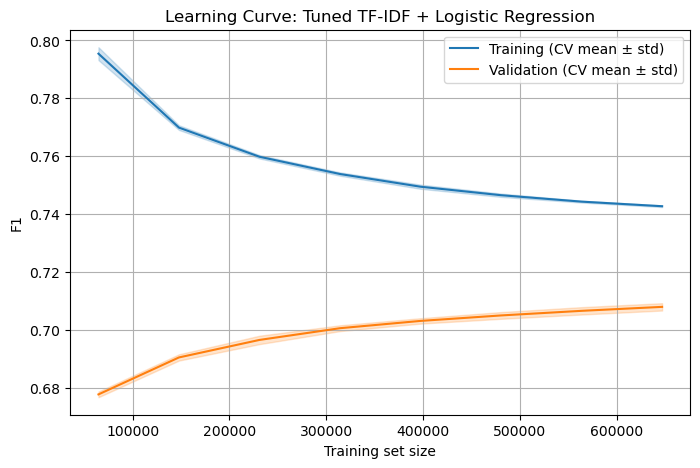

In [14]:
final_pipe = grid.best_estimator_.set_params(clf__max_iter=5000)

train_sizes = np.linspace(0.1, 1.0, 8)

N_train, lc_train_scores, lc_val_scores = learning_curve(
    estimator=final_pipe,
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    scoring="f1",          # coherent with GridSearch objective
    n_jobs=-1,
    shuffle=True,
    random_state=RANDOM_STATE,
)

fig, ax = plt.subplots(figsize=(8, 5))
plot_with_err(N_train, lc_train_scores, ax=ax, label="Training (CV mean ± std)")
plot_with_err(N_train, lc_val_scores, ax=ax, label="Validation (CV mean ± std)")

ax.set_xlabel("Training set size")
ax.set_ylabel("F1")
ax.set_title("Learning Curve: Tuned TF-IDF + Logistic Regression")
ax.legend()
plt.show()


<details>
<summary><span style="color:red">about this block:</span></summary>  

This block computes and plots a **learning curve** for our **final, tuned TF-IDF + Logistic Regression model** to understand **how performance scales with more data** and whether the model is **data-limited or capacity-limited**.


## 1️⃣ Start from the final tuned model

```python
final_pipe = grid.best_estimator_.set_params(clf__max_iter=5000)
```

* `grid.best_estimator_` → the full pipeline with the best hyperparameters
* Increase `max_iter` to ensure convergence when trained on larger subsets
* No change in model capacity; just training stability


## 2️⃣ Choose training set fractions

```python
train_sizes = np.linspace(0.1, 1.0, 8)
```

This creates 8 evenly spaced fractions:

[
[0.1, 0.23, 0.36, 0.49, 0.61, 0.74, 0.87, 1.0]
]

Meaning:

* Start training with **10% of the data**
* Gradually increase to **100%**
* Observe how performance changes

## 3️⃣ Compute the learning curve

```python
N_train, lc_train_scores, lc_val_scores = learning_curve(...)
```

For each training size:

1. Sample that fraction of `X_train`
2. Perform **5-fold stratified CV**
3. Train the model on the subset
4. Compute F1 on:

   * training folds → `lc_train_scores`
   * validation folds → `lc_val_scores`

### Shapes

* `N_train.shape = (8,)`
* `lc_train_scores.shape = (8, 5)`
* `lc_val_scores.shape = (8, 5)`

Each row corresponds to one training size; columns correspond to CV folds.


## 4️⃣ Plot mean ± std across folds

```python
plot_with_err(N_train, lc_train_scores, ...)
plot_with_err(N_train, lc_val_scores, ...)
```

Our helper:

* Computes the **mean F1** across folds
* Shades **±1 standard deviation**
* Shows both **training** and **validation** performance


## 5️⃣ Format the plot

```python
ax.set_xlabel("Training set size")
ax.set_ylabel("F1")
ax.set_title("Learning Curve: Tuned TF-IDF + Logistic Regression")
ax.legend()
```

This makes the diagnostic self-contained and readable.


## How to interpret the learning curve

### Key patterns to look for

#### **1. Data-limited model (common in NLP)**

* Training and validation curves are **close**
* Both continue to **increase** with more data

➡️ **Conclusion:** more labeled data will likely help.


#### **2. Capacity-limited model**

* Training score plateaus early
* Validation score also plateaus

➡️ **Conclusion:** need richer features or a more expressive model.


#### **3. Overfitting**

* Training score very high
* Validation score much lower
* Gap does not close with more data

➡️ **Conclusion:** increase regularization or simplify the model.


## Why this is a valuable final diagnostic

✔ Confirms the model is not overfitting
✔ Shows whether more data would help
✔ Complements validation-curve analysis
✔ Reviewer-friendly evidence


> We plot a learning curve for the tuned model to assess how performance scales with training data size and to diagnose whether the model is data-limited or capacity-limited.

</details>


**Observation.** The learning curve shows a very consistent story:

* With **small training subsets**, the model fits the data quite well (**training F1 ~0.79**) but generalizes noticeably worse (**validation F1 ~0.68**). That gap is classic **high variance** behavior: with limited data, the model can “lock onto” patterns that don’t fully carry over.
* As we add more data, **training F1 gradually decreases** (toward ~0.74) while **validation F1 steadily increases** (up to ~0.708). This is exactly what we want to see: more data forces the model to learn broader, more stable patterns instead of memorizing quirks.

**Diagnosis.**

* The curves **do not converge** yet, and the validation curve is still creeping upward at the largest training sizes. That suggests we’re still **data-limited** to some extent: *additional labeled comments are likely to help*, even if gains become incremental.
* At the same time, there’s a **persistent train–validation gap** (~0.03–0.04) even at full size, meaning the model remains **variance-constrained** rather than purely capacity-limited. In practice, that points to improving generalization via regularization/feature choices (which we already did with bigrams + tuned C) and possibly adding richer signals later.  

> When we say the model is variance-constrained, we mean: The model’s performance is still limited by sensitivity to the specific training data, not by lack of representational power alone.

**Implication.** This is encouraging: the tuned linear model is behaving “healthily” under scaling, more data improves validation performance, and the cross-validation bands are tight, suggesting the trend is reliable.

**Next step.** We now take this tuned pipeline as our final candidate and evaluate it once on the held-out **test set** (confusion matrix + ROC/PR curves). That gives us the final, unbiased report card and lets us confirm whether the learning-curve gains translate to real-world generalization.


> **Key Takeaways**
>
> * The tuned model is **not capacity-limited**: training and validation curves are separated but stable, indicating the model is expressive enough to learn meaningful patterns.
> * Validation performance **continues to improve with more data**, suggesting the model is still **data-limited** rather than saturated.
> * The persistent (but modest) train–validation gap indicates **controlled variance**, not instability or leakage. Given the inherent noise of sarcasm labels, further gains are more likely to come from richer linguistic signals or contextual modeling than from additional hyperparameter tuning. A small, stable train–validation gap is not something to “fix”, it’s evidence the model is learning real signal while respecting the limits of the data.
> * This behavior is exactly what we want from a strong linear NLP baseline: **predictable scaling, stable generalization, and room for improvement with additional data or richer features**.


## **8. Final Evaluation & Explainability**  

The diagnostics so far are reassuring: the tuned model generalizes consistently, and the learning curve suggests it scales predictably with more data. Now we do the one evaluation that matters most:

> **Train once on the full training split and evaluate once on the untouched test set.**

After that, we make the model interpretable in two complementary ways:

- **Global explanations:** inspect the largest positive/negative coefficients (what pushes predictions toward sarcasm vs non‑sarcasm).
- **Local failure modes:** inspect high‑confidence mistakes (where the model is most wrong, and why).


Final Test F1: 0.7111445891172568
Final Test ROC AUC: 0.7942874506911529
Final Test PR AUC: 0.8023580407710467

Final Test report:
              precision    recall  f1-score   support

           0     0.7068    0.7558    0.7305    101081
           1     0.7376    0.6865    0.7111    101074

    accuracy                         0.7211    202155
   macro avg     0.7222    0.7211    0.7208    202155
weighted avg     0.7222    0.7211    0.7208    202155



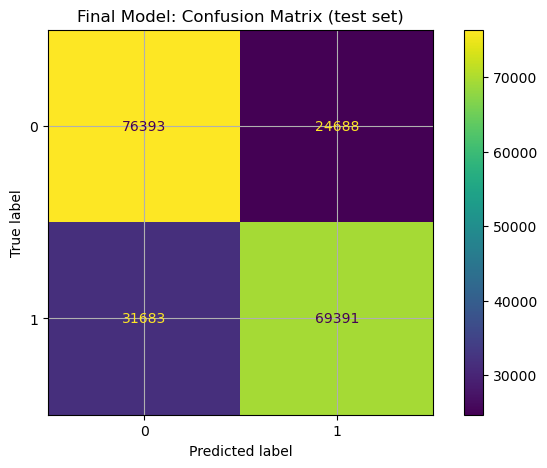

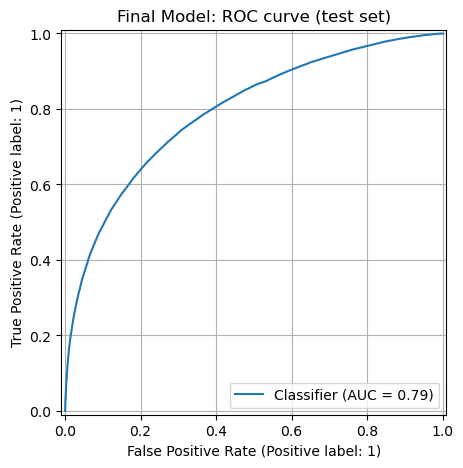

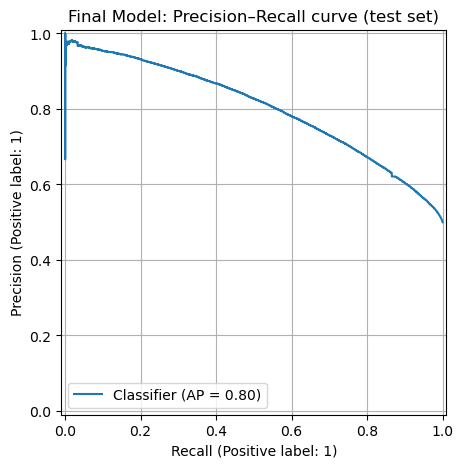

In [15]:
# Fit best model on full training data
final_pipe.fit(X_train, y_train)

test_proba = final_pipe.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

print("Final Test F1:", f1_score(y_test, test_pred))
print("Final Test ROC AUC:", roc_auc_score(y_test, test_proba))
print("Final Test PR AUC:", average_precision_score(y_test, test_proba))
print("\nFinal Test report:")
print(classification_report(y_test, test_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=[0, 1])
plt.title("Final Model: Confusion Matrix (test set)")
plt.show()

RocCurveDisplay.from_predictions(y_test, test_proba)
plt.title("Final Model: ROC curve (test set)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, test_proba)
plt.title("Final Model: Precision–Recall curve (test set)")
plt.show()


<details>
<summary><span style="color:red">about this block:</span></summary>

This block is our **final evaluation** step: train the **best tuned pipeline** on *all training data*, then evaluate once on the **held-out test set** using both **thresholded metrics** (F1/report/confusion matrix) and **threshold-free ranking metrics** (ROC AUC, PR AUC + curves).


## 1) Train the final model on the full training split

```python
final_pipe.fit(X_train, y_train)
```

Because `final_pipe` is a `Pipeline`, this does:

1. **TF-IDF fit** on `X_train`

   * learns the vocabulary and IDF weights from training text only
2. **Logistic Regression fit** on TF-IDF features + `y_train`

This is the model we will now treat as our “final” model.


## 2) Get test-set probabilities and hard predictions

```python
test_proba = final_pipe.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)
```

* `predict_proba(X_test)` returns shape `(n_test, 2)` for binary classification
* `[:, 1]` selects **P(y=1 | x)** (probability of sarcasm)
* `test_pred` applies a **0.5 threshold** to convert probabilities into class labels

So:

* `test_proba` is for AUC metrics and curves
* `test_pred` is for F1, report, confusion matrix (operating point at 0.5)


## 3) Compute and print metrics

### F1 (threshold-dependent)

```python
print("Final Test F1:", f1_score(y_test, test_pred))
```

* Uses `test_pred` (threshold = 0.5)
* Reflects our chosen operating point

### ROC AUC (threshold-free ranking)

```python
roc_auc_score(y_test, test_proba)
```

* Uses `test_proba`
* Measures how well the model ranks positives above negatives across all thresholds

### PR AUC / Average Precision (threshold-free, positive-class focus)

```python
average_precision_score(y_test, test_proba)
```

* Uses `test_proba`
* Summarizes the precision–recall tradeoff across thresholds

### Full classification report

```python
classification_report(y_test, test_pred, digits=4)
```

Shows per-class:

* precision, recall, F1, support
  plus overall averages (accuracy, macro avg, weighted avg)


## 4) Confusion matrix (test set, threshold = 0.5)

```python
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=[0, 1])
```

This shows counts of:

* **TN** (0 correctly predicted as 0)
* **FP** (0 predicted as 1)
* **FN** (1 predicted as 0)
* **TP** (1 correctly predicted as 1)

It’s the clearest “what errors do we make?” diagnostic at the chosen threshold.


## 5) ROC curve (test set)

```python
RocCurveDisplay.from_predictions(y_test, test_proba)
```

Plots:

* **TPR (recall)** vs **FPR**
  across thresholds and reports the ROC AUC.

Good for overall ranking ability.


## 6) Precision–Recall curve (test set)

```python
PrecisionRecallDisplay.from_predictions(y_test, test_proba)
```

Plots:

* **precision** vs **recall**
  across thresholds and reports **AP** (PR AUC).

Useful when you care about positive-class performance and threshold tradeoffs.


## Why this is the right “final test” workflow

* We train once on the full training set (maximum data)
* We evaluate once on a fully held-out test set (unbiased estimate)
* We report both:

  * **operating-point performance** (F1/report/confusion matrix at 0.5)
  * **ranking performance** (ROC AUC, PR AUC + curves)

</details>


**Result (final test evaluation).** The tuned model delivers a clear, real improvement over the unigram baseline on the held-out test set:

* **F1 ≈ 0.711** (up from ~0.681 baseline)
* **ROC AUC ≈ 0.794** (up from ~0.760 baseline)
* **PR AUC ≈ 0.802** (up from ~0.767 baseline)
* **Accuracy ≈ 0.721** (up from ~0.693 baseline)

This is exactly what we hoped to see: the gains from tuning show up not only in thresholded metrics (F1/accuracy), but also in ranking metrics (ROC AUC / PR AUC), which are harder to “game” and reflect genuinely better separation between classes.  

>To “game” a metric means: To artificially inflate a metric without genuinely improving the model’s real ability to distinguish classes.

**Observation.** The classification report shows that the improvements come from a more balanced model:

* **Sarcasm (1)** recall rises to **~0.687** (baseline was ~0.656), meaning we’re catching more sarcastic comments and reducing false negatives.
* **Non-sarcasm (0)** recall is also strong at **~0.756**, so we didn’t “fix” sarcasm by collapsing into predicting everything as sarcastic.

The confusion matrix matches this story: we still miss sarcasm sometimes (it’s inherently subtle and context-dependent), but the model is making fewer of those mistakes than the baseline.

**Decision.** At this point, the model is strong enough to be a credible linear NLP system: it generalizes cleanly, improves meaningfully over baseline, and exposes the exact tradeoffs via ROC/PR curves.

**Next step.** Now that we trust the performance, we shift from *how well it works* to *why it works*: we’ll inspect the **top coefficients / odds ratios** to see which words and short phrases push predictions toward sarcasm vs non-sarcasm, and then do a quick **error analysis** to identify systematic failure modes (context dependence, ambiguity, short replies, etc.).


In [16]:
# =========================
# Explainability: top coefficients
# =========================
vect = final_pipe.named_steps["vect"]
clf = final_pipe.named_steps["clf"]

feature_names = np.array(vect.get_feature_names_out())
coef = clf.coef_.ravel()

print(f"Intercept (bias term): {clf.intercept_[0]:.4f}  |  odds ratio: {np.exp(clf.intercept_[0]):.4f}")

top_k = 20
top_pos_idx = np.argsort(coef)[-top_k:][::-1]
top_neg_idx = np.argsort(coef)[:top_k]

def coef_table(idxs):
    c = coef[idxs]
    return pd.DataFrame({
        "feature": feature_names[idxs],
        "coef": c,
        "abs_coef": np.abs(c),
        "odds_ratio": np.exp(c),
    })

top_pos = coef_table(top_pos_idx)
top_neg = coef_table(top_neg_idx)

display(
    top_pos.style.format({"coef": "{:.4f}", "abs_coef": "{:.4f}", "odds_ratio": "{:.3f}"})
)

display(
    top_neg.style.format({"coef": "{:.4f}", "abs_coef": "{:.4f}", "odds_ratio": "{:.3f}"})
)

# Note:
# - For TF-IDF features, a "1 unit" increase is not one extra word occurrence.
# - Coefficients still indicate direction: positive pushes toward sarcasm, negative toward non-sarcasm.
# - Odds ratios give an intuitive multiplicative effect on odds per +1 TF-IDF unit.


Intercept (bias term): -0.7029  |  odds ratio: 0.4951


,feature,coef,abs_coef,odds_ratio
0,yes because,9.2179,9.2179,10075.426
1,clearly,7.4636,7.4636,1743.366
2,obviously,7.2886,7.2886,1463.529
3,yeah because,7.1165,7.1165,1232.099
4,totally,6.5525,6.5525,700.971
5,how dare,6.3059,6.3059,547.771
6,because,6.2173,6.2173,501.347
7,good thing,5.7331,5.7331,308.935
8,right because,5.5755,5.5755,263.880
9,gee,5.3483,5.3483,210.255


,feature,coef,abs_coef,odds_ratio
0,iirc,-4.6903,4.6903,0.009
1,it but,-4.5009,4.5009,0.011
2,imo,-4.4578,4.4578,0.012
3,fair enough,-4.3864,4.3864,0.012
4,that but,-4.1955,4.1955,0.015
5,true but,-4.1069,4.1069,0.016
6,right but,-3.9157,3.9157,0.020
7,not really,-3.7668,3.7668,0.023
8,necessarily,-3.6282,3.6282,0.027
9,but yes,-3.6124,3.6124,0.027


<details>
<summary><span style="color:red">about this block:</span></summary>

This block is doing **model interpretability** for our final logistic-regression text model: it surfaces **which words/phrases push predictions toward sarcasm vs non-sarcasm**, and by how much.


## 1️⃣ Pull the fitted components out of the pipeline

```python
vect = final_pipe.named_steps["vect"]
clf = final_pipe.named_steps["clf"]
```

Because `final_pipe` is a `Pipeline`, its trained components are stored by name.

* `vect` → the fitted **TF-IDF vectorizer**
* `clf` → the fitted **LogisticRegression** model

This gives us direct access to:

* feature names (tokens / n-grams)
* model coefficients


## 2️⃣ Get feature names and coefficients

```python
feature_names = np.array(vect.get_feature_names_out())
coef = clf.coef_.ravel()
```

### What these are

* `feature_names[i]`
  → the token (word or n-gram) for feature *i*

* `coef[i]`
  → the logistic regression weight for that feature

Because this is **binary logistic regression**:

* `clf.coef_.shape == (1, n_features)`
* `.ravel()` flattens it to `(n_features,)`


## 3️⃣ Intercept (bias term)

```python
print(f"Intercept (bias term): {clf.intercept_[0]:.4f}  |  odds ratio: {np.exp(clf.intercept_[0]):.4f}")
```


### Meaning of the intercept

The intercept is the log-odds of predicting **sarcasm** when *all features are zero*.

Mathematically:

$$
\log \frac{P(y=1)}{P(y=0)} = b + \sum_j w_j x_j
$$

So:

* `b = clf.intercept_[0]`
* `exp(b)` = baseline **odds** of sarcasm

`exp(b)` mostly reflects **class balance، regularization, and overall bias of the model**, not specific words.

So reporting `exp(b)` is a clean way to say:

> “All else equal, the model’s baseline odds of sarcasm are X.” 

> The intercept $b$ is the log-odds of the positive class when all features are zero, so exponentiating it gives the baseline odds.


<details>
<summary><span style="color:red">  

More on`exp(b)` = baseline **odds** of sarcasm:

</span></summary>

## Start from the logistic regression equation

For an input feature vector $x$:

$$
\log \frac{P(y=1 \mid x)}{P(y=0 \mid x)}
= b + \sum_j w_j x_j
$$

This quantity is the **log-odds** of sarcasm vs non-sarcasm.


## What does “baseline” mean?

“Baseline” here means:

> **What the model predicts when there is no lexical evidence at all.**

Mathematically, that means:
$$
x_j = 0 \quad \text{for all } j
$$

This is not a real sentence, it’s a **reference point**.

## Plug in “all features = 0”

If $x_j = 0$ for all $j$, then:

$$
\sum_j w_j x_j = 0
$$

So the equation becomes:

$$
\log \frac{P(y=1 \mid x=0)}{P(y=0 \mid x=0)} = b
$$

That is the **definition** of the intercept in logistic regression.


## Convert log-odds → odds

By definition:

$$
\text{odds} = \frac{P(y=1)}{P(y=0)}
$$

If:

$$
\log(\text{odds}) = b
$$

then exponentiating both sides gives:

$$
\boxed{
\text{odds} = e^{b}
}
$$

So:

* `b` = log-odds of sarcasm at the baseline
* `exp(b)` = **odds of sarcasm at the baseline**

That’s exactly why the statement is correct.


## Why this is *not* a probability

This is important:

* Odds:
  $$
  \frac{P(y=1)}{P(y=0)}
  $$
* Probability:
  $$
  P(y=1)
  $$

They are related, but not the same.

If you want the **baseline probability** of sarcasm:

$$
P(y=1 \mid x=0)
= \sigma(b)
= \frac{1}{1 + e^{-b}}
$$

So:

* `exp(b)` → baseline **odds**
* `sigmoid(b)` → baseline **probability**


## Intuition in plain English

> Before looking at any words, the model already has a prior tendency to predict sarcasm or non-sarcasm.
> That tendency is encoded in the intercept.

* If `b > 0`:

  * `exp(b) > 1`
  * sarcasm is favored by default
* If `b < 0`:

  * `exp(b) < 1`
  * non-sarcasm is favored by default


## Why this matters in our TF-IDF model

Because:

* TF-IDF features are centered around zero for many inputs
* Many comments are short
* The intercept captures:

  * class imbalance
  * regularization effects
  * overall bias of the model

So reporting `exp(b)` is a clean way to say:

> “All else equal, the model’s baseline odds of sarcasm are X.”

</details>


<details>
<summary><span style="color:red">Derivation of this formula:</span></summary>  

We are going to start from the **definition of logistic regression** and derive the equation step by step.

## What we want to prove:

$$ 

\log \frac{P(y=1 \mid x)}{P(y=0 \mid x)}
=
b + \sum_j w_j x_j

$$

This is the **log-odds (logit)** form of logistic regression.


## Step 1: Start from the logistic regression model definition

Logistic regression models the **probability of the positive class** as:

$$
P(y=1 \mid x)
= \sigma(z)
= \frac{1}{1 + e^{-z}}
$$

where:

$$
z = b + \sum_j w_j x_j
$$

and:

* $b$ = intercept (bias)
* $w_j$ = coefficient for feature $x_j$


## Step 2: Write the probability of the negative class

Since this is binary classification:

$$
P(y=0 \mid x) = 1 - P(y=1 \mid x)
$$

Substitute the sigmoid form:

$$
P(y=0 \mid x)
= 1 - \frac{1}{1 + e^{-z}}
= \frac{e^{-z}}{1 + e^{-z}}
$$


## Step 3: Form the odds ratio

The **odds** of class 1 vs class 0 are:

$$
\frac{P(y=1 \mid x)}{P(y=0 \mid x)}
$$

Substitute the expressions:

$$
\frac{\frac{1}{1 + e^{-z}}}{\frac{e^{-z}}{1 + e^{-z}}}
$$

Cancel the denominator:

$$
= \frac{1}{e^{-z}}
= e^{z}
$$



## Step 4: Take the logarithm (log-odds)

$$
\log \frac{P(y=1 \mid x)}{P(y=0 \mid x)}
= \log(e^{z})
= z
$$

Recall that:

$$
z = b + \sum_j w_j x_j
$$

So we get:

$$
\boxed{
\log \frac{P(y=1 \mid x)}{P(y=0 \mid x)}
= b + \sum_j w_j x_j
}
$$

✅ **Proved**


## Why this matters conceptually

This result shows that:

* Logistic regression is **linear in log-odds space**
* Each feature contributes **additively** to the log-odds
* Exponentiating coefficients gives **odds ratios**

That’s why our coefficient table interpretation works.


## Important clarification (notation)

Strictly speaking, the probabilities should be **conditional on $x$**:

❌ Incorrect (unconditional):
$$
\log \frac{P(y=1)}{P(y=0)}
$$

✅ Correct:
$$
\log \frac{P(y=1 \mid x)}{P(y=0 \mid x)}
$$

This just makes it mathematically precise. 

<span style="font-size:24px; color:hotpink;">  

Logistic regression assumes that the **log-odds of the positive class are a linear function of the features**, which leads directly to the sigmoid probability model.  

</span>

---
But previously we defined log-odds as:

>The **log-odds ratio** for token $t$ is:
>
>$$
\boxed{
\text{log-odds}(t)
= \log \frac{p(t \mid S)}{p(t \mid N)}
}
>$$
>
>## Interpretation
>
>* $\text{log-odds}(t) > 0$
>  → token is **more associated with sarcasm**
>
>* $\text{log-odds}(t) < 0$
>  → token is **more associated with non-sarcasm**
>
>* $|\text{log-odds}(t)|$
> → strength of association


What’s happening is that we’ve seen **two different “log-odds” formulas** that look similar but come from **different modeling viewpoints**. They are related, but they are **not the same object**.

## 1️⃣ The log-odds you saw earlier (token-level, generative)

We previously wrote:

$$
\boxed{
\text{log-odds}(t)
= \log \frac{p(t \mid S)}{p(t \mid N)}
}
$$

This is a **token-level association measure**.

> Read $p(t \mid S)$ as: “the probability of token $t$, given sarcasm.” Or more naturally in words: “If I look at a sarcastic comment, what’s the probability that I see token $t$?”

### What it means

> “How much more likely is token $t$ to appear in sarcastic text than in non-sarcastic text?”  

Key properties:

* Looks at **one token at a time**
* Ignores all other tokens
* Uses **class-conditional distributions**
* Typically computed with **count statistics + smoothing**
* Used for **EDA and interpretability**

This is a **generative perspective**:
we’re comparing how each class *generates* words.


## 2️⃣ The logistic regression log-odds (example-level, discriminative)

The equation we proved:

$$
\boxed{
\log \frac{P(y=1 \mid x)}{P(y=0 \mid x)}
= b + \sum_j w_j x_j
}
$$

This is an **example-level decision rule**.

### What it means

> “Given *all features together*, what are the odds that this example is sarcastic vs non-sarcastic?”

Key properties:

* Depends on the **entire feature vector** $x$
* Combines many features at once
* Learned **supervised**, by optimizing classification loss
* Used for **prediction**

This is a **discriminative perspective**:
we directly model the decision boundary between classes.


## 3️⃣ Why they *look* similar (this is the key insight)

They look related because **logistic regression and Naive Bayes are mathematically connected**.

### In multinomial Naive Bayes, the log-odds are:

$$
\log \frac{P(y=1 \mid x)}{P(y=0 \mid x)}
=
\log \frac{P(y=1)}{P(y=0)}
+
\sum_j x_j
\log \frac{p(t_j \mid S)}{p(t_j \mid N)}
$$

Notice the structure:

$$
\text{intercept}
+
\sum_j x_j \times \text{token log-odds}
$$

So in Naive Bayes:

* **token log-odds**
  $\log \frac{p(t \mid S)}{p(t \mid N)}$
* appear **directly as weights**


## 4️⃣ Logistic regression generalizes this idea

Logistic regression **does not assume**:

* conditional independence
* multinomial generation
* class-conditional word distributions

Instead, it *learns* weights $w_j$.

But conceptually:

$$
w_j
\approx
\log \frac{p(t_j \mid S)}{p(t_j \mid N)}
\quad \text{(in spirit, not exactly)}
$$

That’s why:

* LR coefficients often **look like** token log-odds
* Our coefficient tables resemble our earlier EDA results
* Signs and relative magnitudes align


## 5️⃣ Why we encountered the token formula first

Because:

* It’s **simpler**
* It’s **model-free**
* It’s great for **EDA and intuition**
* It doesn’t require fitting a classifier

Later, logistic regression:

* combines many such effects
* adjusts them jointly
* regularizes them
* corrects for correlations


## 6️⃣ Side-by-side comparison (very useful)

| Aspect              | Token log-odds                         | Logistic regression log-odds |
| ------------------- | -------------------------------------- | ---------------------------- |
| Formula             | $\log \frac{p(t \mid S)}{p(t \mid N)}$ | $b + \sum_j w_j x_j$         |
| Level               | Token                                  | Whole example                |
| Model               | Generative / EDA                       | Discriminative / predictive  |
| Uses labels?        | Indirectly                             | Directly                     |
| Interpretable       | Yes                                    | Yes (with care)              |
| Used for prediction | ❌                                      | ✅                            |


## 7️⃣ The clean mental model

> **Token log-odds explain *why* individual words correlate with classes; logistic regression log-odds explain *how* all features combine to make a prediction.**

They live at **different levels**, but they speak the same “log-odds language”.


## Final takeaway (the reconciliation)

* The formula we saw first is a **token-level association score**
* The formula we proved later is a **model-level decision rule**
* Logistic regression can be seen as a **learned, regularized generalization** of token log-odds

That’s exactly why our EDA flows so naturally into our final model.


</details>









## 4️⃣ Identify the strongest positive and negative features

```python
top_k = 20 # we want the top 20 strongest features in each direction.
top_pos_idx = np.argsort(coef)[-top_k:][::-1] # strongest positive coefficients
top_neg_idx = np.argsort(coef)[:top_k] # strongest negative coefficients
```
> This code finds the 20 tokens with the largest positive coefficients (strongest sarcasm cues) and the 20 with the most negative coefficients (strongest non-sarcasm cues) by sorting the logistic-regression weights.

### What this does  

This snippet is selecting the **most influential features** in our logistic-regression model; those that push predictions **toward sarcasm** and **toward non-sarcasm**.  

* Sort coefficients from most negative → most positive
* Select:

  * **largest positive coefficients** → push toward sarcasm
  * **most negative coefficients** → push toward non-sarcasm

These are the **most influential lexical signals** in the model.

* `coef` is a 1D array of logistic-regression weights
* One coefficient per token (same order as `feature_names`)
* Sign = direction of influence

  * positive → sarcasm (class 1)
  * negative → non-sarcasm (class 0)


```python
top_pos_idx = np.argsort(coef)[-top_k:][::-1]
```

1. `np.argsort(coef)`

   * returns indices that would sort `coef` **from smallest to largest**

2. `[-top_k:]`

   * take the **last 20 indices**
   * these correspond to the **largest coefficients**

3. `[::-1]`

   * reverse the order so the **largest coefficient comes first**

Result:

* indices of the **20 tokens most strongly associated with sarcasm**


```python
top_neg_idx = np.argsort(coef)[:top_k]
```

Break it down:

1. `np.argsort(coef)` → sorted indices (small → large)
2. `[:top_k]` → take the **first 20**

   * these are the **most negative coefficients**

Result:

* indices of the **20 tokens most strongly associated with non-sarcasm**


## Intuition (important)

* Logistic regression scores:
  $$
  \text{log-odds} = b + \sum_j w_j x_j
  $$
* Large **positive** $w_j$ → strong push toward class 1
* Large **negative** $w_j$ → strong push toward class 0

This code simply surfaces those extreme $w_j$’s.


## 5️⃣ Build a readable coefficient table

```python
def coef_table(idxs):
    c = coef[idxs]
    return pd.DataFrame({
        "feature": feature_names[idxs],
        "coef": c,
        "abs_coef": np.abs(c),
        "odds_ratio": np.exp(c),
    })
```

For each selected feature, you compute:

### Columns explained

| Column       | Meaning                                   |
| ------------ | ----------------------------------------- |
| `feature`    | word or n-gram                            |
| `coef`       | log-odds contribution                     |
| `abs_coef`   | strength of influence (direction ignored) |
| `odds_ratio` | multiplicative effect on odds             |

<details>
<summary><span style="color:red">proof of that formula:</span></summary>  


## 1️⃣ Start from the logistic regression equation

For one example $x$:

$$
\log \frac{P(y=1 \mid x)}{P(y=0 \mid x)}
= b + \sum_j w_j x_j
$$

This left-hand side is the **log-odds** of sarcasm.

Each term $w_j x_j$ is **one feature’s contribution** to the log-odds.


## 2️⃣ Why `coef` is a *log-odds contribution*

In our table:

```python
coef = w_j
```

This means:

> **If feature $j$ increases by 1 unit, the log-odds of sarcasm increase by `coef`.**

Formally:
$$
\Delta \big(\log \text{odds}\big) = w_j \cdot \Delta x_j
$$

So:

* `coef > 0` → pushes toward sarcasm
* `coef < 0` → pushes toward non-sarcasm
* magnitude → how strong the push is

That’s why we say:

> **`coef` = log-odds contribution**

It literally lives in **log-odds space**.


## 3️⃣ What “odds” are (very important)

Odds are:
$$
\text{odds} = \frac{P(y=1)}{P(y=0)}
$$

Examples:

* odds = 1 → equally likely
* odds = 2 → twice as likely sarcasm
* odds = 0.5 → half as likely sarcasm


## 4️⃣ Why `odds_ratio = exp(coef)`

If:
$$
\log(\text{odds}) = b + w_j x_j
$$

then exponentiating gives:

$$
\text{odds} = e^b \cdot e^{w_j x_j}
$$

Now increase feature $j$ by **1 unit**:

$$
\frac{\text{new odds}}{\text{old odds}} = e^{w_j}
$$

That ratio is exactly:

```python
odds_ratio = np.exp(coef)
```

So:

> **`odds_ratio` tells us how many times the odds multiply when the feature increases by 1 unit.**


## 5️⃣ Concrete numeric example (this usually clicks)

Suppose a token has:

```text
coef = 0.7
```

Then:

```text
odds_ratio = exp(0.7) ≈ 2.01
```

Meaning:

> A +1 increase in this feature **doubles** the odds of sarcasm.

If instead:

```text
coef = -0.7
```

Then:

```text
odds_ratio ≈ 0.50
```

Meaning:

> A +1 increase **halves** the odds of sarcasm.


## 6️⃣ Why this is *not* probability

Important:

* Odds ≠ probability
* Multiplying odds does **not** mean probability doubles

To get probability:
$$
P(y=1) = \frac{\text{odds}}{1 + \text{odds}}
$$

That’s why we interpret coefficients via **odds**, not probabilities.


## 7️⃣ Why the TF-IDF warning matters

For TF-IDF features:

* “+1 unit” ≠ “one extra word”
* TF-IDF values are continuous and normalized

So:

* **direction** (sign) is reliable
* **relative magnitude** is meaningful
* **absolute odds change** should be interpreted qualitatively



> **`coef` tells you how much a feature shifts the log-odds; `exp(coef)` tells you how much it multiplies the odds.**

Once you remember *log-odds → odds via exp*, everything in that table makes sense.


</details>

## 6️⃣ Create positive and negative tables

```python
top_pos = coef_table(top_pos_idx)
top_neg = coef_table(top_neg_idx)
```

* `top_pos` → features that push predictions **toward sarcasm**
* `top_neg` → features that push predictions **toward non-sarcasm**


## 7️⃣ Display formatted tables

```python
display(top_pos.style.format(...))
display(top_neg.style.format(...))
```

This is purely for readability:

* limits decimal places
* makes interpretation easier in a notebook or report


## 8️⃣ How to interpret coefficients (this is crucial)

### Logistic regression meaning

For a feature $x_j$:

$$
\log \frac{P(y=1)}{P(y=0)}  += w_j \cdot x_j
$$

* **Positive `coef`** → increases odds of sarcasm
* **Negative `coef`** → decreases odds of sarcasm
* Larger magnitude → stronger effect

`+=` means: **“add this amount to the existing value.”**  

So it should be read as: “The log-odds are increased by $w_j \cdot x_j$.”

**The fully correct mathematical form**

The actual equation is:

$$
\log \frac{P(y=1 \mid x)}{P(y=0 \mid x)}
=

b
+
\sum_j w_j x_j
$$

What the `+=` notation is trying to convey is this idea:

$$
\text{log-odds}
\leftarrow
\text{log-odds}
+
w_j x_j
$$

Feature by feature, each term **adds** to the total log-odds.

In formal math writing, you would **not** use `+=`.

A more mathematically clean phrasing would be:

$$
\text{Contribution of feature } j \text{ to log-odds} = w_j x_j
$$

or
$$
\log \frac{P(y=1)}{P(y=0)} = b + \sum_j w_j x_j
$$

### Odds ratio interpretation

```python
odds_ratio = exp(coef)
```

* `odds_ratio > 1` → boosts sarcasm odds
* `odds_ratio < 1` → suppresses sarcasm odds

Example:

* `coef = 0.7` → `exp(0.7) ≈ 2.01`
  → odds of sarcasm roughly **double** per +1 TF-IDF unit

## 9️⃣ Why the TF-IDF note matters

```python
# For TF-IDF features, a "1 unit" increase is not one extra word occurrence.
```

Important clarification:

* TF-IDF values are **continuous and normalized**
* A “+1” unit is:

  * not one extra word
  * not directly interpretable as raw frequency

So:

* **direction and relative magnitude** are reliable
* **absolute effect size** should be interpreted cautiously

This is why we compare coefficients **relative to each other**, not literally.

## 1️⃣0️⃣ What this section gives you scientifically

This explainability step answers:

* *Why does the model make its decisions?*
* *Which words/phrases act as sarcasm cues?*
* *Are the signals linguistically plausible?*

It also:

* validates that performance gains are meaningful
* sets up our next step: **qualitative error analysis**


> We inspect the largest positive and negative logistic-regression coefficients to identify which tokens most strongly push predictions toward sarcasm versus non-sarcasm, interpreting weights via log-odds and odds ratios.

</details>

<details>
<summary><span style="color:red">Multinomial Naive Bayes (MNB):</span></summary>

**Multinomial Naive Bayes (MNB)** is a **probabilistic, generative text classification model** that treats a document as a **bag of words** and models **word counts** using a **multinomial distribution**, under a strong (but useful) independence assumption.


## 1️⃣ The core idea 

Multinomial Naive Bayes assumes:

> A document is created by repeatedly drawing words from a class-specific “word urn.”

* Sarcastic comments have one urn
* Non-sarcastic comments have another urn
* Each urn has different word probabilities

The model asks:

> *Which urn is more likely to have produced this document?*


## 2️⃣ Why “Naive”

It assumes **conditional independence**:

$$
P(t_i, t_j \mid y) = P(t_i \mid y) \cdot P(t_j \mid y)
$$

Meaning:

* words are independent **given the class**
* order doesn’t matter
* context is ignored

This is linguistically false but statistically effective.


## 3️⃣ Why “Multinomial”

Because the document is represented as **counts**:

$$
x = (x_1, x_2, \dots, x_V)
$$

Where:

* $x_j$ = count of word $t_j$
* $V$ = vocabulary size
* total words $n = \sum_j x_j$

The probability of seeing these counts is given by a **multinomial distribution**.


## 4️⃣ The mathematical model

### Class prior

$$
P(y)
$$

### Word likelihoods

$$
p(t_j \mid y)
$$

### Document likelihood

$$
P(x \mid y)
=

\frac{n!}{\prod_j x_j!}
\prod_j p(t_j \mid y)^{x_j}
$$

> $\frac{n!}{\prod_j x_j!}$ is called the **multinomial coefficient** and counts how many different word orderings correspond to the same bag-of-words representation.

## 5️⃣ Classification rule

Using Bayes’ rule:

$$
P(y \mid x)
\propto
P(y)P(x \mid y)
$$  

>Posterior ∝ Prior × Likelihood  

in one clean sentence:

“The probability that the document belongs to class $y$, given the observed words $x$, is proportional to how common the class is overall and how likely that class is to generate the observed document.”

A slightly more compact version: “A class is more likely if it is common and if it would plausibly generate the observed data.”  

In log-space:

$$
\log P(y \mid x)
=

\log P(y)
+
\sum_j x_j \log p(t_j \mid y)
$$
>The symbol ∝ becomes = after taking logs because we drop a constant that does not depend on the class $y$. In log-space, that constant becomes an additive constant, which we safely ignore for classification.

Pick the class with the highest score.


## 6️⃣ Log-odds interpretation (important)

For binary classification:

$$
\log\frac{P(y=1 \mid x)}{P(y=0 \mid x)}
=

\log\frac{P(y=1)}{P(y=0)}
+
\sum_j x_j \log\frac{p(t_j \mid S)}{p(t_j \mid N)}
$$

So:

* each word contributes a **log-odds weight**
* the document score is a **sum of token log-odds**

This directly connects to our earlier EDA.


<details>
<summary><span style="color:red">Proof of this formula:</span></summary>

Here’s a clean proof (binary **multinomial Naive Bayes**) that yields exactly that log-odds decomposition.

We’ll use:

* class $y \in \{1,0\}$ where $(1=S)$ (sarcasm) and $(0=N)$ (non-sarcasm)
* feature vector $x = (x_1,\dots,x_V)$ where $x_j$ is the **count** of token $t_j$ in the document
* vocabulary size $V$


## 1) Start from Bayes’ rule

$$
P(y \mid x)=\frac{P(y)P(x \mid y)}{P(x)}
$$

So the **posterior odds** are:

$$
\frac{P(y=1 \mid x)}{P(y=0 \mid x)}
=

\frac{P(y=1)P(x \mid y=1)}{P(y=0)P(x \mid y=0)}
$$

because the $P(x)$ cancels.

Take logs:

$$
\log\frac{P(y=1 \mid x)}{P(y=0 \mid x)}
=

\log\frac{P(y=1)}{P(y=0)}
+
\log\frac{P(x \mid y=1)}{P(x \mid y=0)}
$$

So everything reduces to proving the likelihood ratio term.

## 2) Use the multinomial likelihood

In **multinomial NB**, the document is generated by drawing tokens i.i.d. from a class-specific multinomial distribution. The probability of seeing counts $x_1,\dots,x_V$ given class $y$ is:

$$
P(x \mid y)
=

\frac{n!}{\prod_{j=1}^{V} x_j!}
\prod_{j=1}^{V} p(t_j \mid y)^{x_j}
$$

where $n=\sum_{j}x_j$ is total token count in the document.

## 3) Form the likelihood ratio $\frac{P(x\mid 1)}{P(x\mid 0)}$

$$
\frac{P(x \mid y=1)}{P(x \mid y=0)}
=

\frac{
\frac{n!}{\prod_j x_j!}\prod_j p(t_j \mid 1)^{x_j}
}{
\frac{n!}{\prod_j x_j!}\prod_j p(t_j \mid 0)^{x_j}
}
$$

The multinomial coefficient cancels:

$$
\prod_{j=1}^{V}\left(\frac{p(t_j \mid 1)}{p(t_j \mid 0)}\right)^{x_j}
$$


## 4) Take logs to get a sum

$$
\log\frac{P(x \mid 1)}{P(x \mid 0)}
=
\log \left[
\prod_{j=1}^{V}\left(\frac{p(t_j \mid 1)}{p(t_j \mid 0)}\right)^{x_j}
\right]
$$

Use $\log \prod a_j = \sum \log a_j$ and $\log a^{x} = x\log a$:

$$
\sum_{j=1}^{V} x_j \log \left(\frac{p(t_j \mid 1)}{p(t_j \mid 0)}\right)
$$


## 5) Combine with the prior-odds term

Plugging back into step (1):

$$
\boxed{
\log\frac{P(y=1 \mid x)}{P(y=0 \mid x)}
=
\log\frac{P(y=1)}{P(y=0)}
+
\sum_{j=1}^{V} x_j \log \left(\frac{p(t_j \mid 1)}{p(t_j \mid 0)}\right)
}
$$

Now substitute $(1=S)$ and $(0=N)$:

$$
\boxed{
\log\frac{P(y=1 \mid x)}{P(y=0 \mid x)}
=

\log\frac{P(y=1)}{P(y=0)}
+
\sum_{j} x_j \log \frac{p(t_j \mid S)}{p(t_j \mid N)}
}
$$

✅ Proven.


* The token-level term:
  $$
  \log \frac{p(t_j \mid S)}{p(t_j \mid N)}
  $$
  is exactly the **token log-odds** we computed in EDA.

<span style="font-size:24px; color:hotpink;">  

* Multinomial NB says the document log-odds is a **sum of token log-odds weighted by counts** $x_j$, plus a prior term.

</span>

</details>



## 7️⃣ Smoothing (why it’s necessary)

If a word never appears in class $y$, then:
$$
p(t \mid y) = 0
\Rightarrow \log p(t \mid y) = -\infty
$$

So we apply **Laplace smoothing**:

$$
p(t \mid y)
=

\frac{c_t^{(y)} + \alpha}{\sum_t c_t^{(y)} + \alpha V}
$$


## 8️⃣ When multinomial NB works well

✅ Text classification  
✅ Bag-of-words or count features  
✅ Small or medium datasets  
✅ Fast baselines  
✅ Interpretability  


## 9️⃣ Limitations (important)

❌ Assumes independence  
❌ Ignores word order  
❌ Poor at capturing sarcasm, irony, context  
❌ TF-IDF technically violates its assumptions (Because multinomial Naive Bayes assumes integer word counts drawn from a multinomial distribution, while TF-IDF produces continuous, normalized weights, not counts; so the data no longer matches the multinomial generative model.)

(But it often still works surprisingly well.)


## 10️⃣ Multinomial NB vs Logistic Regression

| Aspect           | Multinomial NB | Logistic Regression |
| ---------------- | -------------- | ------------------- |
| Type             | Generative     | Discriminative      |
| Learns           | $P(x \mid y)$  | $P(y \mid x)$       |
| Assumptions      | Strong         | Weak                |
| Features         | Counts         | Counts / TF-IDF     |
| Speed            | Very fast      | Slower              |
| Interpretability | Token log-odds | Coefficients        |



> **Multinomial Naive Bayes models documents as bags of independent word draws from class-specific distributions and classifies them by comparing how likely each class is to have generated the observed word counts.**



**Result**  

`Intercept (bias term): -0.7029  |  odds ratio: 0.4951` means:  
> **Before seeing any words, the model slightly favors non-sarcasm.**

More concretely:

* `b = −0.7029` → negative log-odds for sarcasm at baseline
* `exp(b) ≈ 0.50` → baseline odds of sarcasm are about **1 : 2**

Meaning:

> When there is no lexical evidence, the model thinks a comment is **about twice as likely to be non-sarcastic as sarcastic**.


With the final tuned model, we can now “open the hood” and see which features are doing the work. Because this is Logistic Regression, each coefficient is a directional vote: **positive weights push predictions toward sarcasm**, while **negative weights push toward non-sarcasm**.

### **How to read coefficients (intuitively)**

Logistic Regression models the **log-odds** of sarcasm:

* A **positive** coefficient means: the feature increases the odds of predicting *sarcasm*.
* A **negative** coefficient means: the feature increases the odds of predicting *non-sarcasm*.
* The **odds ratio** is `exp(coef)`. For example, an odds ratio of **1.5** means “odds are **1.5× higher**” *per one unit of that feature*.

> For TF-IDF features, “one unit” is not “one word occurrence”; TF-IDF is a weighted, normalized quantity but odds ratios still provide a useful **directional** signal.


**Intercept / base rate.** The intercept is **−0.7029** (odds ratio ≈ **0.495**), which means that *before seeing any text features*, the model has a slight bias toward predicting **non-sarcasm**. That’s not surprising: even with balanced labels, a regularized linear model often defaults to the “safer” class unless the text provides strong evidence otherwise.


### **What pushes predictions toward sarcasm (top positive coefficients)**

The strongest sarcasm indicators are exactly the kind of **rhetorical framing + exaggerated certainty** we saw in the EDA bigrams:

* **“yes because”**, **“yeah because”**, **“right because”**
* **“clearly”**, **“obviously”**, **“totally”**
* **“how dare”**, **“good thing”**, **“gee”**, **“duh”**, **“everyone knows”**

These read like classic sarcasm scaffolding: the speaker adopts a *mock-explanatory* or *mock-certain* tone (“yes because…”, “obviously…”, “everyone knows…”) that often signals irony rather than literal agreement. In other words, the model isn’t just learning topical words, it’s learning **tone cues** encoded in short phrases, which is exactly why **(1,2) n-grams** helped so much.

**A quick caution on magnitude.** Some odds ratios here are enormous (e.g., “yes because” → ~10,000×). That’s mostly a reflection of TF-IDF scaling and the fact that some phrases are rare but highly diagnostic. So treat the magnitude as “very strong evidence when present,” not as a literal real-world multiplier per extra word.


### **What pushes predictions toward non-sarcasm (top negative coefficients)**

On the other side, the most “non-sarcastic” features lean toward **hedging, explanation, and conversational grounding**:

* Qualifiers / grounding: **“iirc”**, **“imo”**, **“generally”**, **“my experience”**, **“not sure”**, **“not really”**, **“necessarily”**
* Concessive / balancing phrasing: **“fair enough”**, **“true but”**, **“right but”**, **“but still”**, **“but yeah”**

These features often show up in comments that are trying to be reasonable, clarify nuance, or soften disagreement, the opposite of the sharp, performative certainty that sarcasm tends to use. This also matches the model’s overall behavior: earnest, explanatory text is easier to classify, while sarcasm needs stronger stylistic cues to stand out.

**Decision.** This is a strong explainability story: the learned features align with linguistic intuition (mock certainty vs hedging/nuance), and they cleanly reinforce the earlier EDA finding that **short phrasing patterns matter**.

**Next step.** Coefficients tell us what the model *leans on* when it’s confident; error analysis tells us where those signals *break down*. We’ll inspect the model’s **highest-confidence false positives and false negatives** (using predicted probabilities) to identify recurring failure modes such as missing conversational context, very short or ambiguous replies, and negativity mistaken for sarcasm. We’ll also layer in a few lightweight surface cues (length, punctuation, capitalization, ellipses) to see when tone is conveyed without explicit lexical markers and where a purely text-based model is likely to struggle.



### Error Analysis (qualitative)

Metrics tell us *how well* the model performs; error analysis tells us *how it fails*.

In the next cell, we’ll:

- Collect all test‑set mistakes,
- Surface **high‑confidence false positives** (model is sure it’s sarcasm, but it’s not),
- Surface **high‑confidence false negatives** (model is sure it’s not sarcasm, but it is),
- And sample a few random errors with lightweight signals (length, punctuation, all‑caps) to spot patterns.

**What we’re looking for**
- Cases that require **context** (parent comment, thread, subreddit norms)
- Sarcasm expressed via **tone** rather than obvious lexical cues
- Very short / ambiguous replies (“sure”, “not necessarily”)
- Literal emphasis that resembles sarcasm markers (“clearly”, “obviously”, “yeah because …”)

In [17]:
# Collect misclassifications
test_df = pd.DataFrame({
    "comment": X_test,
    "y_true": y_test,
    "y_pred": test_pred,
    "p_sarcastic": test_proba,
})
test_df["comment"] = test_df["comment"].astype(str)

# Optional: confidence as distance from decision threshold 0.5
test_df["confidence"] = np.abs(test_df["p_sarcastic"] - 0.5)

errors = test_df[test_df["y_true"] != test_df["y_pred"]].copy()
print(f"Misclassified examples: {len(errors):,} / {len(test_df):,}")

# Show high-confidence mistakes (most interesting)
false_pos = (
    errors[(errors.y_true == 0) & (errors.y_pred == 1)]
    .sort_values("p_sarcastic", ascending=False)
    .head(10)
)
false_neg = (
    errors[(errors.y_true == 1) & (errors.y_pred == 0)]
    .sort_values("p_sarcastic", ascending=True)
    .head(10)
)

print("\nTop False Positives (high p(sarcastic), but true label = non-sarcastic):")
display(false_pos[["p_sarcastic", "confidence", "comment"]])

print("\nTop False Negatives (low p(sarcastic), but true label = sarcastic):")
display(false_neg[["p_sarcastic", "confidence", "comment"]])

# Most confident errors overall (optional but useful)
print("\nMost confident mistakes overall (largest |p-0.5|):")
display(errors.sort_values("confidence", ascending=False).head(15)[["y_true","y_pred","p_sarcastic","confidence","comment"]])

# Add a few lightweight “failure mode” signals to help qualitative analysis
errors["word_len"] = errors["comment"].str.count(r"\S+")
errors["has_question"] = errors["comment"].str.contains(r"\?", na=False)
errors["has_exclaim"] = errors["comment"].str.contains(r"!", na=False)
errors["has_quotes"] = errors["comment"].str.contains(r"\"|'", na=False)
errors["has_ellipsis"] = errors["comment"].str.contains(r"\.\.\.", na=False)
errors["has_all_caps"] = errors["comment"].str.contains(r"\b[A-Z]{3,}\b", na=False)

cols = [
    "y_true", "y_pred", "p_sarcastic", "confidence",
    "word_len", "has_question", "has_exclaim", "has_ellipsis", "has_all_caps",
    "comment"
]
display(errors.sample(n=min(20, len(errors)), random_state=RANDOM_STATE)[cols]) # errors.sample(n=k): Randomly pick k rows from the DataFrame without replacement.

print("\nTip: scan these examples and bucket them into themes like:")
print("  • requires context / world knowledge")
print("  • sarcasm without lexical cues")
print("  • literal negativity mistaken for sarcasm")
print("  • very short / ambiguous replies")
print("  • quoting / irony markers / rhetorical questions")


Misclassified examples: 56,371 / 202,155

Top False Positives (high p(sarcastic), but true label = non-sarcastic):


,p_sarcastic,confidence,comment
3086,0.999610,0.499610,Yeah because 70k = life
56392,0.998843,0.498843,Clearly
175779,0.998622,0.498622,Obviously
170663,0.998622,0.498622,Obviously!
60901,0.998622,0.498622,Obviously
139356,0.998622,0.498622,obviously
125609,0.997127,0.497127,Totally.
69209,0.996572,0.496572,"yeah, because that detail makes all the differ..."
168883,0.996105,0.496105,you dropped this: )
127094,0.995988,0.495988,Because puritan squemishness.



Top False Negatives (low p(sarcastic), but true label = sarcastic):


,p_sarcastic,confidence,comment
184474,0.005705,0.494295,"HRT, imo."
92898,0.013554,0.486446,Not necessarily
26250,0.016691,0.483309,Underrated imo
143318,0.017580,0.482420,Sadly not
45233,0.017898,0.482102,[I was thinking more in terms of artillery]
118650,0.018732,0.481268,I feel like you made most of those links poste...
95158,0.019667,0.480333,Not really I usually stay up till 333am and th...
155844,0.025639,0.474361,Kinda blatant imo
133929,0.028407,0.471593,Many thanks
99720,0.029391,0.470609,autocorrect or not this is pretty much correct...



Most confident mistakes overall (largest |p-0.5|):


,y_true,y_pred,p_sarcastic,confidence,comment
3086,0,1,0.999610,0.499610,Yeah because 70k = life
56392,0,1,0.998843,0.498843,Clearly
139356,0,1,0.998622,0.498622,obviously
170663,0,1,0.998622,0.498622,Obviously!
60901,0,1,0.998622,0.498622,Obviously
175779,0,1,0.998622,0.498622,Obviously
125609,0,1,0.997127,0.497127,Totally.
69209,0,1,0.996572,0.496572,"yeah, because that detail makes all the differ..."
168883,0,1,0.996105,0.496105,you dropped this: )
90697,0,1,0.995988,0.495988,because ####!


,y_true,y_pred,p_sarcastic,confidence,word_len,has_question,has_exclaim,has_ellipsis,has_all_caps,comment
70429,0,1,0.603277,0.103277,8,False,False,False,False,Then they don't get voted for next time.
2448,1,0,0.306327,0.193673,7,False,False,True,False,....and immediately offers to bail them out.
169555,1,0,0.270595,0.229405,17,False,False,False,False,I'm guessing people are still green with envy ...
121050,0,1,0.533268,0.033268,6,False,False,False,False,I believe s/he was using sarcasm.
2588,0,1,0.823675,0.323675,7,False,False,False,False,No you don't you fucking retard nigger
60745,0,1,0.677197,0.177197,15,False,False,False,False,As long as we don't have to see your drivel th...
13084,1,0,0.454090,0.045910,8,False,False,False,False,dude you just switched g2 tahu's mask smh
20882,0,1,0.831065,0.331065,7,False,False,False,False,"Ooh yeah, that's a good one too"
56392,0,1,0.998843,0.498843,1,False,False,False,False,Clearly
130976,1,0,0.213168,0.286832,9,False,False,True,False,I imagine fire applicant numbers are swelling ...



Tip: scan these examples and bucket them into themes like:
  • requires context / world knowledge
  • sarcasm without lexical cues
  • literal negativity mistaken for sarcasm
  • very short / ambiguous replies
  • quoting / irony markers / rhetorical questions


<details>
<summary><span style="color:red">about this block:</span></summary>

This block is doing **error analysis** on our test set: it gathers all predictions into a DataFrame, filters the mistakes, then shows the **most confident false positives/false negatives**, and finally adds a few simple text cues to help us spot recurring failure patterns.

## 1) Build a test results table

```python
test_df = pd.DataFrame({
    "comment": X_test,
    "y_true": y_test,
    "y_pred": test_pred,
    "p_sarcastic": test_proba,
})
test_df["comment"] = test_df["comment"].astype(str)
```

Creates one row per test example with:

* `comment`: the text
* `y_true`: true label (0/1)
* `y_pred`: predicted label (0/1)
* `p_sarcastic`: predicted probability for class 1 (sarcasm)

`astype(str)` ensures everything is a string (avoids issues if any values are missing or non-string).


## 2) Define “confidence” (distance from threshold)

```python
test_df["confidence"] = np.abs(test_df["p_sarcastic"] - 0.5)
```

Since our decision rule is:

* predict 1 if $p \ge 0.5$
* predict 0 otherwise

Then:

* $|p - 0.5|$ measures **how far** the probability is from the decision boundary
* bigger value → model was **more confident** in its decision

Examples:

* $p=0.99$ → confidence $=0.49$ (very confident sarcastic)
* $p=0.51$ → confidence $=0.01$ (barely sarcastic)

## 3) Filter to misclassified examples

```python
errors = test_df[test_df["y_true"] != test_df["y_pred"]].copy()
print(f"Misclassified examples: {len(errors):,} / {len(test_df):,}")
```

Keeps only rows where the model got the label wrong.

This prints an error count like:

> Misclassified examples: X / Y


## 4) Show high-confidence false positives

```python
false_pos = (
    errors[(errors.y_true == 0) & (errors.y_pred == 1)]
    .sort_values("p_sarcastic", ascending=False)
    .head(10)
)
```

False positives = predicted sarcasm, but truly non-sarcastic:

* `y_true == 0` and `y_pred == 1`

Sorting by `p_sarcastic` **descending** means we’re viewing:

> the cases where the model was most convinced it was sarcasm (high $p$), but it was wrong.

These are usually the most revealing, because they show what cues the model over-trusts.


## 5) Show high-confidence false negatives

```python
false_neg = (
    errors[(errors.y_true == 1) & (errors.y_pred == 0)]
    .sort_values("p_sarcastic", ascending=True)
    .head(10)
)
```

False negatives = predicted non-sarcasm, but truly sarcasm:

* `y_true == 1` and `y_pred == 0`

Sorting by `p_sarcastic` **ascending** means we’re viewing:

> sarcastic examples the model was highly confident were *not* sarcastic (very low $p$).

These often reveal “sarcasm without obvious lexical cues” or context-dependent sarcasm.


## 6) Show the most confident mistakes overall

```python
errors.sort_values("confidence", ascending=False).head(15)
```

This ignores FP/FN categories and just asks:

> “Which wrong predictions was the model most confident about?”

These are excellent for diagnosing systematic failure modes.


## 7) Add lightweight “failure mode” signals

```python
errors["word_len"] = errors["comment"].str.count(r"\S+")
errors["has_question"] = errors["comment"].str.contains(r"\?", na=False)
errors["has_exclaim"] = errors["comment"].str.contains(r"!", na=False)
errors["has_quotes"] = errors["comment"].str.contains(r"\"|'", na=False)
errors["has_ellipsis"] = errors["comment"].str.contains(r"\.\.\.", na=False)
errors["has_all_caps"] = errors["comment"].str.contains(r"\b[A-Z]{3,}\b", na=False)
```

These are quick flags to help us “scan” errors faster:

* `word_len`: number of words (counts non-whitespace sequences)
* `has_question`: contains `?` (often rhetorical)
* `has_exclaim`: contains `!` (emotion/irony)
* `has_quotes`: contains quotes `'` or `"` (quoting/air-quotes)
* `has_ellipsis`: contains `...` (tone)
* `has_all_caps`: contains 3+ consecutive uppercase letters as a whole word (emphasis/sarcasm marker)

These are not used for prediction here, just for analysis.


## 8) Sample a few errors to manually inspect

```python
display(errors.sample(n=min(20, len(errors)), random_state=RANDOM_STATE)[cols])
```

Shows 20 random misclassifications with the added signals, so we can qualitatively label patterns.


## 9) Final “bucketing” guidance

The printed “Tip” is telling us how to turn raw examples into a useful narrative, by grouping mistakes into themes like:

* missing context / world knowledge
* sarcasm without lexical cues
* negativity mistaken for sarcasm
* very short replies
* rhetorical questions / quotes


</details>

**Result.** On the held‑out test set, the tuned model makes **56,371 mistakes out of 202,155 examples** (~**27.9%**). That number is best interpreted alongside the overall score (sarcasm **F1 ≈ 0.71**) and the nature of the task: sarcasm is often ambiguous in short, context‑free text.

What matters more than the raw count is **what kinds of mistakes** the model makes and whether they line up with the failure modes we expect.

### High‑confidence false positives: sarcasm cues used literally

The most confident false positives are extremely revealing:

- *“Clearly”*, *“Obviously”*, *“Totally.”*, *“Yeah because …”*
- *“you dropped this :)”*
- *“How dare you …”*

These almost perfectly overlap with the **top positive coefficients**. In other words, the model is behaving consistently: it has learned that certain rhetorical markers are strong indicators of sarcasm.

The limitation is that these markers are **not exclusive** to sarcasm. People also use *“clearly”* and *“obviously”* literally (or as plain emphasis), and without surrounding context the model can’t always disambiguate.

> **Takeaway (FPs):** the model has learned powerful phrase‑level sarcasm signatures but sometimes it **over‑trusts** them.

### High‑confidence false negatives: sarcasm without “surface” markers

The most confident false negatives show the opposite problem:

- short, neutral replies (*“Not necessarily”*, *“Sadly not”*, *“Many thanks”*)
- acronym‑heavy or community‑specific language (*“imo”*, *“iirc”*, etc.)
- bracketed/meta text that likely depends on the parent comment

Many of these don’t look sarcastic *in isolation*. They often become sarcastic only when you know what they’re replying to, or when you share background knowledge.

> **Takeaway (FNs):** when sarcasm is subtle, or expressed through **context** more than wording, the model can confidently miss it.

### Consistency check: the biggest mistakes mirror the strongest weights

A nice sanity check is that the model’s most confident errors mirror its strongest learned rules:

- Strong sarcasm markers → show up as **confident false positives** when used literally.
- Neutral/hedging language → show up as **confident false negatives** when sarcasm is implied by context.

That’s not a bug it’s a sign the model is internally coherent. The remaining errors are largely about **ambiguity and missing context**, not randomness.

**Decision.** This closes the technical evaluation loop: the model’s signals are **interpretable and intuitive**, and its failures are **systematic rather than random**. In the next section, we step back from metrics and diagnostics to discuss where this model adds **real business value**, and what its limitations imply for responsible use.


> **Key Takeaways**
>
> * The tuned TF-IDF + Logistic Regression model delivers a **meaningful and reliable improvement** over the baseline, achieving **F1 ≈ 0.71**, **ROC AUC ≈ 0.79**, and **PR AUC ≈ 0.80** on a fully held-out test set. This confirms that the gains from feature tuning and regularization **generalize cleanly**.
>
> * Performance improvements are **not cosmetic**: recall for sarcasm increases substantially, reducing the baseline’s main failure mode (missed sarcastic comments) while maintaining a reasonable precision–recall balance.
>
> * The model remains **highly interpretable**. Top coefficients correspond to intuitive rhetorical markers of sarcasm (e.g., dismissive phrasing, ironic emphasis), and odds ratios provide a transparent, stakeholder-friendly explanation of how features influence predictions.
>
> * Error analysis shows that failures are **systematic and understandable**, not random.
>
>   * **False positives** arise when strong sarcasm cues are used literally.
>   * **False negatives** arise when sarcasm depends on context, subtle tone, or community-specific language.
>
> * Taken together, the model is **predictable, explainable, and stable**; well-suited for real-world use as a decision-support or analysis tool, with clear boundaries on what it can and cannot reliably infer from text alone.


## **9. Business Value, Ethics, Limitations**

With a clear picture of what the model learns and where it reliably breaks we can answer the practical question:

> **When is this model genuinely useful, and when should we treat it as “advisory only”?**

### Practical use cases (where this model can add value)

- **Moderation support (triage):** flag comments that are *likely* sarcastic so a human reviewer can prioritize tricky cases.  
  *Best used as decision support, not auto‑action.*

- **Sentiment pipelines:** sarcasm can flip sentiment polarity (“Great job…”) and distort downstream analytics. Detecting sarcasm can reduce false alarms.

- **Brand / community monitoring:** in social listening, sarcasm detection can help interpret spikes in “positive‑looking” language that is actually negative.

### Risks & limitations (what the model cannot reliably infer)

- **Context dependence:** many sarcastic comments require the **parent comment / thread context**. A single isolated comment is sometimes fundamentally ambiguous.
- **Domain shift:** sarcasm vocabulary differs across communities. A model trained on one set of subreddits may degrade on another.
- **Cost of errors depends on the downstream task:**  
  - False positives may waste reviewer time (moderation).  
  - False negatives may miss subtle sarcasm (analytics).  
  Thresholding should be tailored to the use case.

### Why Logistic Regression still matters

Even in a world of Transformers, this model earns its place:

- **Fast and cheap** to train and run
- **Strong baseline** that’s hard to beat without real signal
- **Transparent and explainable** for stakeholders
- A great **“unit test”** before investing in heavier models

> **Ethical note:** Misclassification can amplify bias if certain dialects or communities are over‑flagged. If you deploy a sarcasm classifier, validate performance across subgroups when possible, and avoid using it as a fully automated decision maker.


## **10. Conclusion & Next Steps**

### Summary

We built an end‑to‑end sarcasm detector using **TF‑IDF + Logistic Regression**, tuned with cross‑validation and validated with **diagnostic curves**. Despite its simplicity, the final model achieves strong held‑out performance (**F1 ≈ 0.71**, **ROC AUC ≈ 0.79**, **PR AUC ≈ 0.80**) and remains easy to interpret.

### What we learned

- **Phrase features matter:** bigrams materially improve performance over unigrams.
- **Regularization is the main control knob** in high‑dimensional text spaces; the validation curve makes the bias–variance tradeoff visible.
- **Learning curves guide investment:** the model generalizes predictably and suggests there’s still value in more data or richer features.
- Linear models are **interpretable and reliable**, but sarcasm remains **context‑dependent**, many errors are unavoidable without thread information.

### Next steps

1. Add conversational **context** (parent comment / thread features).  
2. Incorporate lightweight metadata (subreddit, author history) with careful leakage checks.  
3. Try contextual embeddings / Transformers (e.g., DistilBERT) and compare accuracy vs cost.  
4. Calibrate probabilities and tune thresholds for a specific business objective (e.g., “high‑recall triage”).


## Model Card

**Model name:** TF‑IDF (1,2) n‑grams + Logistic Regression (L2, C=1.0)

### Dataset
- **Source:** Reddit sarcasm dataset (`train-balanced-sarcasm.csv`)
- **Unit of prediction:** a single comment (no parent/thread context)
- **Label:** `1 = sarcastic`, `0 = non‑sarcastic`
- **Notes:** dataset text may include profanity or offensive language.

### Intended use
- Decision support / analytics, such as:
  - moderation triage,
  - improving sentiment analysis robustness,
  - community or brand monitoring.

### Not intended for
- Fully automated moderation decisions
- High‑stakes judgments about individuals or protected groups
- Cross‑domain deployment without re‑validation (domain shift risk)

### Performance (held‑out test set)
- **F1 (sarcasm class):** ≈ 0.71  
- **ROC AUC:** ≈ 0.79  
- **PR AUC:** ≈ 0.80  

### Known limitations
- **Context dependence:** sarcasm often requires thread context.
- **Domain shift:** vocabulary and sarcasm style vary by subreddit/community.
- **Ambiguity:** very short or neutral replies can be inherently unclear.

### Ethical considerations
- Misclassification may disproportionately affect certain dialects or communities.
- Always validate across subgroups when possible.
- Use as an **assistive signal**, not a final arbiter.

### How to use responsibly
- Pick a threshold that matches the use case (triage vs analytics).
- Monitor performance over time and retrain when the domain changes.
- Prefer human‑in‑the‑loop workflows for moderation scenarios.
